In [ ]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
%load_ext viztracer
from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #


## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH

# Override default pprint
builtins.pprint = wide_pprint

text_formatter: PlainTextFormatter = IPython.get_ipython().display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
import pyphocorehelpers.programming_helpers as programming_helpers

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
print(f"doc_output_parent_folder: {doc_output_parent_folder}")
assert doc_output_parent_folder.exists()

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates, DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer, RankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses


# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')


from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path(r'/media/MAX/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/home/halechr/FastData'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')]
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
	global global_data_root_parent_path
	new_global_data_root_parent_path = new_path.resolve()
	global_data_root_parent_path = new_global_data_root_parent_path
	print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
	assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
			
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
The viztracer extension is already loaded. To reload it, use:
  %reload_ext viztracer
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<function pyphocorehelpers.pprint.wide_pprint_jupyter(obj, p, cycle, **kwargs)>

doc_output_parent_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation
DAY_DATE_STR: 2024-03-07, DAY_DATE_TO_USE: 2024-03-07
NOW_DATETIME: 2024-03-07_0540AM, NOW_DATETIME_TO_USE: 2024-03-07_0540AM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

Automatic pdb calling has been turned OFF
The viztracer extension is already loaded. To reload it, use:
  %reload_ext viztracer
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<function pyphocorehelpers.pprint.wide_pprint_jupyter(obj, p, cycle, **kwargs)>

doc_output_parent_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation
DAY_DATE_STR: 2024-03-07, DAY_DATE_TO_USE: 2024-03-07
NOW_DATETIME: 2024-03-07_0810AM, NOW_DATETIME_TO_USE: 2024-03-07_0810AM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

# Load Pipeline

In [ ]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context: IdentifyingContext = good_contexts_list[1] # select the session from all of the good sessions here.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15') # DONE. Very good. Many good Pfs, many good replays.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43') # DONE, might be the BEST SESSION, good example session with lots of place cells, clean replays, and clear bar graphs.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31') # DONE, Good Pfs but no good replays ---- VERY weird effect of the replays, a sharp drop to strongly negative values more than 3/4 through the experiment.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-13_14-42-6') # BAD, 2023-07-14, unsure why still.
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19') # DONE, GREAT, both good Pfs and replays! Interesting see-saw!

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25') # DONE, Added replay selections. Very "jumpy" between the starts and ends of the track.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40') # 2024-01-10 new RANKORDER APOGEE | DONE, Added replay selections. A TON of putative replays in general, most bad, but some good. LOOKIN GOOD!
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='twolong_LR_pf1Dsession_name='2006-4-12_15-25-59') # BAD, No Epochs
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_18-47-52')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-17_12-52-15')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-25_13-20-55')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-28_12-38-13')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44') # DONE, good. Many good pfs, many good replays. Noticed very strange jumping off the track in the 3D behavior/spikes viewer. Is there something wrong with this session?
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0') # DONE, good?, replays selected, few
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25') # DONE, very few replays

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_12-15-3') ### KeyError: 'maze1_odd'
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_22-4-5') ### 

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54') # DONE, replays selected, quite a few replays but few are very good.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25')

local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False
# 
# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']
epoch_name_includelist = None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation',
                                            #    'pfdt_computation',
                                                'firing_rate_trends',
                                                # 'pf_dt_sequential_surprise', 
                                            #    'ratemap_peaks_prominence2d',
                                                'position_decoding', 
                                                # 'position_decoding_two_step', 
                                            #    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping',
                                            #     'long_short_inst_spike_rate_groups',
                                            #     'long_short_endcap_analysis',
                                            # 'split_to_directional_laps',
]

curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'



## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')


basedir: W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19
Loading loaded session pickle file results : W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle.pkl... 

INFO:com.PhoHale.Spike3D.pipeline:NeuropyPipeline.__setstate__(state="{'pipeline_name': 'kdiba_pipeline', 'session_data_type': 'kdiba', '_stage': <pyphoplacecellanalysis.General.Pipeline.Stages.Display.DisplayPipelineStage object at 0x000001FBC8576B80>}")
INFO:com.PhoHale.Spike3D.pipeline:select_filters(...) with: []
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze1_odd"...
INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze1_odd] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on fil

done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle.pkl.
properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'position_decoding']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even

INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze2_even] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze_even"...
INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze_even] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action 

	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
saving_mode.shouldSave == False, so not saving at the end of batch_load_session
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaroun

In [ ]:
list(curr_active_pipeline.global_computation_results.computed_data.keys())


# 2024-01-22 ERROR: when the pipeline is manually saved, its global_computations seem to be saved to the pickle too. After modifying how global computations are loaded from pickle, the following global computations code block no longer appropriately overwrites the existing results.

['DirectionalLaps',
 'DirectionalMergedDecoders',
 'RankOrder',
 'DirectionalDecodersDecoded',
 'long_short_leave_one_out_decoding_analysis',
 'short_long_pf_overlap_analyses',
 'long_short_fr_indicies_analysis',
 'jonathan_firing_rate_analysis',
 'long_short_post_decoding',
 'long_short_endcap',
 'DirectionalDecodersEpochsEvaluations']

In [ ]:
# pickle_problem_result_names = ['directional_decoders_evaluate_epochs', 'directional_decoders_decode_continuous']
pickle_problem_global_result_key_names = ['DirectionalDecodersDecoded', 'DirectionalDecodersEpochsEvaluations']
# pickle_problem_global_result_key_names = ['DirectionalLaps', 'DirectionalMergedDecoders', 'RankOrder', 'DirectionalDecodersDecoded']
global_dropped_keys, local_dropped_keys = curr_active_pipeline.perform_drop_computed_result(computed_data_keys_to_drop=pickle_problem_global_result_key_names, debug_print=True)

In [ ]:
### GLOBAL COMPUTATIONS:
extended_computations_include_includelist=['lap_direction_determination', #'pf_computation', 'firing_rate_trends',# 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 
    'long_short_post_decoding', # #TODO 2024-01-19 05:49: - [ ] `'long_short_post_decoding' is broken for some reason `AttributeError: 'NoneType' object has no attribute 'active_filter_epochs'``
    'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis',
    'directional_decoders_decode_continuous',
    'directional_decoders_evaluate_epochs'
] # do only specified

force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['merged_directional_placefields']
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis'] # , 'directional_decoders_decode_continuous'
# force_recompute_override_computations_includelist = ['directional_decoders_decode_continuous'] # 


if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # curr_active_pipeline.load_pickled_global_computation_results()
        curr_active_pipeline.load_pickled_global_computation_results(allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist) # is new
    except Exception as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results: {e}')
        raise

curr_active_pipeline.reload_default_computation_functions()

force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# except Exception as e:
#     exception_info = sys.exc_info()
#     e = CapturedException(e, exception_info)
#     print(f'second half threw: {e}')

# 4m 5.2s for inst fr computations


Loading loaded session pickle file results : W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\output\global_computation_results.pkl... done.


(['DirectionalLaps',
  'DirectionalMergedDecoders',
  'RankOrder',
  'DirectionalDecodersDecoded',
  'long_short_leave_one_out_decoding_analysis',
  'short_long_pf_overlap_analyses',
  'long_short_fr_indicies_analysis',
  'jonathan_firing_rate_analysis',
  'long_short_post_decoding',
  'long_short_endcap',
  'DirectionalDecodersEpochsEvaluations'],
 ['DirectionalLaps',
  'DirectionalMergedDecoders',
  'RankOrder',
  'DirectionalDecodersDecoded',
  'long_short_leave_one_out_decoding_analysis',
  'short_long_pf_overlap_analyses',
  'long_short_fr_indicies_analysis',
  'jonathan_firing_rate_analysis',
  'long_short_post_decoding',
  'long_short_endcap',
  'DirectionalDecodersEpochsEvaluations'])

included includelist is specified: ['lap_direction_determination', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs'], so only performing these extended computations.
Running batch_extended_computations(...) with global_epoch_name: "maze_any"
missing required value, so we don't need to call .validate_computation_test(...) to know it isn't valid!
long_short_inst_spike_rate_groups missing.
	 Recomputing long_short_inst_spike_rate_groups...
have an existing `global_computation_results.computation_config`: DynamicContainer({'instantaneous_time_bin_size_seconds': 0.02})
setting LxC_aclus/SxC_aclus from user annotat

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:

extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis',
    'directional_decoders_decode_continuous',
    # 'directional_decoders_evaluate_epochs',
] # do only specified

# force_recompute_override_computations_includelist = ['split_to_directional_laps',
#     # 'merged_directional_placefields',
#     # 'directional_decoders_decode_continuous',
# ]
force_recompute_override_computations_includelist = None

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
newly_computed_values


In [ ]:
# curr_active_pipeline.reload_default_computation_functions()
# force_recompute_override_computations_includelist = ['_decode_continuous_using_directional_decoders']
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
# 												   enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(extended_computations_include_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.02}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_decode_continuous'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
# curr_active_pipeline.reload_default_computation_functions()
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], computation_kwargs_list=[{'should_skip_radon_transform': False}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

print(f'pos_bin_size: {pos_bin_size}')
print(f'ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')
print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}')

# Radon Transforms:
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

# laps_simple_pf_pearson_merged_df
# ripple_simple_pf_pearson_merged_df

## Drop rows where all are missing
corr_column_names = ['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']
# ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='all') # 350/412 rows
filtered_laps_simple_pf_pearson_merged_df: pd.DataFrame = laps_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows
filtered_ripple_simple_pf_pearson_merged_df: pd.DataFrame = ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_ripple_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_laps_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}


pos_bin_size: 3.775693131596347
ripple_decoding_time_bin_size: 0.025
laps_decoding_time_bin_size: 0.025


In [ ]:
ripple_simple_pf_pearson_merged_df

In [ ]:
# directional_merged_decoders_result = deepcopy(directional_decoders_epochs_decode_result)
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)

global_computation_results = curr_active_pipeline.global_computation_results

 # spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results = global_computation_results.computed_data['RankOrder'] # : "RankOrderComputationsContainer"
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
# included_qclu_values: List[int] = rank_order_results.included_qclu_values
directional_laps_results: DirectionalLapsResult = global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalMergedDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
# pos_bin_size = _recover_position_bin_size(track_templates.get_decoders()[0]) # 3.793023081021702
# print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')
# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size

# decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict = _perform_compute_custom_epoch_decoding(owning_pipeline_reference, directional_merged_decoders_result, track_templates)


## Simple Pearson Correlation
assert spikes_df is not None
(laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names = directional_merged_decoders_result.compute_simple_spike_time_v_pf_peak_x_by_epoch(track_templates=track_templates, spikes_df=deepcopy(spikes_df))
## OUTPUTS: (laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names
## Computes the highest-valued decoder for this score:
best_decoder_index_col_name: str = 'best_decoder_index'
laps_simple_pf_pearson_merged_df[best_decoder_index_col_name] = laps_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)
ripple_simple_pf_pearson_merged_df[best_decoder_index_col_name] = ripple_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)

ripple_simple_pf_pearson_merged_df

# ## Get the 1D decoder probabilities explicitly and add them as columns to the dfs, and finally merge in the results:
# laps_simple_pf_pearson_merged_df: pd.DataFrame = _compute_nonmarginalized_decoder_prob(deepcopy(directional_merged_decoders_result.laps_all_epoch_bins_marginals_df)).join(laps_simple_pf_pearson_merged_df)
# ripple_simple_pf_pearson_merged_df: pd.DataFrame = _compute_nonmarginalized_decoder_prob(deepcopy(directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df)).join(ripple_simple_pf_pearson_merged_df)

# ## Extract the individual decoder probability into the .active_epochs
# per_decoder_df_column_name = 'pearsonr'
# # for a_name, a_decoder in track_templates.get_decoders_dict().items():
# for a_name, a_simple_pf_column_name in zip(track_templates.get_decoder_names(), corr_column_names):
#     ## Build a single-column dataframe containing only the appropriate column for this decoder
#     _a_laps_metric_df: pd.DataFrame = pd.DataFrame({per_decoder_df_column_name: laps_simple_pf_pearson_merged_df[a_simple_pf_column_name].to_numpy()})
#     _a_ripple_metric_df: pd.DataFrame = pd.DataFrame({per_decoder_df_column_name: ripple_simple_pf_pearson_merged_df[a_simple_pf_column_name].to_numpy()})                
#     decoder_laps_filter_epochs_decoder_result_dict[a_name] = _update_decoder_result_active_filter_epoch_columns(a_result_obj=decoder_laps_filter_epochs_decoder_result_dict[a_name], a_score_result_df=_a_laps_metric_df, columns=[per_decoder_df_column_name])
#     decoder_ripple_filter_

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df



In [ ]:
# directional_decoders_epochs_decode_result.result_version # '2024.01.01_0'


In [ ]:
#

In [ ]:
 decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
# filtered_laps_simple_pf_pearson_merged_df
# filtered_ripple_simple_pf_pearson_merged_df
# decoder_ripple_weighted_corr_df_dict
ripple_weighted_corr_merged_df['ripple_start_t']


In [ ]:
wcorr_column_names = ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']
filtered_ripple_simple_pf_pearson_merged_df.label = filtered_ripple_simple_pf_pearson_merged_df.label.astype('int64')
ripple_weighted_corr_merged_df['label'] = ripple_weighted_corr_merged_df['ripple_idx'].astype('int64')

filtered_ripple_simple_pf_pearson_merged_df.join(ripple_weighted_corr_merged_df[wcorr_column_names], on='start') # , on='label'
# filtered_ripple_simple_pf_pearson_merged_df.merge

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
print(list(ripple_weighted_corr_merged_df.columns))



In [ ]:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.save_selections()

a_decoded_filter_epochs_decoder_result_dict.epochs.find_data_indicies_from_epoch_times([380.75])

## 💾 Continue Saving/Exporting stuff

In [ ]:
curr_active_pipeline.save_global_computation_results() # newly_computed_values: [('pfdt_computation', 'maze_any')]

In [ ]:
split_save_folder, split_save_paths, split_save_output_types, failed_keys = curr_active_pipeline.save_split_global_computation_results(debug_print=True)

In [ ]:
curr_active_pipeline.export_pipeline_to_h5()

In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) ## #TODO 2024-02-16 14:25: - [ ] PicklingError: Can't pickle <function make_set_closure_cell.<locals>.set_closure_cell at 0x7fd35e66b700>: it's not found as attr._compat.make_set_closure_cell.<locals>.set_closure_cell
# curr_active_pipeline.save_pipeline()

# Pho Interactive Pipeline Jupyter Widget

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# End Run

In [ ]:
# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

assert short_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'
assert long_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
t_start, t_delta, t_end

(0.0, 1236.2662453636294, 2587.801681999932)

In [ ]:
# I have several python variables I want to print: t_start, t_delta, t_end
# I want to generate a print statement that explicitly lists the variable name prior to its value like `print(f't_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')`
# Currently I have to t_start, t_delta, t_end
curr_active_pipeline.get_session_context()

print(f'{curr_active_pipeline.session_name}:\tt_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')

In [ ]:
## long_short_decoding_analyses:
from attrs import astuple
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import LeaveOneOutDecodingAnalysis

curr_long_short_decoding_analyses: LeaveOneOutDecodingAnalysis = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global 
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_laps, long_replays, short_laps, short_replays, global_laps, global_replays = [long_short_fr_indicies_analysis_results[k] for k in ['long_laps', 'long_replays', 'short_laps', 'short_replays', 'global_laps', 'global_replays']]
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']

## Get global 'long_short_post_decoding' results:
curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result.Flat_epoch_time_bins_mean, expected_v_observed_result.Flat_decoder_time_bin_centers, expected_v_observed_result.num_neurons, expected_v_observed_result.num_timebins_in_epoch, expected_v_observed_result.num_total_flat_timebins, expected_v_observed_result.is_short_track_epoch, expected_v_observed_result.is_long_track_epoch, expected_v_observed_result.short_short_diff, expected_v_observed_result.long_long_diff

jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
(epochs_df_L, epochs_df_S), (filter_epoch_spikes_df_L, filter_epoch_spikes_df_S), (good_example_epoch_indicies_L, good_example_epoch_indicies_S), (short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset), new_all_aclus_sort_indicies, assigning_epochs_obj = PAPER_FIGURE_figure_1_add_replay_epoch_rasters(curr_active_pipeline)
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.05)

## Update long_exclusive/short_exclusive properties with `long_short_fr_indicies_df`
# long_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)
# short_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)


WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above
WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above


In [ ]:
# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Most popular
# long_LR_name, short_LR_name, long_RL_name, short_RL_name, global_any_name

# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult, DirectionalLapsResult, DirectionalDecodersDecodedResult

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']   
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: float = rank_order_results.included_qclu_values
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']

## UNPACK HERE via direct property access:
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

# New items:
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersDecodedResult

directional_decoders_decode_result: DirectionalDecodersDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
spikes_df = directional_decoders_decode_result.spikes_df
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')


previously_decoded time_bin_sizes: [0.01]


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult


most_recent_time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# most_recent_time_bin_size
most_recent_continuously_decoded_dict = deepcopy(directional_decoders_decode_result.most_recent_continuously_decoded_dict)
# most_recent_continuously_decoded_dict

## Adds in the 'pseudo2D' decoder in:
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# time_bin_size: float = 0.01
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict = continuously_decoded_result_cache_dict[time_bin_size]
pseudo2D_decoder_continuously_decoded_result = continuously_decoded_dict.get('pseudo2D', None)
if pseudo2D_decoder_continuously_decoded_result is None:
	# compute here...
	## Currently used for both cases to decode:
	t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
	single_global_epoch_df: pd.DataFrame = pd.DataFrame({'start': [t_start], 'stop': [t_end], 'label': [0]}) # Build an Epoch object containing a single epoch, corresponding to the global epoch for the entire session:
	single_global_epoch: Epoch = Epoch(single_global_epoch_df)
	spikes_df = directional_decoders_decode_result.spikes_df
	pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = pseudo2D_decoder.decode_specific_epochs(spikes_df=deepcopy(spikes_df), filter_epochs=single_global_epoch, decoding_time_bin_size=time_bin_size, debug_print=False)
	continuously_decoded_dict['pseudo2D'] = pseudo2D_decoder_continuously_decoded_result
	continuously_decoded_dict

In [ ]:
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

# `LongShortStatsItem` form (2024-01-02):
# LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
# RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [ ]:
active_burst_intervals = curr_active_pipeline.computation_results[global_epoch_name].computed_data['burst_detection']['burst_intervals']
# active_burst_intervals

In [ ]:
# Relative Entropy/Surprise Results:
active_extended_stats = global_results['extended_stats']
active_relative_entropy_results = active_extended_stats['pf_dt_sequential_surprise'] # DynamicParameters
historical_snapshots = active_relative_entropy_results['historical_snapshots']
post_update_times: np.ndarray = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
time_intervals: np.ndarray = active_relative_entropy_results['time_intervals']
surprise_time_bin_duration = (post_update_times[2]-post_update_times[1])
long_short_rel_entr_curves_frames: np.ndarray = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
short_long_rel_entr_curves_frames: np.ndarray = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
flat_relative_entropy_results: np.ndarray = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
flat_jensen_shannon_distance_results: np.ndarray = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
flat_jensen_shannon_distance_across_all_positions: np.ndarray = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
flat_surprise_across_all_positions: np.ndarray = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)

## Get the placefield dt matrix:
if 'snapshot_occupancy_weighted_tuning_maps' not in active_relative_entropy_results:
	## Compute it if missing:
	occupancy_weighted_tuning_maps_over_time = np.stack([placefield_snapshot.occupancy_weighted_tuning_maps_matrix for placefield_snapshot in historical_snapshots.values()])
	active_relative_entropy_results['snapshot_occupancy_weighted_tuning_maps'] = occupancy_weighted_tuning_maps_over_time
else:
	occupancy_weighted_tuning_maps_over_time = active_relative_entropy_results['snapshot_occupancy_weighted_tuning_maps'] # (n_post_update_times, n_neurons, n_xbins)


In [ ]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [ ]:
## long_short_endcap_analysis: checks for cells localized to the endcaps that have their placefields truncated after shortening the track
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
disappearing_endcap_aclus = truncation_checking_result.disappearing_endcap_aclus
# disappearing_endcap_aclus
trivially_remapping_endcap_aclus = truncation_checking_result.minor_remapping_endcap_aclus
# trivially_remapping_endcap_aclus
significant_distant_remapping_endcap_aclus = truncation_checking_result.significant_distant_remapping_endcap_aclus
# significant_distant_remapping_endcap_aclus
appearing_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[jonathan_firing_rate_analysis_result.neuron_replay_stats_df['track_membership'] == SplitPartitionMembership.RIGHT_ONLY].index
# appearing_aclus





# Saving/Loading `DirectionalLaps_2Hz`

In [ ]:
from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import save_rank_order_results

# DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
# DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
# print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

# NOW_DATETIME: str = get_now_rounded_time_str()
# NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
# print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

formatted_time = get_now_rounded_time_str()
print(formatted_time)
save_rank_order_results(curr_active_pipeline, day_date=f"{formatted_time}") # "2024-01-02_301pm" "2024-01-02_322pm" 322pm # "2024-01-02_301pm" "2024-01-02_322pm" 322pm
# '2024-01-09_0125PM-minimum_inclusion_fr-5-included_qclu_values-[1, 2]'


In [ ]:
search_path = Path('/media/MAX/Data/KDIBA/gor01/one/2006-6-08_14-26-15/output/').resolve()
# /media/halechr/MAX/Data/KDIBA/gor01/two/2006-6-07_16-40-19/output/2024-02-16_0427PM-minimum_inclusion_fr-5-included_qclu_values-[1, 2]DirectionalMergedDecoders.pkl
sorted(search_path.glob(f"{DAY_DATE_TO_USE}*"))


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import SaveStringGenerator
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

# Load the data from a file into the pipeline:
# out_filename_str: str = '2023-12-11-minimum_inclusion_fr_Hz_2_included_qclu_values_1-2_' # specific

minimum_inclusion_fr_Hz: float = 5.0
included_qclu_values: List[int] = [1,2]
out_filename_str = SaveStringGenerator.generate_save_suffix(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values, day_date=f'{DAY_DATE_TO_USE}_11am') # '2023-12-21_349am'
# out_filename_str = SaveStringGenerator.generate_save_suffix(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values, day_date='2023-12-22_312pm') # '2023-12-21_349am'
print(f'out_filename_str: "{out_filename_str}"')
# day_date_str: str = '2023-12-11_with_tuple_newer_'
# day_date_str: str = ''
directional_laps_output_path = curr_active_pipeline.get_output_path().joinpath(f'{out_filename_str}DirectionalLaps.pkl').resolve()
assert directional_laps_output_path.exists()
# loaded_directional_laps, loaded_rank_order = loadData(directional_laps_output_path)
loaded_directional_laps = loadData(directional_laps_output_path)
assert (loaded_directional_laps is not None)
# assert (loaded_rank_order is not None)

rank_order_output_path = curr_active_pipeline.get_output_path().joinpath(f'{out_filename_str}RankOrder.pkl').resolve()
loaded_rank_order = loadData(rank_order_output_path)

In [ ]:
# Apply the loaded data to the pipeline:
curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps'], curr_active_pipeline.global_computation_results.computed_data['RankOrder'] = loaded_directional_laps, loaded_rank_order
curr_active_pipeline.global_computation_results.computed_data['RankOrder']

In [ ]:
rank_order_results.RL_ripple.selected_spikes_df

In [ ]:
rank_order_results.LR_ripple.selected_spikes_df

# POST-Compute:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multi_sort_raster_browser
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import paired_separately_sort_neurons, paired_incremental_sort_neurons # _display_directional_template_debugger
from neuropy.utils.indexing_helpers import paired_incremental_sorting, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

from neuropy.utils.mixins.HDF5_representable import HDF_SerializationMixin
from pyphoplacecellanalysis.General.Model.ComputationResults import ComputedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, RankOrderResult, ShuffleHelper, Zscorer, LongShortStatsTuple, DirectionalRankOrderLikelihoods, DirectionalRankOrderResult, RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

## Display Testing
# from pyphoplacecellanalysis.External.pyqtgraph import QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: List[int] = rank_order_results.included_qclu_values
ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')
# ripple_result_tuple

## Unpacks `rank_order_results`: 
# global_replays = Epoch(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# active_replay_epochs, active_epochs_df, active_selected_spikes_df = combine_rank_order_results(rank_order_results, global_replays, track_templates=track_templates)
# active_epochs_df

# ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices
dir_index_to_direction_name_map: Dict[int, str] = {0:'LR', 1:"RL"}


## All three DataFrames are the same number of rows, each with one row corresponding to an Epoch:
active_replay_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
# active_replay_epochs_df

# Change column type to int8 for columns: 'long_best_direction_indices', 'short_best_direction_indices'
# directional_likelihoods_df = pd.DataFrame.from_dict(ripple_result_tuple.directional_likelihoods_tuple._asdict()).astype({'long_best_direction_indices': 'int8', 'short_best_direction_indices': 'int8'})
directional_likelihoods_df = ripple_result_tuple.directional_likelihoods_df
# directional_likelihoods_df

# 2023-12-15 - Newest method:
# laps_combined_epoch_stats_df = rank_order_results.laps_combined_epoch_stats_df

# ripple_combined_epoch_stats_df: pd.DataFrame  = rank_order_results.ripple_combined_epoch_stats_df
# ripple_combined_epoch_stats_df


# # Concatenate the three DataFrames along the columns axis:
# # Assert that all DataFrames have the same number of rows:
# assert len(active_replay_epochs_df) == len(directional_likelihoods_df) == len(ripple_combined_epoch_stats_df), "DataFrames have different numbers of rows."
# # Assert that all DataFrames have at least one row:
# assert len(active_replay_epochs_df) > 0, "active_replay_epochs_df is empty."
# assert len(directional_likelihoods_df) > 0, "directional_likelihoods_df is empty."
# assert len(ripple_combined_epoch_stats_df) > 0, "ripple_combined_epoch_stats_df is empty."
# merged_complete_epoch_stats_df: pd.DataFrame = pd.concat([active_replay_epochs_df.reset_index(drop=True, inplace=False), directional_likelihoods_df.reset_index(drop=True, inplace=False), ripple_combined_epoch_stats_df.reset_index(drop=True, inplace=False)], axis=1)
# merged_complete_epoch_stats_df = merged_complete_epoch_stats_df.set_index(active_replay_epochs_df.index, inplace=False)

# merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
# merged_complete_epoch_stats_df.to_csv('output/2023-12-21_merged_complete_epoch_stats_df.csv')
# merged_complete_epoch_stats_df

laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df


minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]
laps_decoding_time_bin_size: 0.025, ripple_decoding_time_bin_size: 0.025


In [ ]:
# directional_merged_decoders_result.all_directional_pf1D_Decoder.pf.spikes_df
# all_directional_pf1D_Decoder_value
ripple_all_epoch_bins_marginals_df

# ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir
# ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long

# max_indices = ripple_all_epoch_bins_marginals_df[['P_LR', 'P_RL', 'P_Long', 'P_Short']].idxmax(axis=1)


# direction_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].idxmax(axis=1)
# track_identity_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].idxmax(axis=1)

direction_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)
track_identity_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)

direction_max_indices
track_identity_max_indices

In [ ]:
# ripple_merged_complete_epoch_stats_df
laps_merged_complete_epoch_stats_df
['long_best_direction_indices', 'short_best_direction_indices', 'combined_best_direction_indicies', 'long_relative_direction_likelihoods', 'short_relative_direction_likelihoods']

In [ ]:
## Find the time series of Long-likely events
# type(long_RL_results) # DynamicParameters
long_LR_pf1D_Decoder



In [ ]:
type(all_directional_decoder_dict_value)
list(all_directional_decoder_dict_value.keys()) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

In [ ]:
laps_all_epoch_bins_marginals_df
laps_most_likely_direction_from_decoder
long_

In [ ]:
type(ripple_result_tuple) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.DirectionalRankOrderResult


In [ ]:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 

ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots 

# @register_type_display(DirectionalRankOrderResult)
def plot_histograms(self: DirectionalRankOrderResult, **kwargs) -> "MatplotlibRenderPlots":
	""" 
	num='RipplesRankOrderZscore'
	"""
	print(f'.plot_histograms(..., kwargs: {kwargs})')
	fig = plt.figure(layout="constrained", **kwargs)
	ax_dict = fig.subplot_mosaic(
		[
			["long_short_best_z_score_diff", "long_short_best_z_score_diff"],
			["long_best_z_scores", "short_best_z_scores"],
		],
	)
	plots = (pd.DataFrame({'long_best_z_scores': self.long_best_dir_z_score_values}).hist(ax=ax_dict['long_best_z_scores'], bins=21, alpha=0.8),
		pd.DataFrame({'short_best_z_scores': self.short_best_dir_z_score_values}).hist(ax=ax_dict['short_best_z_scores'], bins=21, alpha=0.8),
		pd.DataFrame({'long_short_best_z_score_diff': self.long_short_best_dir_z_score_diff_values}).hist(ax=ax_dict['long_short_best_z_score_diff'], bins=21, alpha=0.8),
	)
	return MatplotlibRenderPlots(name='plot_histogram_figure', figures=[fig], axes=ax_dict)


register_type_display(plot_histograms, DirectionalRankOrderResult)
## Call the newly added `plot_histograms` function on the `ripple_result_tuple` object which is of type `DirectionalRankOrderResult`:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 
ripple_result_tuple.plot_histograms(num='test')

In [ ]:
ripple_result_tuple.plot_histograms()

In [ ]:
print(f'\t try saving to CSV...')
merged_complete_epoch_stats_df = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
merged_complete_epoch_stats_df
merged_complete_ripple_epoch_stats_df_output_path = curr_active_pipeline.get_output_path().joinpath(f'{DAY_DATE_TO_USE}_1247pm_merged_complete_epoch_stats_df.csv').resolve()
merged_complete_epoch_stats_df.to_csv(merged_complete_ripple_epoch_stats_df_output_path)
print(f'\t saving to CSV: {merged_complete_ripple_epoch_stats_df_output_path} done.')

In [ ]:
ripple_combined_epoch_stats_df = deepcopy(merged_complete_epoch_stats_df)

# Filter rows based on columns: 'Long_BestDir_quantile', 'Short_BestDir_quantile'
quantile_significance_threshold: float = 0.95
significant_BestDir_quantile_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['Long_BestDir_quantile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['Short_BestDir_quantile'] > quantile_significance_threshold)]
LR_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==0) & ((ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold))]
RL_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==1) & ((ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold))]

# significant_ripple_combined_epoch_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold)]
# significant_ripple_combined_epoch_stats_df
is_epoch_significant = np.isin(ripple_combined_epoch_stats_df.index, significant_BestDir_quantile_stats_df.index)
active_replay_epochs_df = rank_order_results.LR_ripple.epochs_df
significant_ripple_epochs: Epoch = Epoch(deepcopy(active_replay_epochs_df).epochs.get_valid_df()).boolean_indicies_slice(is_epoch_significant)
epoch_identifiers = significant_ripple_epochs._df.label.astype({'label': RankOrderAnalyses._label_column_type}).values #.labels
x_values = significant_ripple_epochs.midtimes
x_axis_name_suffix = 'Mid-time (Sec)'

# significant_ripple_epochs_df = significant_ripple_epochs.to_dataframe()
# significant_ripple_epochs_df

significant_BestDir_quantile_stats_df['midtimes'] = significant_ripple_epochs.midtimes
significant_BestDir_quantile_stats_df


In [ ]:
from pyphocorehelpers.indexing_helpers import reorder_columns

dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4))
reorder_columns(merged_complete_epoch_stats_df, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))


## 2023-12-21 - Computing Spearman Percentiles as an alternative to the Z-score from shuffling, which does not seem to work for small numbers of active cells in an event:

In [ ]:
output_active_epoch_computed_values, shuffled_results_output_dict, combined_variable_names, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles = rank_order_results.ripple_new_output_tuple
# shuffled_results_output_dict['short_LR_pearson_Z']
print(list(shuffled_results_output_dict.keys())) # ['short_LR_pearson_Z', 'short_LR_spearman_Z', 'short_RL_pearson_Z', 'short_RL_spearman_Z', 'long_LR_pearson_Z', 'long_RL_pearson_Z', 'long_RL_spearman_Z', 'long_LR_spearman_Z']

['long_LR_pearson_Z', 'long_RL_pearson_Z', 'short_LR_pearson_Z', 'short_RL_pearson_Z']

In [ ]:
## 2023-12-22 - Add the LR-LR, RL-RL differences
merged_complete_epoch_stats_df['LongShort_LR_quantile_diff'] = merged_complete_epoch_stats_df['LR_Long_rank_percentile'] - merged_complete_epoch_stats_df['LR_Short_rank_percentile']
merged_complete_epoch_stats_df['LongShort_RL_quantile_diff'] = merged_complete_epoch_stats_df['RL_Long_rank_percentile'] - merged_complete_epoch_stats_df['RL_Short_rank_percentile']


In [ ]:
ripple_combined_epoch_stats_df = deepcopy(merged_complete_epoch_stats_df)

# Filter rows based on columns: 'Long_BestDir_quantile', 'Short_BestDir_quantile'
quantile_significance_threshold: float = 0.95
significant_BestDir_quantile_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['Long_BestDir_quantile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['Short_BestDir_quantile'] > quantile_significance_threshold)]
LR_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==0) & ((ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold))]
RL_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==1) & ((ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold))]

# significant_ripple_combined_epoch_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold)]
# significant_ripple_combined_epoch_stats_df
is_epoch_significant = np.isin(ripple_combined_epoch_stats_df.index, significant_BestDir_quantile_stats_df.index)
active_replay_epochs_df = rank_order_results.LR_ripple.epochs_df
significant_ripple_epochs: Epoch = Epoch(deepcopy(active_replay_epochs_df).epochs.get_valid_df()).boolean_indicies_slice(is_epoch_significant)
epoch_identifiers = significant_ripple_epochs._df.label.astype({'label': RankOrderAnalyses._label_column_type}).values #.labels
x_values = significant_ripple_epochs.midtimes
x_axis_name_suffix = 'Mid-time (Sec)'

# significant_ripple_epochs_df = significant_ripple_epochs.to_dataframe()
# significant_ripple_epochs_df

significant_BestDir_quantile_stats_df['midtimes'] = significant_ripple_epochs.midtimes
significant_BestDir_quantile_stats_df

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import _plot_significant_event_quantile_fig

# active_replay_epochs_df = rank_order_results.LR_ripple.epochs_df
# if isinstance(global_events, pd.DataFrame):
#     active_replay_epochs = Epoch(deepcopy(active_replay_epochs_df).epochs.get_valid_df())


# _out = _plot_significant_event_quantile_fig(curr_active_pipeline, significant_ripple_combined_epoch_stats_df=significant_ripple_combined_epoch_stats_df)
# _out

marker_style = dict(linestyle='None', color='#ff7f0eff', markersize=6, markerfacecolor='#ff7f0eb4', markeredgecolor='#ff7f0eff')

    # dict(facecolor='#ff7f0eb4', size=8.0)
    # fignum='best_quantiles'

# ripple_combined_epoch_stats_df['combined_best_direction_indicies']

_out = significant_BestDir_quantile_stats_df[['midtimes', 'LongShort_BestDir_quantile_diff']].plot(x='midtimes', y='LongShort_BestDir_quantile_diff', title='Sig. (>0.95) Best Quantile Diff', **marker_style, marker='o')




In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_quantile_diffs

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

collector = plot_quantile_diffs(ripple_merged_complete_epoch_stats_df, t_split=split_time_t, active_context=active_context)


In [ ]:

from flexitext import flexitext ## flexitext for formatted matplotlib text
from neuropy.utils.matplotlib_helpers import perform_update_title_subtitle
perform_update_title_subtitle(fig=fig_long_pf_1D, ax=ax_long_pf_1D, title_string=title_string, subtitle_string=subtitle_string, active_context=active_context, use_flexitext_titles=True)


In [ ]:

from neuropy.utils.matplotlib_helpers import draw_epoch_regions
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)

In [ ]:
print(list(significant_BestDir_quantile_stats_df.columns))
['LR_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Long_rank_percentile', 'RL_Short_rank_percentile', 'Long_BestDir_quantile', 'Short_BestDir_quantile', 'LongShort_BestDir_quantile_diff']

for a_name in ['LR_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Long_rank_percentile', 'RL_Short_rank_percentile', 'Long_BestDir_quantile', 'Short_BestDir_quantile', 'LongShort_BestDir_quantile_diff']:
	_out = significant_BestDir_quantile_stats_df[['midtimes', 'LongShort_BestDir_quantile_diff']].plot(x='midtimes', y=a_name, title=f'Sig. (>0.95) {a_name}', **marker_style, marker='o')

In [ ]:
# quantile_results_df[['LR_Long_rank_percentile', 'RL_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Short_rank_percentile']].plot.hist(bins=21)
# quantile_results_df[['LR_Long_rank_percentile', 'RL_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Short_rank_percentile']].plot.hist(bins=21)

df = quantile_results_df[['LR_Long_rank_percentile', 'RL_Long_rank_percentile', 'LR_Short_rank_percentile', 'RL_Short_rank_percentile']].copy()
# Create the subplots and loop through columns
fig, axes = plt.subplots(4, 1, figsize=(10, 10))
for i, col in enumerate(df.columns):
    df[col].plot.hist(ax=axes[i], bins=21)
    axes[i].set_title(col)

# Adjust layout and display plot
plt.tight_layout()
plt.show()



In [ ]:
win = pg.GraphicsLayoutWidget(show=True)
win.resize(800,350)
win.setWindowTitle('Z-Scorer: Histogram')
plt1 = win.addPlot()
vals = quantile_results_df.LR_Long_rank_percentile
fisher_z_transformed_vals = np.arctanh(vals)

## compute standard histogram
y, x = np.histogram(vals) # , bins=np.linspace(-3, 8, 40)
# fisher_z_transformed_y, x = np.histogram(fisher_z_transformed_vals, bins=x)

## Using stepMode="center" causes the plot to draw two lines for each sample.
## notice that len(x) == len(y)+1
plt1.plot(x, y, stepMode="center", fillLevel=0, fillOutline=True, brush=(0,0,255,50), name='original_values')
plt1.plot(x, y, stepMode="center", fillLevel=0, fillOutline=True, brush=(0,0,255,50), name='original_values')
# plt1.plot(x, fisher_z_transformed_y, stepMode="center", fillLevel=0, fillOutline=True, brush=(0,255,100,50), name='fisher_z_values')

# ## Now draw all points as a nicely-spaced scatter plot
y = pg.pseudoScatter(vals, spacing=0.15)
# #plt2.plot(vals, y, pen=None, symbol='o', symbolSize=5)
plt2.plot(vals, y, pen=None, symbol='o', symbolSize=5, symbolPen=(255,255,255,200), symbolBrush=(0,0,255,150))


In [ ]:

pd.concat((ripple_combined_epoch_stats_df, ripple_p_values_epoch_stats_df), axis='columns')

In [ ]:
ripple_result_tuple.directional_likelihoods_tuple

In [ ]:
np.logical_not(np.isnan(rank_order_results.ripple_combined_epoch_stats_df.index).any())
# ripple_combined_epoch_stats_df.label.isna()

In [ ]:
ripple_combined_epoch_stats_df

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.label).any()

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.index).any()

In [ ]:
print(f'\tdone. building global result.')
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)


	done. building global result.


In [ ]:
ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=100)


In [ ]:
# new_output_tuple (output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles) = ripple_new_output_tuple
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple
print(f'done!')

In [ ]:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': RankOrderAnalyses._label_column_type}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)

# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type]], index=active_selected_spikes_df.index)

unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()
unique_Probe_Epoch_IDs
for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
	# probe_epoch_df = active_selected_spikes_df[a_probe_epoch_ID == active_selected_spikes_df['Probe_Epoch_id']]
	# epoch_unique_aclus = probe_epoch_df.aclu.unique()
	mask = (a_probe_epoch_ID == active_selected_spikes_df['Probe_Epoch_id'])
	# epoch_unique_aclus = active_selected_spikes_df.loc[mask, 'aclu'].unique()
	for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
		# Shuffle aclus here:
		active_selected_spikes_df.loc[mask, 'aclu'] = active_selected_spikes_df.loc[mask, 'aclu'].sample(frac=1).values
		active_selected_spikes_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df.loc[mask, 'aclu'].map(a_aclu_peak_map)

		# ## Shuffle aclus here:
		# # probe_epoch_df.aclu.sample(1000)
		# # a_aclu_peak_map
		# # Assuming 'df' is your DataFrame and 'column_name' is the column you want to shuffle
		# probe_epoch_df['aclu'] = probe_epoch_df['aclu'].sample(frac=1).reset_index(drop=True)

		# probe_epoch_df[f'{a_decoder_name}_pf_peak_x'] = probe_epoch_df.aclu.map(a_aclu_peak_map)

		# active_selected_spikes_df[f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df.aclu.map(a_aclu_peak_map)


In [ ]:
## 2024-01-09 - More Efficient
import polars as pl


def _new_compute_single_rank_order_shuffle(track_templates, active_selected_spikes_df: pd.DataFrame):
    """ 2024-01-09 - Candidate for moving into RankOrderComputations 
    captures: decoder_names
    
    Usage:
    
    shuffled_dfs = _perform_efficient_shuffle(active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=5)
    
    """
    decoder_names = track_templates.get_decoder_names()
    
    ## Compute real values here:
    epoch_id_grouped_selected_spikes_df = active_selected_spikes_df.groupby('Probe_Epoch_id') # I can even compute this outside the loop?

    # spearman_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='spearman', decoder_names=decoder_names)).reset_index() # Reset index to make 'Probe_Epoch_id' a column
    # pearson_correlations = epoch_id_grouped_selected_spikes_df.apply(lambda group: RankOrderAnalyses._subfn_calculate_correlations(group, method='pearson', decoder_names=decoder_names)).reset_index() # Reset index to make 'Probe_Epoch_id' a column

    # real_stats_df = pd.concat((spearman_correlations, pearson_correlations), axis='columns')
    # real_stats_df = real_stats_df.loc[:, ~real_stats_df.columns.duplicated()] # drop duplicated 'Probe_Epoch_id' column
    # # Change column type to uint64 for column: 'Probe_Epoch_id'
    # real_stats_df = real_stats_df.astype({'Probe_Epoch_id': 'uint64'})
    # # Rename column 'Probe_Epoch_id' to 'label'
    # real_stats_df = real_stats_df.rename(columns={'Probe_Epoch_id': 'label'})
    
    # Parallelize correlation computations if required
    correlations = []
    for method in ['spearman', 'pearson']:
        correlations.append(
            epoch_id_grouped_selected_spikes_df.apply(
                lambda group: RankOrderAnalyses._subfn_calculate_correlations(
                    group, method=method, decoder_names=decoder_names)
            )
        )
  
    # Adjust and join all calculated correlations
    real_stats_df = pd.concat(correlations, axis='columns').reset_index()
    real_stats_df = real_stats_df.loc[:, ~real_stats_df.columns.duplicated()]

    real_stats_df.rename(columns={'Probe_Epoch_id': 'label'}, inplace=True)
    real_stats_df['label'] = real_stats_df['label'].astype('uint64')  # in-place type casting
    
    return real_stats_df


# Determine the number of shuffles you want to do
def _new_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles:int=5):
    """ 2024-01-09 - Performs the shuffles in a simple way
    
    """
    unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()

    # Create a list to hold the shuffled dataframes
    shuffled_dfs = []
    shuffled_stats_dfs = []

    for i in range(num_shuffles):
        # Working on a copy of the DataFrame
        shuffled_df = active_selected_spikes_df.copy()

        for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
            mask = (a_probe_epoch_ID == shuffled_df['Probe_Epoch_id'])
            
            # Shuffle 'aclu' values
            shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values
            
            # # Apply aclu peak map dictionary to 'aclu' column
            # for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            #     shuffled_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffled_df.loc[mask, 'aclu'].map(a_aclu_peak_map)
            

        # end `for a_probe_epoch_ID`
        # Once done, apply the aclu peak maps to shuffled_df's 'aclu' column:
        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df[f'{a_decoder_name}_pf_peak_x'] = shuffled_df.aclu.map(a_aclu_peak_map)
            
        a_shuffle_stats_df = _new_compute_single_rank_order_shuffle(track_templates, active_selected_spikes_df=shuffled_df)
        
        # Adding the shuffled DataFrame to the list
        shuffled_dfs.append(shuffled_df)
        shuffled_stats_dfs.append(a_shuffle_stats_df)
        
    return shuffled_dfs, shuffled_stats_dfs



def _suggested_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles: int = 5):
    unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()
    shuffled_dfs = []
    shuffled_stats_dfs = []

    def map_dict_to_group(group, a_dict, column):
        group[column] = group[column].map(a_dict)
        return group

    for i in range(num_shuffles):
        shuffled_df = active_selected_spikes_df.copy()

        for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
            shuffled_df.loc[shuffled_df['Probe_Epoch_id'] == a_probe_epoch_ID, 'aclu'] = shuffled_df.loc[shuffled_df['Probe_Epoch_id'] == a_probe_epoch_ID, 'aclu'].sample(frac=1).values

        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df = shuffled_df.groupby('Probe_Epoch_id').apply(map_dict_to_group, a_dict=a_aclu_peak_map, column=f'{a_decoder_name}_pf_peak_x')

        a_shuffle_stats_df = _new_compute_single_rank_order_shuffle(track_templates, active_selected_spikes_df=shuffled_df)

        shuffled_dfs.append(shuffled_df)
        shuffled_stats_dfs.append(a_shuffle_stats_df)

    return shuffled_dfs, shuffled_stats_dfs



## Compute:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': RankOrderAnalyses._label_column_type}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)
# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type]], index=active_selected_spikes_df.index)

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-suggested_perform_efficient_shuffle.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
shuffled_dfs, shuffled_stats_dfs = _suggested_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=10) # 50, 1m 21.2s, 10, 16.1s
# shuffled_dfs, shuffled_stats_dfs = _new_perform_efficient_shuffle(track_templates, active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=10) # 10, 12.8s


shuffled_dfs
shuffled_stats_dfs
# 5, 4.1 sec
# 0.5s!!



In [ ]:
output_active_epoch_computed_values = shuffled_stats_dfs
# Build the output `stacked_arrays`: _________________________________________________________________________________ #

stacked_arrays = np.stack([a_shuffle_real_stats_df[combined_variable_names].to_numpy() for a_shuffle_real_stats_df in output_active_epoch_computed_values], axis=0) # for compatibility: .shape (n_shuffles, n_epochs, n_columns)
# stacked_df = pd.concat(output_active_epoch_computed_values, axis='index')

## Drop any shuffle indicies where NaNs are returned for any of the stats values.
is_valid_row = np.logical_not(np.isnan(stacked_arrays)).all(axis=(1,2)) # row [0, 66, :] is bad, ... so is [1, 66, :], ... [20, 66, :], ... they are repeated!!
n_valid_shuffles = np.sum(is_valid_row)
if debug_print:
	print(f'n_valid_shuffles: {n_valid_shuffles}')
valid_stacked_arrays = stacked_arrays[is_valid_row] ## Get only the rows where all elements along both axis (1, 2) are True

# Need: valid_stacked_arrays, real_stacked_arrays, combined_variable_names
combined_epoch_stats_df: pd.DataFrame = pd.DataFrame(real_stacked_arrays, columns=combined_variable_names)
combined_variable_z_score_column_names = [f"{a_name}_Z" for a_name in combined_variable_names] # combined_variable_z_score_column_names: ['LR_Long_spearman_Z', 'RL_Long_spearman_Z', 'LR_Short_spearman_Z', 'RL_Short_spearman_Z', 'LR_Long_pearson_Z', 'RL_Long_pearson_Z', 'LR_Short_pearson_Z', 'RL_Short_pearson_Z']

## Extract the stats values for each shuffle from `valid_stacked_arrays`:
n_epochs = np.shape(real_stacked_arrays)[0]
n_variables = np.shape(real_stacked_arrays)[1]

# valid_stacked_arrays.shape: (n_shuffles, n_epochs, n_variables)
assert n_epochs == np.shape(valid_stacked_arrays)[-2]
assert n_variables == np.shape(valid_stacked_arrays)[-1]

In [ ]:
from joblib import Parallel, delayed

# Determine the number of shuffles you want to do
num_shuffles = 5

# Define the operation to be run in parallel for a shuffle iteration
def shuffle_iteration(i):
    # Working on a copy of the DataFrame
    shuffled_df = active_selected_spikes_df.copy()

    for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
        mask = (a_probe_epoch_ID == shuffled_df['Probe_Epoch_id'])

        # Shuffle 'aclu' values
        shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values

        # Apply aclu peak map dictionary to 'aclu' column
        for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
            shuffled_df.loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffled_df.loc[mask, 'aclu'].map(a_aclu_peak_map)

    # Return the shuffled DataFrame
    return shuffled_df

# Create a list to hold the shuffled dataframes
shuffled_dfs = Parallel(n_jobs=-1)(delayed(shuffle_iteration)(i) for i in range(num_shuffles))

In [ ]:
# ['long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']
peak_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items()]
print(peak_column_names) 


In [ ]:
def _perform_efficient_shuffle_pre_mapping(active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles:int=5):
    # Apply aclu peak map dictionary to each decoder name
    for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items():
        active_selected_spikes_df[f'{a_decoder_name}_pf_peak_x'] = active_selected_spikes_df['aclu'].map(a_aclu_peak_map)

    unique_Probe_Epoch_IDs = active_selected_spikes_df['Probe_Epoch_id'].unique()
    shuffles = {}
    for i in range(num_shuffles):
        shuffles[i] = active_selected_spikes_df.copy()
        for a_probe_epoch_ID in unique_Probe_Epoch_IDs:
            mask = (a_probe_epoch_ID == shuffles[i]['Probe_Epoch_id'])
            # Shuffle multiple columns here:
            for a_decoder_name in decoder_aclu_peak_map_dict.keys():
                shuffles[i].loc[mask, f'{a_decoder_name}_pf_peak_x'] = shuffles[i].loc[mask, f'{a_decoder_name}_pf_peak_x'].sample(frac=1).values
    return shuffles

## Compute:
decoder_aclu_peak_map_dict = track_templates.get_decoder_aclu_peak_map_dict()
## Restrict to only the relevant columns, and Initialize the dataframe columns to np.nan:
active_selected_spikes_df: pd.DataFrame = deepcopy(selected_spikes_df[['t_rel_seconds', 'aclu', 'Probe_Epoch_id']]).sort_values(['Probe_Epoch_id', 't_rel_seconds', 'aclu']).astype({'Probe_Epoch_id': RankOrderAnalyses._label_column_type}) # Sort by columns: 'Probe_Epoch_id' (ascending), 't_rel_seconds' (ascending), 'aclu' (ascending)
# _pf_peak_x_column_names = ['LR_Long_pf_peak_x', 'RL_Long_pf_peak_x', 'LR_Short_pf_peak_x', 'RL_Short_pf_peak_x']
_pf_peak_x_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name in track_templates.get_decoder_names()]
active_selected_spikes_df[_pf_peak_x_column_names] = pd.DataFrame([[RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type, RankOrderAnalyses._NaN_Type]], index=active_selected_spikes_df.index)
shuffled_dfs = _perform_efficient_shuffle_pre_mapping(active_selected_spikes_df, decoder_aclu_peak_map_dict, num_shuffles=5)
# shuffled_dfs
# 5, 1.5 sec

In [ ]:
# Shuffle 'aclu' values
shuffled_df.loc[mask, 'aclu'] = shuffled_df.loc[mask, 'aclu'].sample(frac=1).values


# Shuffle aclu and their corresponding peaks: ['aclu', 'long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']
peak_column_names = [f'{a_decoder_name}_pf_peak_x' for a_decoder_name, a_aclu_peak_map in decoder_aclu_peak_map_dict.items()] # ['long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']
shuffled_df.loc[mask, ['aclu','long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']] = shuffled_df.loc[mask, ['aclu','long_LR_pf_peak_x', 'long_RL_pf_peak_x', 'short_LR_pf_peak_x', 'short_RL_pf_peak_x']].sample(frac=1).values


In [ ]:
print_object_memory_usage(output_active_epoch_computed_values) # 0.946189 MB


In [ ]:
## #TODO 2023-12-13 02:07: - [ ] Figure out how 'Probe_Epoch_id' maps to `ripple_result_tuple.active_epochs`
ripple_result_tuple.active_epochs
rank_order_results.LR_ripple.ranked_aclus_stats_dict


In [ ]:
## Add the pf_x information for each aclu:
## 2023-10-11 - Get the long/short peak locations
# decoder_peak_coms_list = [a_decoder.pf.ratemap.peak_tuning_curve_center_of_masses[is_good_aclus] for a_decoder in decoder_args]
decoder_aclu_peak_location_dict_list = [dict(zip(neuron_IDs, peak_locations)) for neuron_IDs, peak_locations in zip(track_templates.decoder_neuron_IDs_list, track_templates.decoder_peak_location_list)]
decoder_aclu_peak_location_dict_list


In [ ]:
track_templates.long_LR_decoder.peak_locations

In [ ]:
track_templates.long_LR_decoder.peak_tuning_curve_center_of_masses

In [ ]:
track_templates.decoder_LR_pf_peak_ranks_list

In [ ]:
## Replays:
global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
if isinstance(global_replays, pd.DataFrame):
	global_replays = Epoch(global_replays.epochs.get_valid_df())

# get the aligned epochs and the z-scores aligned to them:
active_replay_epochs, (active_LR_ripple_long_z_score, active_RL_ripple_long_z_score, active_LR_ripple_short_z_score, active_RL_ripple_short_z_score) = rank_order_results.get_aligned_events(global_replays.to_dataframe().copy(), is_laps=False)
active_replay_epochs

In [ ]:
## Laps:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps).trimmed_to_non_overlapping()
active_laps_epochs, (active_LR_ripple_long_z_score, active_RL_ripple_long_z_score, active_LR_ripple_short_z_score, active_RL_ripple_short_z_score) = rank_order_results.get_aligned_events(global_laps.to_dataframe(), is_laps=True)

In [ ]:
ripple_result_tuple.plot_histogram()

In [ ]:
# Find only the significant events (|z| > 1.96):
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses

filtered_z_score_df, (n_events, n_significant_events, percent_significant_events) = RankOrderAnalyses.find_only_significant_events(rank_order_results, high_z_criteria=1.96)
filtered_z_score_df

In [ ]:
print(filtered_z_score_df.index.to_numpy())


In [ ]:
# 2023-11-20 - Finding high-significance periods for Kamran:
z_threshold = 1.96
is_greater_than_z_threshold_long = (np.abs(ripple_result_tuple.long_best_dir_z_score_values) > z_threshold)
is_greater_than_z_threshold_short = (np.abs(ripple_result_tuple.short_best_dir_z_score_values) > z_threshold)
is_significant_either = np.logical_or(is_greater_than_z_threshold_long, is_greater_than_z_threshold_short)
is_significant_either

# is_greater_than_3std_long = (np.abs(ripple_result_tuple.long_best_dir_z_score_values) >= 3.0)
# is_greater_than_3std_short = (np.abs(ripple_result_tuple.short_best_dir_z_score_values) >= 3.0)
# is_significant_either = np.logical_or(is_greater_than_3std_long, is_greater_than_3std_short)


In [ ]:
significant_ripple_epochs = deepcopy(Epoch(ripple_result_tuple.active_epochs)).boolean_indicies_slice(is_significant_either)
# significant_ripple_epochs = deepcopy(global_replays).boolean_indicies_slice(is_significant_either)
significant_ripple_epochs.to_dataframe()

# significant_ripple_epochs.filename = Path(f'output/2023-11-27_SignificantReplayRipples').resolve()
# significant_ripple_epochs.to_neuroscope()


In [ ]:
# active_epochs = ripple_result_tuple.active_epochs
active_epochs: Epoch = rank_order_results.RL_ripple.epochs_df # Epoch(rank_order_results.RL_ripple.epochs_df)
# type(active_epochs)
active_epochs.n_epochs
# rank_order_results.RL_ripple.spikes_df

In [ ]:
rank_order_results.LR_ripple.epochs_df
rank_order_results.LR_ripple.spikes_df



In [ ]:
combined_variable_names: ['LR_Long_spearman', 'RL_Long_spearman', 'LR_Short_spearman', 'RL_Short_spearman', 'LR_Long_pearson', 'RL_Long_pearson', 'LR_Short_pearson', 'RL_Short_pearson']
combined_variable_z_score_column_names: ['LR_Long_spearman_Z', 'RL_Long_spearman_Z', 'LR_Short_spearman_Z', 'RL_Short_spearman_Z', 'LR_Long_pearson_Z', 'RL_Long_pearson_Z', 'LR_Short_pearson_Z', 'RL_Short_pearson_Z']

In [ ]:
curr_active_pipeline.build_display_context_for_filtered_session(filtered_session_name='maze_any', display_fn_name='test')

In [ ]:
rank_order_results.LR_ripple.selected_spikes_df

In [ ]:
rank_order_results.RL_ripple.selected_spikes_df

#### Iterates through the epochs (via the slider) and saves out the images:


In [ ]:
export_path = Path(r'C:\Users\pho\Desktop\2023-12-19 Exports').resolve()
all_save_paths = _out_rank_order_event_raster_debugger.export_figure_all_slider_values(export_path=export_path)

In [ ]:
_out_rank_order_event_raster_debugger.active_epoch_IDX

In [ ]:
_out_rank_order_event_raster_debugger.active_epoch_result_df

In [ ]:
aclu_y_values_dict = {_active_plot_identifier:{int(aclu):new_sorted_raster.neuron_y_pos[aclu] for aclu in new_sorted_raster.neuron_IDs} for _active_plot_identifier, new_sorted_raster in _out_rank_order_event_raster_debugger.plots_data.seperate_new_sorted_rasters_dict.items()}
aclu_max_y_values_dict = {_active_plot_identifier:np.max(list({int(aclu):new_sorted_raster.neuron_y_pos[aclu] for aclu in new_sorted_raster.neuron_IDs}.values())) for _active_plot_identifier, new_sorted_raster in _out_rank_order_event_raster_debugger.plots_data.seperate_new_sorted_rasters_dict.items()} # {'long_LR': 51.48039215686274, 'long_RL': 53.5, 'short_LR': 51.48039215686274, 'short_RL': 53.5}
global_max_y_value = np.max(list(aclu_max_y_values_dict.values()))
global_max_y_value

In [ ]:
max_n_neurons = np.max([len(v) for v in _out_rank_order_event_raster_debugger.plots_data.unsorted_original_neuron_IDs_lists])
max_n_neurons

In [ ]:
_out_rank_order_event_raster_debugger.plots.all_separate_plots['long_LR']['root_plot']


root_plots_dict

In [ ]:
output_alt_directional_merged_decoders_result

## 2024-01-17 - Updates the `a_directional_merged_decoders_result.laps_epochs_df` with both the ground-truth values and the decoded predictions

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
# Interactive-mode parameters:
_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=True, scrollable_figure=True, defer_render=False)
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_curr_interaction_mode_kwargs = _interactive_mode_kwargs # interactive mode

In [ ]:
# Non-interactive:
_non_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=False, scrollable_figure=False, defer_render=True)
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')
_curr_interaction_mode_kwargs = _non_interactive_mode_kwargs # non-interactive mode

### 2024-01-19 - Marginal Scatter Plots from `alt_directional_merged_decoders_result`

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import plot_all_epoch_bins_marginal_predictions
use_single_time_bin_per_epoch = False
active_display_context = curr_active_pipeline.build_display_context_for_session('plot_all_epoch_bins_marginal_predictions', laps_t_bin=laps_decoding_time_bin_size, ripple_t_bin=ripple_decoding_time_bin_size) # 
if use_single_time_bin_per_epoch:
	active_display_context = active_display_context.adding_context_if_missing(use_single_time_bin_per_epoch=use_single_time_bin_per_epoch)

# 'directional_decoded_epochs_marginals'
collector_decoded_epoch_marginals = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs_marginals', curr_active_pipeline.get_session_context(), 
															active_context=active_display_context,
															save_figure=True, 
															directional_merged_decoders_result=alt_directional_merged_decoders_result, # Custom `directional_merged_decoders_result` to use instead of the computed one.
															)


### 2024-01-19 - Marginal Yellow-Blue Plots from `alt_directional_merged_decoders_result`

In [ ]:
# active_context = owning_pipeline_reference.sess.get_context()
# Build the active context directly:
active_display_context: IdentifyingContext = curr_active_pipeline.build_display_context_for_session('directional_merged_pf_decoded_epochs', laps_t_bin=laps_decoding_time_bin_size, ripple_t_bin=ripple_decoding_time_bin_size)
if use_single_time_bin_per_epoch:
	active_display_context = active_display_context.adding_context_if_missing(use_single_time_bin_per_epoch=use_single_time_bin_per_epoch)
active_display_context

## Plot the decoded epoch bins of the custom result:
_out_decoded_epochs = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', curr_active_pipeline.get_session_context(), #active_display_context,
	max_num_lap_epochs = 80, max_num_ripple_epochs = 100,
	# render_directional_marginal_laps=True, render_directional_marginal_ripples=True, render_track_identity_marginal_laps=True, render_track_identity_marginal_ripples=True,
	render_directional_marginal_laps=False, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=True,
	# constrained_layout=True, # layout='none',
	# build_fn='basic_view', constrained_layout=True, # 25.5s
	build_fn='insets_view', constrained_layout=True, #constrained_layout=None, layout='none', # , constrained_layout=False constrained_layout=None, layout='none', # , constrained_layout=None, layout='none' extrodinarily fast, 4.2s
	**_curr_interaction_mode_kwargs, # interactive mode
	skip_plotting_measured_positions=True, skip_plotting_most_likely_positions=True, save_figure=True, 
	directional_merged_decoders_result=alt_directional_merged_decoders_result, # Custom `directional_merged_decoders_result` to use instead of the computed one.
	)
collector_decoded_epochs = _out_decoded_epochs['collector']

In [ ]:
laps_only_keys = [item for item in active_display_context.keys() if 'lap' in item] # items exclusive to laps: ['laps_t_bin']
ripple_only_keys = [item for item in active_display_context.keys() if 'ripple' in item]
laps_context = active_display_context.get_subset(subset_excludelist=ripple_only_keys) # laps specific context filtering out the ripple keys
ripple_context = active_display_context.get_subset(subset_excludelist=laps_only_keys) # ripple specific context filtering out the laps keys


### 2024-01-19 - Build General Marginals

In [ ]:
## `alt_directional_merged_decoders_result`
from PendingNotebookCode import test_build_new_marginals_df

# `alt_directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result`

# laps_time_bin_marginals_df = test_build_new_marginals_df(alt_directional_merged_decoders_result)
laps_time_bin_marginals_df: pd.DataFrame = test_build_new_marginals_df(a_decoder_result=deepcopy(alt_directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result),
								 a_track_identity_marginals=alt_directional_merged_decoders_result.laps_directional_marginals_tuple[0]
							 )
laps_time_bin_marginals_df

ripple_time_bin_marginals_df: pd.DataFrame = test_build_new_marginals_df(a_decoder_result=deepcopy(alt_directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result),
											 a_track_identity_marginals=alt_directional_merged_decoders_result.ripple_directional_marginals_tuple[0]
										)
ripple_time_bin_marginals_df

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from flexitext import flexitext ## flexitext for formatted matplotlib text

from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import FigureCollector
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
from neuropy.utils.matplotlib_helpers import FormattedFigureText


perform_write_to_file_callback = None

laps_all_epoch_bins_marginals_df = deepcopy(laps_time_bin_marginals_df)
ripple_all_epoch_bins_marginals_df = deepcopy(ripple_time_bin_marginals_df)

if active_context is not None:
	display_context = active_context.adding_context('display_fn', display_fn_name='plot_all_epoch_bins_marginal_predictions')
	
# These subset contexts are used to filter out lap/ripple only keys.
# e.g. active_context=curr_active_pipeline.build_display_context_for_session('directional_merged_pf_decoded_epochs', laps_t_bin=laps_decoding_time_bin_size, ripple_t_bin=ripple_decoding_time_bin_size)
	# only want laps_t_bin on the laps plot and ripple_t_bin on the ripples plot
laps_only_keys = [item for item in display_context.keys() if 'lap' in item] # items exclusive to laps: ['laps_t_bin']
ripple_only_keys = [item for item in display_context.keys() if 'ripple' in item]
laps_display_context = display_context.get_subset(subset_excludelist=ripple_only_keys) # laps specific context filtering out the ripple keys
ripple_display_context = display_context.get_subset(subset_excludelist=laps_only_keys) # ripple specific context filtering out the laps keys


with mpl.rc_context({'figure.figsize': (12.4, 4.8), 'figure.dpi': '220', 'savefig.transparent': True, 'ps.fonttype': 42,
						"axes.spines.left": False, "axes.spines.right": False, "axes.spines.bottom": False, "axes.spines.top": False,
						"axes.edgecolor": "none", "xtick.bottom": False, "xtick.top": False, "ytick.left": False, "ytick.right": False}):
	# Create a FigureCollector instance
	with FigureCollector(name='plot_all_epoch_bins_marginal_predictions', base_context=display_context) as collector:

		## Define common operations to do after making the figure:
		def setup_common_after_creation(a_collector, fig, axes, sub_context, title=f'<size:22> Sig. (>0.95) <weight:bold>Best</> <weight:bold>Quantile Diff</></>'):
			""" Captures:

			t_split, t_start, t_end)
			"""
			a_collector.contexts.append(sub_context)
			
			for ax in (axes if isinstance(axes, Iterable) else [axes]):
				# Update the xlimits with the new bounds
				ax.set_ylim(0.0, 1.0)
				# Add epoch indicators
				_tmp_output_dict = PlottingHelpers.helper_matplotlib_add_long_short_epoch_indicator_regions(ax=ax, t_split=t_delta, t_start=t_start, t_end=t_end)
				# Update the xlimits with the new bounds
				ax.set_xlim(t_start, t_end)
				# Draw a horizontal line at y=0.5
				ax.axhline(y=0.5, color=(0,0,0,1)) # , linestyle='--'
				## This is figure level stuff and only needs to be done once:
				# `flexitext` version:
				text_formatter = FormattedFigureText()
				ax.set_title('')
				fig.suptitle('')
				# top=0.84, bottom=0.125, left=0.07, right=0.97,
				# text_formatter.setup_margins(fig, top_margin=1.0, left_margin=0.0, right_margin=1.0, bottom_margin=0.05)
				text_formatter.setup_margins(fig, top_margin=0.84, left_margin=0.07, right_margin=0.97, bottom_margin=0.125)
				# fig.subplots_adjust(top=top_margin, left=left_margin, right=right_margin, bottom=bottom_margin)
				# title_text_obj = flexitext(text_formatter.left_margin, text_formatter.top_margin, title, va="bottom", xycoords="figure fraction")
				title_text_obj = flexitext(text_formatter.left_margin, 0.98, title, va="top", xycoords="figure fraction") # 0.98, va="top" means the top edge of the title will be aligned to the fig_y=0.98 mark of the figure.
				# footer_text_obj = flexitext((text_formatter.left_margin * 0.1), (text_formatter.bottom_margin * 0.25),
				#                             text_formatter._build_footer_string(active_context=sub_context),
				#                             va="top", xycoords="figure fraction")

				footer_text_obj = flexitext((text_formatter.left_margin * 0.1), (0.0025), ## (va="bottom", (0.0025)) - this means that the bottom edge of the footer text is aligned with the fig_y=0.0025 in figure space
											text_formatter._build_footer_string(active_context=sub_context),
											va="bottom", xycoords="figure fraction")
		
			if ((perform_write_to_file_callback is not None) and (sub_context is not None)):
				perform_write_to_file_callback(sub_context, fig)
			
		# Plot for BestDir
		fig, ax = collector.subplots(num='Laps_Marginal', clear=True)
		_out_Laps = sns.scatterplot(
			ax=ax,
			data=laps_all_epoch_bins_marginals_df,
			x='t_bin_center',
			y='P_Long',
			# size='LR_Long_rel_num_cells',  # Use the 'size' parameter for variable marker sizes
		)
		setup_common_after_creation(collector, fig=fig, axes=ax, sub_context=laps_display_context.adding_context('subplot', subplot_name='Laps all_epoch_binned Marginals'), 
									title=f'<size:22> Laps <weight:bold>all_epoch_binned</> Marginals</>')
		
		fig, ax = collector.subplots(num='Ripple_Marginal', clear=True)
		_out_Ripple = sns.scatterplot(
			ax=ax,
			data=ripple_all_epoch_bins_marginals_df,
			x='t_bin_center',
			y='P_Long',
			# size='LR_Long_rel_num_cells',  # Use the 'size' parameter for variable marker sizes
		)
		setup_common_after_creation(collector, fig=fig, axes=ax, sub_context=ripple_display_context.adding_context('subplot', subplot_name='Ripple all_epoch_binned Marginals'), 
						title=f'<size:22> Ripple <weight:bold>all_epoch_binned</> Marginals</>')


In [ ]:
laps_time_bin_marginals_df['lap_idx'] = laps_time_bin_marginals_df.index.to_numpy()
laps_time_bin_marginals_df['lap_start_t'] = laps_epochs_df['start'].to_numpy()
laps_time_bin_marginals_df

In [ ]:
# 2024-01-19 - Can decode position from the pseudo2D posterior directly, or by using the pseudo2D decoder to determine the best direction and track_id and use the corresponding 1D decoder's predicted position.


In [ ]:
# 2024-01-19 - Export All Epoch Time bin marginals to CSV also
## Laps:
laps_epochs_df: pd.DataFrame = deepcopy(alt_directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs).to_dataframe()
laps_directional_marginals_tuple = DirectionalMergedDecodersResult.determine_directional_likelihoods(alt_directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = laps_directional_marginals_tuple
laps_track_identity_marginals = DirectionalMergedDecodersResult.determine_long_short_likelihoods(alt_directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result)
track_identity_marginals, track_identity_all_epoch_bins_marginal, most_likely_track_identity_from_decoder, is_most_likely_track_identity_Long = laps_track_identity_marginals

laps_marginals_df: pd.DataFrame = pd.DataFrame(np.hstack((laps_directional_all_epoch_bins_marginal, track_identity_all_epoch_bins_marginal)), columns=['P_LR', 'P_RL', 'P_Long', 'P_Short'])
laps_marginals_df['lap_idx'] = laps_marginals_df.index.to_numpy()
laps_marginals_df['lap_start_t'] = laps_epochs_df['start'].to_numpy()
laps_marginals_df

In [ ]:
display(laps_marginals_df)
laps_marginals_df.to_html()

In [ ]:
## Local computation: check laps
laps = curr_active_pipeline.sess.laps


In [ ]:
np.arange(start=0.030, step=0.01, stop=0.10) # [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Call perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

In [ ]:
# from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

BATCH_DATE_TO_USE: str = '2024-02-16_Lab' # TODO: Change this as needed, templating isn't actually doing anything rn.
collected_outputs_path = Path('/nfs/turbo/umms-kdiba/Data/Output/collected_outputs').resolve() # Linux
# collected_outputs_path: Path = Path('/home/halechr/cloud/turbo/Data/Output/collected_outputs').resolve() # GreatLakes
# collected_outputs_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs').resolve() # Apogee


def perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(self, global_data_root_parent_path, curr_session_context, curr_session_basedir, curr_active_pipeline, across_session_results_extended_dict: dict, save_hdf=True, save_csvs=True) -> dict:
    print(f'<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    print(f'perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(curr_session_context: {curr_session_context}, curr_session_basedir: {str(curr_session_basedir)}, ...,across_session_results_extended_dict: {across_session_results_extended_dict})')
    from copy import deepcopy
    import numpy as np
    import pandas as pd
    from neuropy.utils.debug_helpers import parameter_sweeps
    from neuropy.core.laps import Laps
    from neuropy.utils.mixins.binning_helpers import find_minimum_time_bin_duration
    from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _check_result_laps_epochs_df_performance
    from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult
    from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

    # Export CSVs:
    def export_marginals_df_csv(marginals_df: pd.DataFrame, data_identifier_str: str, parent_output_path: Path, active_context):
        """ captures nothing
        """
        # output_date_str: str = get_now_rounded_time_str()
        output_date_str: str = get_now_day_str()
        # parent_output_path: Path = Path('output').resolve()
        # active_context = curr_active_pipeline.get_session_context()
        session_identifier_str: str = active_context.get_description()
        assert output_date_str is not None
        out_basename = '-'.join([output_date_str, session_identifier_str, data_identifier_str]) # '2024-01-04|kdiba_gor01_one_2006-6-09_1-22-43|(laps_marginals_df).csv'
        out_filename = f"{out_basename}.csv"
        out_path = parent_output_path.joinpath(out_filename).resolve()
        marginals_df.to_csv(out_path)
        return out_path 


    def _subfn_process_time_bin_swept_results(curr_active_pipeline, output_extracted_result_tuples):
        """ After the sweeps are complete and multiple (one for each time_bin_size swept) indepdnent dfs are had with the four results types this function concatenates each of the four into a single dataframe for all time_bin_size values with a column 'time_bin_size'. 
        It also saves them out to CSVs in a manner similar to what `compute_and_export_marginals_dfs_completion_function` did to be compatible with `2024-01-23 - Across Session Point and YellowBlue Marginal CSV Exports.ipynb`
        Captures: save_csvs
        
        
        """
        several_time_bin_sizes_laps_time_bin_marginals_df_list = []
        several_time_bin_sizes_laps_per_epoch_marginals_df_list = []

        several_time_bin_sizes_ripple_time_bin_marginals_df_list = []
        several_time_bin_sizes_ripple_per_epoch_marginals_df_list = []


        # for a_sweep_tuple, (a_laps_time_bin_marginals_df, a_laps_all_epoch_bins_marginals_df) in output_extracted_result_tuples.items():
        for a_sweep_tuple, (a_laps_time_bin_marginals_df, a_laps_all_epoch_bins_marginals_df, a_ripple_time_bin_marginals_df, a_ripple_all_epoch_bins_marginals_df) in output_extracted_result_tuples.items():
            a_sweep_dict = dict(a_sweep_tuple)
            
            # Shared
            desired_laps_decoding_time_bin_size = float(a_sweep_dict['desired_shared_decoding_time_bin_size'])
            desired_ripple_decoding_time_bin_size = float(a_sweep_dict['desired_shared_decoding_time_bin_size'])
            
            # a_laps_time_bin_marginals_df.
            df = a_laps_time_bin_marginals_df
            df['time_bin_size'] = desired_laps_decoding_time_bin_size # desired_laps_decoding_time_bin_size
            # df['session_name'] = session_name
            df = a_laps_all_epoch_bins_marginals_df
            df['time_bin_size'] = desired_laps_decoding_time_bin_size

            df = a_ripple_time_bin_marginals_df
            df['time_bin_size'] = desired_ripple_decoding_time_bin_size
            df = a_ripple_all_epoch_bins_marginals_df
            df['time_bin_size'] = desired_ripple_decoding_time_bin_size

            several_time_bin_sizes_laps_time_bin_marginals_df_list.append(a_laps_time_bin_marginals_df)
            several_time_bin_sizes_laps_per_epoch_marginals_df_list.append(a_laps_all_epoch_bins_marginals_df)
            
            several_time_bin_sizes_ripple_time_bin_marginals_df_list.append(a_ripple_time_bin_marginals_df)
            several_time_bin_sizes_ripple_per_epoch_marginals_df_list.append(a_ripple_all_epoch_bins_marginals_df)


        ## Build across_sessions join dataframes:
        several_time_bin_sizes_time_bin_laps_df: pd.DataFrame = pd.concat(several_time_bin_sizes_laps_time_bin_marginals_df_list, axis='index', ignore_index=True)
        several_time_bin_sizes_laps_df: pd.DataFrame = pd.concat(several_time_bin_sizes_laps_per_epoch_marginals_df_list, axis='index', ignore_index=True) # per epoch

        several_time_bin_sizes_time_bin_ripple_df: pd.DataFrame = pd.concat(several_time_bin_sizes_ripple_time_bin_marginals_df_list, axis='index', ignore_index=True)
        several_time_bin_sizes_ripple_df: pd.DataFrame = pd.concat(several_time_bin_sizes_ripple_per_epoch_marginals_df_list, axis='index', ignore_index=True) # per epoch

        # Export time_bin_swept results to CSVs:
        if save_csvs:
            assert collected_outputs_path.exists()
            active_context = curr_active_pipeline.get_session_context()
            laps_time_bin_marginals_out_path = export_marginals_df_csv(several_time_bin_sizes_time_bin_laps_df, data_identifier_str=f'(laps_time_bin_marginals_df)', parent_output_path=collected_outputs_path, active_context=active_context)
            laps_out_path = export_marginals_df_csv(several_time_bin_sizes_laps_df, data_identifier_str=f'(laps_marginals_df)', parent_output_path=collected_outputs_path, active_context=active_context)
            ripple_time_bin_marginals_out_path = export_marginals_df_csv(several_time_bin_sizes_time_bin_ripple_df, data_identifier_str=f'(ripple_time_bin_marginals_df)', parent_output_path=collected_outputs_path, active_context=active_context)
            ripple_out_path = export_marginals_df_csv(several_time_bin_sizes_ripple_df, data_identifier_str=f'(ripple_marginals_df)', parent_output_path=collected_outputs_path, active_context=active_context)
        else:
            laps_time_bin_marginals_out_path, laps_out_path, ripple_time_bin_marginals_out_path, ripple_out_path = None, None, None, None
            
        return (several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path)
        # (several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path)
        


    def add_session_df_columns(df: pd.DataFrame, session_name: str, curr_session_t_delta: Optional[float], time_col: str) -> pd.DataFrame:
        """ adds session-specific information to the marginal dataframes """
        df['session_name'] = session_name 
        if curr_session_t_delta is not None:
            df['delta_aligned_start_t'] = df[time_col] - curr_session_t_delta
        return df


    ## Single decode:
    def _try_single_decode(owning_pipeline_reference, directional_merged_decoders_result, use_single_time_bin_per_epoch: bool, desired_laps_decoding_time_bin_size: Optional[float]=None, desired_ripple_decoding_time_bin_size: Optional[float]=None, desired_shared_decoding_time_bin_size: Optional[float]=None, minimum_event_duration: Optional[float]=None):
        """ decodes laps and ripples for a single bin size. 
        
        minimum_event_duration: if provided, excludes all events shorter than minimum_event_duration
        """
        if desired_shared_decoding_time_bin_size is not None:
            assert desired_laps_decoding_time_bin_size is None
            assert desired_ripple_decoding_time_bin_size is None
            desired_laps_decoding_time_bin_size = desired_shared_decoding_time_bin_size
            desired_ripple_decoding_time_bin_size = desired_shared_decoding_time_bin_size
            

        ## Decode Laps:
        laps_epochs_df = deepcopy(directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.filter_epochs)
        if not isinstance(laps_epochs_df, pd.DataFrame):
            laps_epochs_df = laps_epochs_df.to_dataframe()
        # global_any_laps_epochs_obj = deepcopy(owning_pipeline_reference.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs) # global_epoch_name='maze_any' (? same as global_epoch_name?)
        min_possible_laps_time_bin_size: float = find_minimum_time_bin_duration(laps_epochs_df['duration'].to_numpy())
        min_bounded_laps_decoding_time_bin_size: float = min(desired_laps_decoding_time_bin_size, min_possible_laps_time_bin_size) # 10ms # 0.002
        if desired_laps_decoding_time_bin_size < min_bounded_laps_decoding_time_bin_size:
            print(f'WARN: desired_laps_decoding_time_bin_size: {desired_laps_decoding_time_bin_size} < min_bounded_laps_decoding_time_bin_size: {min_bounded_laps_decoding_time_bin_size}... hopefully it works.')
        laps_decoding_time_bin_size: float = desired_laps_decoding_time_bin_size # allow direct use
        if use_single_time_bin_per_epoch:
            laps_decoding_time_bin_size = None
        directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_pf1D_Decoder.decode_specific_epochs(spikes_df=deepcopy(owning_pipeline_reference.sess.spikes_df), filter_epochs=laps_epochs_df,
                                                                                                                                                        decoding_time_bin_size=laps_decoding_time_bin_size, use_single_time_bin_per_epoch=use_single_time_bin_per_epoch, debug_print=False)
        

        ## Decode Ripples:
        if desired_ripple_decoding_time_bin_size is not None:
            # global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(owning_pipeline_reference.filtered_sessions[global_epoch_name].replay))
            replay_epochs_df = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.filter_epochs)
            if not isinstance(replay_epochs_df, pd.DataFrame):
                replay_epochs_df = replay_epochs_df.to_dataframe()
            # min_possible_ripple_time_bin_size: float = find_minimum_time_bin_duration(replay_epochs_df['duration'].to_numpy())
            # min_bounded_ripple_decoding_time_bin_size: float = min(desired_ripple_decoding_time_bin_size, min_possible_ripple_time_bin_size) # 10ms # 0.002
            # if desired_ripple_decoding_time_bin_size < min_bounded_ripple_decoding_time_bin_size:
            #     print(f'WARN: desired_ripple_decoding_time_bin_size: {desired_ripple_decoding_time_bin_size} < min_bounded_ripple_decoding_time_bin_size: {min_bounded_ripple_decoding_time_bin_size}... hopefully it works.')
            ripple_decoding_time_bin_size: float = desired_ripple_decoding_time_bin_size # allow direct use            
            ## Drop those less than the time bin duration
            print(f'DropShorterMode:')
            pre_drop_n_epochs = len(replay_epochs_df)
            if minimum_event_duration is not None:                
                replay_epochs_df = replay_epochs_df[replay_epochs_df['duration'] > minimum_event_duration]
                post_drop_n_epochs = len(replay_epochs_df)
                n_dropped_epochs = post_drop_n_epochs - pre_drop_n_epochs
                print(f'\tminimum_event_duration present (minimum_event_duration={minimum_event_duration}).\n\tdropping {n_dropped_epochs} that are shorter than our minimum_event_duration of {minimum_event_duration}.', end='\t')
            else:
                replay_epochs_df = replay_epochs_df[replay_epochs_df['duration'] > desired_ripple_decoding_time_bin_size]
                post_drop_n_epochs = len(replay_epochs_df)
                n_dropped_epochs = post_drop_n_epochs - pre_drop_n_epochs
                print(f'\tdropping {n_dropped_epochs} that are shorter than our ripple decoding time bin size of {desired_ripple_decoding_time_bin_size}', end='\t') 

            print(f'{post_drop_n_epochs} remain.')
            directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result = directional_merged_decoders_result.all_directional_pf1D_Decoder.decode_specific_epochs(spikes_df=deepcopy(owning_pipeline_reference.sess.spikes_df), filter_epochs=replay_epochs_df,
                                                                                                                                                                                            decoding_time_bin_size=ripple_decoding_time_bin_size, use_single_time_bin_per_epoch=use_single_time_bin_per_epoch, debug_print=False)

        directional_merged_decoders_result.perform_compute_marginals()
        return directional_merged_decoders_result
        

    def _update_result_laps(a_result: DecodedFilterEpochsResult, laps_df: pd.DataFrame) -> pd.DataFrame:
        """ captures nothing. Can reusing the same laps_df as it makes no modifications to it. 
        
        e.g. a_result=output_alt_directional_merged_decoders_result[a_sweep_tuple]
        """
        result_laps_epochs_df: pd.DataFrame = a_result.laps_epochs_df
        ## 2024-01-17 - Updates the `a_directional_merged_decoders_result.laps_epochs_df` with both the ground-truth values and the decoded predictions
        result_laps_epochs_df['maze_id'] = laps_df['maze_id'].to_numpy()[np.isin(laps_df['lap_id'], result_laps_epochs_df['lap_id'])] # this works despite the different size because of the index matching
        ## add the 'is_LR_dir' groud-truth column in:
        result_laps_epochs_df['is_LR_dir'] = laps_df['is_LR_dir'].to_numpy()[np.isin(laps_df['lap_id'], result_laps_epochs_df['lap_id'])] # this works despite the different size because of the index matching
        
        laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir = a_result.laps_directional_marginals_tuple
        laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = a_result.laps_track_identity_marginals_tuple
        ## Add the decoded results to the laps df:
        result_laps_epochs_df['is_most_likely_track_identity_Long'] = laps_is_most_likely_track_identity_Long
        result_laps_epochs_df['is_most_likely_direction_LR'] = laps_is_most_likely_direction_LR_dir
        return result_laps_epochs_df

    # BEGIN FUNCTION BODY ________________________________________________________________________________________________ #
    assert collected_outputs_path.exists()
    curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
    CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
    print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

    active_context = curr_active_pipeline.get_session_context()
    session_ctxt_key:str = active_context.get_description(separator='|', subset_includelist=IdentifyingContext._get_session_context_keys())
    
    ## INPUT PARAMETER: time_bin_size sweep paraemters
    desired_shared_decoding_time_bin_size = np.linspace(start=0.030, stop=0.10, num=6)
    
    # Shared time bin sizes
    # all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_sizes, use_single_time_bin_per_epoch=[False], desired_ripple_decoding_time_bin_size=[None])
    all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_shared_decoding_time_bin_size=desired_shared_decoding_time_bin_size, use_single_time_bin_per_epoch=[False], minimum_event_duration=[desired_shared_decoding_time_bin_size[-1]]) # with Ripples
    # len(all_param_sweep_options)
    
    ## Perfrom the computations:

    # DirectionalMergedDecoders: Get the result after computation:
    ## Copy the default result:
    directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
    alt_directional_merged_decoders_result: DirectionalMergedDecodersResult = deepcopy(directional_merged_decoders_result)

    # out_path_basename_str: str = f"{now_day_str}_{active_context}_time_bin_size-{laps_decoding_time_bin_size}_{data_identifier_str}"
    # out_path_basename_str: str = f"{now_day_str}_{active_context}_time_bin_size_sweep_results"
    out_path_basename_str: str = f"{CURR_BATCH_OUTPUT_PREFIX}_time_bin_size_sweep_results"
    # out_path_filenname_str: str = f"{out_path_basename_str}.csv"

    out_path_filenname_str: str = f"{out_path_basename_str}.h5"
    out_path: Path = collected_outputs_path.resolve().joinpath(out_path_filenname_str).resolve()
    print(f'\out_path_str: "{out_path_filenname_str}"')
    print(f'\tout_path: "{out_path}"')
    
    # Ensure it has the 'lap_track' column
    ## Compute the ground-truth information using the position information:
    # adds columns: ['maze_id', 'is_LR_dir']
    t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
    laps_obj: Laps = curr_active_pipeline.sess.laps
    laps_obj.update_lap_dir_from_smoothed_velocity(pos_input=curr_active_pipeline.sess.position)
    laps_obj.update_maze_id_if_needed(t_start=t_start, t_delta=t_delta, t_end=t_end)
    laps_df = laps_obj.to_dataframe()
    
    # Uses: session_ctxt_key, all_param_sweep_options
    output_alt_directional_merged_decoders_result = {} # empty dict
    output_laps_decoding_accuracy_results_dict = {} # empty dict
    output_extracted_result_tuples = {}

    for a_sweep_dict in all_param_sweep_options:
        a_sweep_tuple = frozenset(a_sweep_dict.items())
        print(f'a_sweep_dict: {a_sweep_dict}')
        # Convert parameters to string because Parquet supports metadata as string
        a_sweep_str_params = {key: str(value) for key, value in a_sweep_dict.items() if value is not None}
        
        output_alt_directional_merged_decoders_result[a_sweep_tuple] = _try_single_decode(curr_active_pipeline, alt_directional_merged_decoders_result, **a_sweep_dict)

        laps_time_bin_marginals_df: pd.DataFrame = output_alt_directional_merged_decoders_result[a_sweep_tuple].laps_time_bin_marginals_df.copy()
        laps_all_epoch_bins_marginals_df: pd.DataFrame = output_alt_directional_merged_decoders_result[a_sweep_tuple].laps_all_epoch_bins_marginals_df.copy()
        
        ## Ripples:
        ripple_time_bin_marginals_df: pd.DataFrame = output_alt_directional_merged_decoders_result[a_sweep_tuple].ripple_time_bin_marginals_df.copy()
        ripple_all_epoch_bins_marginals_df: pd.DataFrame = output_alt_directional_merged_decoders_result[a_sweep_tuple].ripple_all_epoch_bins_marginals_df.copy()

        session_name = curr_session_name
        curr_session_t_delta = t_delta
        
        for a_df, a_time_bin_column_name in zip((laps_time_bin_marginals_df, laps_all_epoch_bins_marginals_df, ripple_time_bin_marginals_df, ripple_all_epoch_bins_marginals_df), ('t_bin_center', 'lap_start_t', 't_bin_center', 'ripple_start_t')):
            ## Add the session-specific columns:
            a_df = add_session_df_columns(a_df, session_name, curr_session_t_delta, a_time_bin_column_name)

        ## Build the output tuple:
        output_extracted_result_tuples[a_sweep_tuple] = (laps_time_bin_marginals_df, laps_all_epoch_bins_marginals_df, ripple_time_bin_marginals_df, ripple_all_epoch_bins_marginals_df)
        
        # desired_laps_decoding_time_bin_size_str: str = a_sweep_str_params.get('desired_laps_decoding_time_bin_size', None)
        laps_decoding_time_bin_size: float = output_alt_directional_merged_decoders_result[a_sweep_tuple].laps_decoding_time_bin_size
        # ripple_decoding_time_bin_size: float = output_alt_directional_merged_decoders_result[a_sweep_tuple].ripple_decoding_time_bin_size
        actual_laps_decoding_time_bin_size_str: str = str(laps_decoding_time_bin_size)
        if save_hdf and (actual_laps_decoding_time_bin_size_str is not None):
            laps_time_bin_marginals_df.to_hdf(out_path, key=f'{session_ctxt_key}/{actual_laps_decoding_time_bin_size_str}/laps_time_bin_marginals_df', format='table', data_columns=True)
            laps_all_epoch_bins_marginals_df.to_hdf(out_path, key=f'{session_ctxt_key}/{actual_laps_decoding_time_bin_size_str}/laps_all_epoch_bins_marginals_df', format='table', data_columns=True)

        ## TODO: output ripple .h5 here if desired.
            

        # get the current lap object and determine the percentage correct:
        result_laps_epochs_df: pd.DataFrame = _update_result_laps(a_result=output_alt_directional_merged_decoders_result[a_sweep_tuple], laps_df=laps_df)
        (is_decoded_track_correct, is_decoded_dir_correct, are_both_decoded_properties_correct), (percent_laps_track_identity_estimated_correctly, percent_laps_direction_estimated_correctly, percent_laps_estimated_correctly) = _check_result_laps_epochs_df_performance(result_laps_epochs_df)
        output_laps_decoding_accuracy_results_dict[laps_decoding_time_bin_size] = (percent_laps_track_identity_estimated_correctly, percent_laps_direction_estimated_correctly, percent_laps_estimated_correctly)
        

    ## Output the performance:
    output_laps_decoding_accuracy_results_df: pd.DataFrame = pd.DataFrame(output_laps_decoding_accuracy_results_dict.values(), index=output_laps_decoding_accuracy_results_dict.keys(), 
                    columns=['percent_laps_track_identity_estimated_correctly',
                            'percent_laps_direction_estimated_correctly',
                            'percent_laps_estimated_correctly'])
    output_laps_decoding_accuracy_results_df.index.name = 'laps_decoding_time_bin_size'
    ## Save out the laps peformance result
    if save_hdf:
        output_laps_decoding_accuracy_results_df.to_hdf(out_path, key=f'{session_ctxt_key}/laps_decoding_accuracy_results', format='table', data_columns=True)

    ## Call the subfunction to process the time_bin_size swept result and produce combined output dataframes:
    combined_multi_timebin_outputs_tuple = _subfn_process_time_bin_swept_results(curr_active_pipeline, output_extracted_result_tuples)
    # Unpacking:    
    # (several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple

    # add to output dict
    # across_session_results_extended_dict['compute_and_export_marginals_dfs_completion_function'] = _out
    across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function'] = (out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple)
    # can unpack like:
    (several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple

    print(f'>>\t done with {curr_session_context}')
    print(f'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print(f'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

    return across_session_results_extended_dict



In [ ]:
_across_session_results_extended_dict = {}

In [ ]:
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(None, None,
												curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
												across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=False)
out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple


In [ ]:
# get_file_pat
collected_outputs_path

In [ ]:
output_laps_decoding_accuracy_results_df

In [ ]:
import matplotlib.pyplot as plt

# def plot_histograms( data_type: str, session_spec: str, data_results_df: pd.DataFrame, time_bin_duration_str: str ) -> None:
#     # get the pre-delta epochs
#     pre_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] <= 0]
#     post_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] > 0]

#     descriptor_str: str = '|'.join([data_type, session_spec, time_bin_duration_str])
    
#     # plot pre-delta histogram
#     pre_delta_df.hist(column='P_Long')
#     plt.title(f'{descriptor_str} - pre-$\Delta$ time bins')
#     plt.show()

#     # plot post-delta histogram
#     post_delta_df.hist(column='P_Long')
#     plt.title(f'{descriptor_str} - post-$\Delta$ time bins')
#     plt.show()
    

def plot_histograms(data_type: str, session_spec: str, data_results_df: pd.DataFrame, time_bin_duration_str: str) -> None:
    """ plots a stacked histogram of the many time-bin sizes """
    # get the pre-delta epochs
    pre_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] <= 0]
    post_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] > 0]

    descriptor_str: str = '|'.join([data_type, session_spec, time_bin_duration_str])
    
    # plot pre-delta histogram
    time_bin_sizes = pre_delta_df['time_bin_size'].unique()
    
    figure_identifier: str = f"{descriptor_str}_preDelta"
    plt.figure(num=figure_identifier, clear=True, figsize=(6, 2))
    for time_bin_size in time_bin_sizes:
        df_tbs = pre_delta_df[pre_delta_df['time_bin_size']==time_bin_size]
        df_tbs['P_Long'].hist(alpha=0.5, label=str(time_bin_size)) 
    
    plt.title(f'{descriptor_str} - pre-$\Delta$ time bins')
    plt.legend()
    plt.show()

    # plot post-delta histogram
    time_bin_sizes = post_delta_df['time_bin_size'].unique()
    figure_identifier: str = f"{descriptor_str}_postDelta"
    plt.figure(num=figure_identifier, clear=True, figsize=(6, 2))
    for time_bin_size in time_bin_sizes:
        df_tbs = post_delta_df[post_delta_df['time_bin_size']==time_bin_size]
        df_tbs['P_Long'].hist(alpha=0.5, label=str(time_bin_size)) 
    
    plt.title(f'{descriptor_str} - post-$\Delta$ time bins')
    plt.legend()
    plt.show()

# # You can use it like this:
# plot_histograms('Laps', 'All Sessions', all_sessions_laps_time_bin_df, "75 ms")
# plot_histograms('Ripples', 'All Sessions', all_sessions_ripple_time_bin_df, "75 ms")


In [ ]:
import seaborn as sns
from neuropy.utils.matplotlib_helpers import pho_jointplot
sns.set_theme(style="ticks")

# def pho_jointplot(*args, **kwargs):
# 	""" wraps sns.jointplot to allow adding titles/axis labels/etc."""
# 	title = kwargs.pop('title', None)
# 	_out = sns.jointplot(*args, **kwargs)
# 	if title is not None:
# 		plt.suptitle(title)
# 	return _out

common_kwargs = dict(ylim=(0,1), hue='time_bin_size') # , marginal_kws=dict(bins=25, fill=True)
# sns.jointplot(data=a_laps_all_epoch_bins_marginals_df, x='lap_start_t', y='P_Long', kind="scatter", color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per epoch') #color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per epoch')
pho_jointplot(data=several_time_bin_sizes_time_bin_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per time bin')
pho_jointplot(data=several_time_bin_sizes_time_bin_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per time bin')

In [ ]:
# You can use it like this:
plot_histograms('Laps', 'One Session', several_time_bin_sizes_time_bin_laps_df, "several")
plot_histograms('Ripples', 'One Session', several_time_bin_sizes_time_bin_ripple_df, "several")

In [ ]:
several_time_bin_sizes_ripple_df

In [ ]:
# sns.displot(
#     several_time_bin_sizes_laps_df, x="P_Long", col="species", row="time_bin_size",
#     binwidth=3, height=3, facet_kws=dict(margin_titles=True),
# )

sns.displot(
    several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', row="time_bin_size",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)


# 2024-01-31 - Reinvestigation regarding remapping

In [ ]:
## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_result

TruncationCheckingResults(_VersionedResultMixin_version='2024.01.10_0', disappearing_endcap_aclus=Int64Index([21], dtype='int64'), non_disappearing_endcap_aclus=Int64Index([15, 20, 23, 25, 32, 33, 39, 41, 43, 44, 46, 50, 51, 52, 54, 60, 63, 64], dtype='int64'), significant_distant_remapping_endcap_aclus=Int64Index([25, 44, 46, 64], dtype='int64'), minor_remapping_endcap_aclus=Int64Index([15, 20, 23, 32, 33, 39, 41, 43, 50, 51, 52, 54, 60, 63], dtype='int64'))

## From Jonathan Long/Short Peaks

In [ ]:
jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
neuron_replay_stats_df = deepcopy(jonathan_firing_rate_analysis_result.neuron_replay_stats_df)

## try to add the 2D peak information to the cells in `neuron_replay_stats_df`:
neuron_replay_stats_df['long_pf2D_peak_x'] = pd.NA
neuron_replay_stats_df['short_pf2D_peak_x'] = pd.NA
neuron_replay_stats_df['long_pf2D_peak_y'] = pd.NA
neuron_replay_stats_df['short_pf2D_peak_y'] = pd.NA

# flat_peaks_df: pd.DataFrame = deepcopy(active_peak_prominence_2d_results['flat_peaks_df']).reset_index(drop=True)
long_filtered_flat_peaks_df: pd.DataFrame = deepcopy(curr_active_pipeline.computation_results[long_any_name].computed_data['RatemapPeaksAnalysis']['PeakProminence2D']['filtered_flat_peaks_df']).reset_index(drop=True)
short_filtered_flat_peaks_df: pd.DataFrame = deepcopy(curr_active_pipeline.computation_results[short_any_name].computed_data['RatemapPeaksAnalysis']['PeakProminence2D']['filtered_flat_peaks_df']).reset_index(drop=True)

neuron_replay_stats_df.loc[np.isin(neuron_replay_stats_df['aclu'].to_numpy(), long_filtered_flat_peaks_df.neuron_id.to_numpy()), ['long_pf2D_peak_x', 'long_pf2D_peak_y']] = long_filtered_flat_peaks_df[['peak_center_x', 'peak_center_y']].to_numpy()
neuron_replay_stats_df.loc[np.isin(neuron_replay_stats_df['aclu'].to_numpy(), short_filtered_flat_peaks_df.neuron_id.to_numpy()), ['short_pf2D_peak_x', 'short_pf2D_peak_y']] = short_filtered_flat_peaks_df[['peak_center_x', 'peak_center_y']].to_numpy()

both_included_neuron_stats_df = deepcopy(neuron_replay_stats_df[neuron_replay_stats_df['LS_pf_peak_x_diff'].notnull()]).drop(columns=['track_membership', 'neuron_type'])
both_included_neuron_stats_df
# both_included_neuron_stats_df['LS_pf_peak_x_diff'].plot()

# both_included_neuron_stats_df['LS_pf_peak_x_diff'].plot()

# _out_scatter = sns.scatterplot(both_included_neuron_stats_df, x='LS_pf_peak_x_diff', y='aclu') # , hue='aclu'
# _out_scatter.show()
# _out_hist = sns.histplot(both_included_neuron_stats_df, x='LS_pf_peak_x_diff', bins=25)


In [ ]:
long_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_long_pf].to_numpy()
short_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_short_pf].to_numpy()

long_pf_aclus, short_pf_aclus

## 2024-02-06 - `directional_compute_trial_by_trial_correlation_matrix`

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_spatial_binned_activity_via_pfdt, compute_trial_by_trial_correlation_matrix
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import TrialByTrialActivity

any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
any_decoder_neuron_IDs

# track_templates.shared_LR_aclus_only_neuron_IDs
# track_templates.shared_RL_aclus_only_neuron_IDs


## Directional Trial-by-Trial Activity:
if 'pf1D_dt' not in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
	# if `KeyError: 'pf1D_dt'` recompute
	curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['pfdt_computation'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)


active_pf_1D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf1D_dt'])
active_pf_2D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf2D_dt'])

active_pf_dt: PfND_TimeDependent = deepcopy(active_pf_1D_dt)
# active_pf_dt.res
# Limit only to the placefield aclus:
active_pf_dt = active_pf_dt.get_by_id(ids=any_decoder_neuron_IDs)

# active_pf_dt: PfND_TimeDependent = deepcopy(active_pf_2D_dt) # 2D
long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

array([ 5,  6,  7,  8, 10, 11, 15, 17, 20, 21, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 62, 63, 64])

In [ ]:

decoder_aclu_peak_location_df_merged = deepcopy(track_templates.get_decoders_aclu_peak_location_df(width=None)).drop(columns=['series_idx', 'LR_peak_diff', 'RL_peak_diff'])
# decoder_aclu_peak_location_df_merged[np.isin(decoder_aclu_peak_location_df_merged['aclu'], both_included_neuron_stats_df.aclu.to_numpy())]
decoder_aclu_peak_location_df_merged


,aclu,subpeak_idx,long_LR_peak,long_RL_peak,short_LR_peak,short_RL_peak,long_LR_peak_height,long_RL_peak_height,short_LR_peak_height,short_RL_peak_height
0,5,0,101.686577,NaN,116.789350,NaN,1.000000,NaN,1.00000,NaN
1,6,0,NaN,203.630292,NaN,180.976133,NaN,1.000000,NaN,1.000000
2,6,1,NaN,154.546281,NaN,214.957371,NaN,0.311789,NaN,0.362471
3,6,2,NaN,124.340736,NaN,135.667815,NaN,0.216879,NaN,0.327902
4,6,0,207.405985,NaN,165.873360,NaN,1.000000,NaN,1.00000,NaN
5,7,0,NaN,188.527519,NaN,169.649053,NaN,1.000000,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...
118,64,1,NaN,165.873360,NaN,199.854598,NaN,0.796006,NaN,0.910272
119,64,2,NaN,131.892122,NaN,NaN,NaN,0.634851,NaN,NaN
120,64,3,NaN,113.013656,NaN,NaN,NaN,0.513969,NaN,NaN


In [ ]:
decoder_aclu_num_peaks_df: pd.DataFrame = track_templates.get_decoders_aclu_num_peaks_df()
decoder_aclu_num_peaks_df

,aclu,long_LR_num_peaks,long_RL_num_peaks,short_LR_num_peaks,short_RL_num_peaks
0,5,1,0,1,0
1,6,1,2,1,3
2,7,2,2,2,2
3,8,2,3,1,1
4,10,0,1,0,1
5,11,1,0,1,0
...,...,...,...,...,...
35,55,3,2,1,2
36,56,1,1,1,1
37,60,1,1,1,2


## 2024-02-08 - Filter to find only the clear remap examples

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import TrialByTrialActivity
from pyphocorehelpers.indexing_helpers import dict_to_full_array

any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
any_decoder_neuron_IDs

### Get num peaks exclusion:

In [ ]:
neuron_ids_dict = {k:v.neuron_ids for k,v in directional_active_lap_pf_results_dicts.items()}
# neuron_ids_dict

### Get stability for each cell

#### 2024-02-08 - 3pm - new stability dataframe to look at stability of each cell across decoders


In [ ]:
# for k,v in directional_active_lap_pf_results_dicts.items():
# stability_dict = {k:v.aclu_to_stability_score_dict for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict = {k:dict_to_full_array(v.aclu_to_stability_score_dict, full_indicies=any_decoder_neuron_IDs, fill_value=0.0) for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict


# list(stability_dict.values())

stability_dict = {k:list(v.aclu_to_stability_score_dict.values()) for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict
## all the same size hopefully!
# [len(v) for v in list(stability_dict.values())]

stability_df: pd.DataFrame = pd.DataFrame({'aclu': any_decoder_neuron_IDs, **stability_dict})
# stability_df.rename(dict(zip([], [])))
stability_df

,aclu,long_LR,long_RL,short_LR,short_RL
0,5,0.874069,0.000000,0.910657,0.000000
1,6,0.875489,0.215731,0.846430,0.620833
2,7,0.446878,0.688336,0.452010,0.879564
3,8,0.662679,-0.083122,0.743684,0.363851
4,10,0.000000,0.000000,0.154582,0.000000
5,11,0.743192,0.456506,0.923773,0.697694
...,...,...,...,...,...
35,55,0.000000,0.185272,0.343337,0.618398
36,56,0.875790,0.752575,0.975669,0.963018
37,60,0.849974,0.553614,0.985093,0.533796


### Ensure that we're only getting the location of the maximum peak.

In [ ]:
decoder_aclu_MAX_peak_location_df_merged = decoder_aclu_peak_location_df_merged[decoder_aclu_peak_location_df_merged['subpeak_idx'] == 0]
decoder_aclu_MAX_peak_location_df_merged
# decoder_aclu_MAX_peak_location_df_merged.columns # ['aclu', 'subpeak_idx', 'long_LR_peak', 'long_RL_peak', 'short_LR_peak', 'short_RL_peak', 'long_LR_peak_height', 'long_RL_peak_height', 'short_LR_peak_height', 'short_RL_peak_height', 'LR_peak_diff', 'RL_peak_diff']

common_drop_column_names = ['subpeak_idx', 'LR_peak_diff', 'RL_peak_diff']
RL_column_names = [col for col in list(decoder_aclu_MAX_peak_location_df_merged.columns) if (str(col).find('RL_') != -1)] # ['long_RL_peak', 'short_RL_peak', 'long_RL_peak_height', 'short_RL_peak_height', 'RL_peak_diff']
LR_column_names = [col for col in list(decoder_aclu_MAX_peak_location_df_merged.columns) if (str(col).find('LR_') != -1)] # ['long_LR_peak', 'short_LR_peak', 'long_LR_peak_height', 'short_LR_peak_height', 'LR_peak_diff']

LR_only_decoder_aclu_MAX_peak_location_df_merged = decoder_aclu_MAX_peak_location_df_merged.drop(columns=(RL_column_names+common_drop_column_names), inplace=False).dropna(axis='index')
LR_only_decoder_aclu_MAX_peak_location_df_merged


## OUTPUTS: decoder_aclu_MAX_peak_location_df_merged, LR_only_decoder_aclu_MAX_peak_location_df_merged, 

In [ ]:
# decoder_aclu_peak_location_df_merged

valid_aclus = deepcopy(decoder_aclu_peak_location_df_merged.aclu.unique())
peaks_df_subset: pd.DataFrame = decoder_aclu_peak_location_df_merged.copy()

# active_IDX = 1

import ipywidgets as widgets
from IPython.display import display

def integer_slider(update_func):
    """ Captures: valid_aclus
    """
    slider = widgets.IntSlider(description='cell_IDX:', min=0, max=len(valid_aclus)-1, value=0)
    def on_slider_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            # Call the user-provided update function with the current slider index
            update_func(change['new'])
    slider.observe(on_slider_change)
    display(slider)




def update_function(index):
    """ Define an update function that will be called with the current slider index 
    Captures decoder_aclu_peak_location_df_merged, valid_aclus
    """
    global peaks_df_subset
    print(f'Slider index: {index}')
    active_aclu = int(valid_aclus[int(index)])
    peaks_df_subset = decoder_aclu_peak_location_df_merged[decoder_aclu_peak_location_df_merged.aclu == active_aclu].copy()
    display(peaks_df_subset)


# timebinned_neuron_info = long_results_obj.timebinned_neuron_info
# active_fig_obj, update_function = DiagnosticDistanceMetricFigure.build_interactive_diagnostic_distance_metric_figure(long_results_obj, timebinned_neuron_info, result)


# Call the integer_slider function with the update function
integer_slider(update_function)



In [ ]:
peaks_df_subset[['long_LR_peak', 'short_LR_peak']]
peaks_df_subset[['long_LR_peak_height', 'short_LR_peak_height']]
peaks_df_subset['LR_peak_diff']


## #TODO 2024-02-16 06:50: - [ ] ERROR discovered in `decoder_aclu_peak_location_df_merged` - the columns 'LR_peak_diff', 'RL_peak_diff' are incorrect as they aren't comparing the maximum peak (supposed to be at `subpeak_idx == 0`, but better given by `height == 1.0`) of long decoder to maximum peak of short. The comparison logic is wrong.


In [ ]:
from pyphocorehelpers.indexing_helpers import NumpyHelpers
from neuropy.utils.indexing_helpers import intersection_of_arrays, union_of_arrays

def unwrap_single_item(lst):
    return lst[0] if len(lst) == 1 else None

# decoder_aclu_peak_maps_dict = {a_name:deepcopy(dict(zip(a_decoder.neuron_IDs, a_decoder.peak_locations))) for a_name, a_decoder in track_templates.get_decoders_dict().items()}
decoder_aclu_peak_maps_dict = {a_name:deepcopy(dict(zip(a_decoder.neuron_IDs, a_decoder.get_tuning_curve_peak_positions(peak_mode='peaks')))) for a_name, a_decoder in track_templates.get_decoders_dict().items()}

## Split into LR/RL groups to get proper peak differences:
# ['long_LR', 'long_RL', 'short_LR', 'short_RL']
LR_decoder_names = ['long_LR', 'short_LR']
RL_decoder_names = ['long_RL', 'short_RL']

## Only the maximums:
decoder_aclu_MAX_peak_maps_dict = {a_name:{k:unwrap_single_item(v) for k, v in deepcopy(dict(zip(a_decoder.neuron_IDs, a_decoder.get_tuning_curve_peak_positions(peak_mode='peaks', height=1)))).items()} for a_name, a_decoder in track_templates.get_decoders_dict().items()}

LR_only_decoder_aclu_MAX_peak_maps_df: pd.DataFrame = pd.DataFrame({k:v for k,v in decoder_aclu_MAX_peak_maps_dict.items() if k in LR_decoder_names})
RL_only_decoder_aclu_MAX_peak_maps_df: pd.DataFrame = pd.DataFrame({k:v for k,v in decoder_aclu_MAX_peak_maps_dict.items() if k in RL_decoder_names})

## Drop row if either long/short is missing a value:
LR_only_decoder_aclu_MAX_peak_maps_df = LR_only_decoder_aclu_MAX_peak_maps_df.dropna(axis=0, how='any')
RL_only_decoder_aclu_MAX_peak_maps_df = RL_only_decoder_aclu_MAX_peak_maps_df.dropna(axis=0, how='any')

## Compute the difference between the Long/Short peaks:
LR_only_decoder_aclu_MAX_peak_maps_df['peak_diff'] = LR_only_decoder_aclu_MAX_peak_maps_df.diff(axis='columns').to_numpy()[:, -1]
RL_only_decoder_aclu_MAX_peak_maps_df['peak_diff'] = RL_only_decoder_aclu_MAX_peak_maps_df.diff(axis='columns').to_numpy()[:, -1]

LR_only_decoder_aclu_MAX_peak_maps_df
RL_only_decoder_aclu_MAX_peak_maps_df


long_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['long_LR'].to_numpy()
short_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['short_LR'].to_numpy()
peak_x_diff = LR_only_decoder_aclu_MAX_peak_maps_df['peak_diff'].to_numpy()
# decoder_aclu_peak_maps_dict


## OUTPUTS: LR_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff
## OUTPUTS: RL_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff



In [ ]:
# maximal_peak_only_decoder_aclu_peak_location_df_merged = deepcopy(decoder_aclu_peak_location_df_merged)[decoder_aclu_peak_location_df_merged['long_LR_peak_height'] == 1.0]

LR_height_column_names = ['long_LR_peak_height', 'short_LR_peak_height']

# [decoder_aclu_peak_location_df_merged[a_name] == 1.0 for a_name in LR_height_column_names]

LR_max_peak_dfs = [deepcopy(decoder_aclu_peak_location_df_merged)[decoder_aclu_peak_location_df_merged[a_name] == 1.0].drop(columns=['subpeak_idx', 'series_idx', 'LR_peak_diff', 'RL_peak_diff', a_name]) for a_name in LR_height_column_names]

aclus_with_LR_peaks = intersection_of_arrays(*[a_df.aclu.unique() for a_df in LR_max_peak_dfs])
aclus_with_LR_peaks


## Align them now:
LR_max_peak_dfs = [a_df[a_df.aclu.isin(aclus_with_LR_peaks)] for a_df in LR_max_peak_dfs]
LR_max_peak_dfs

# aclus_with_LR_peaks = aclu

In [ ]:
maximal_peak_only_decoder_aclu_peak_location_df_merged = deepcopy(decoder_aclu_peak_location_df_merged)[decoder_aclu_peak_location_df_merged[LR_height_column_names] == 1.0]
maximal_peak_only_decoder_aclu_peak_location_df_merged

In [ ]:
decoder_aclu_peak_location_df_merged[['LR_peak_diff', 'RL_peak_diff']].notna()

# 2024-02-08 - Plot heatmap

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_single_heatmap_set_with_points

# active_pf_dt: PfND_TimeDependent

decoders_tuning_curves_dict = track_templates.decoder_normalized_tuning_curves_dict_dict.copy()

extra_decoder_values_dict = {'tuning_curves': decoders_tuning_curves_dict, 'points': decoder_aclu_peak_location_df_merged}

# decoders_tuning_curves_dict
xbin_centers = deepcopy(active_pf_dt.xbin_centers)
xbin = deepcopy(active_pf_dt.xbin)
fig, ax_dict = plot_single_heatmap_set_with_points(directional_active_lap_pf_results_dicts, xbin_centers, xbin, extra_decoder_values_dict=extra_decoder_values_dict, aclu=4, 
                                                   decoders_tuning_curves_dict=decoders_tuning_curves_dict, decoder_aclu_peak_location_df_merged=decoder_aclu_peak_location_df_merged,
                                                    active_context=curr_active_pipeline.build_display_context_for_session('single_heatmap_set_with_points'))
fig.show()

In [ ]:
## Plot a couple
# long_pf_aclus, short_pf_aclus

# plot_aclus = [4,  5,  8,  9]
plot_aclus = [11, 18, 68]
# plot_aclus = [68]

for test_aclu in plot_aclus:
	fig, ax_dict = plot_single_heatmap_set_with_points(directional_active_lap_pf_results_dicts, xbin_centers, xbin, extra_decoder_values_dict=extra_decoder_values_dict, aclu=test_aclu, 
                                                   decoders_tuning_curves_dict=decoders_tuning_curves_dict, decoder_aclu_peak_location_df_merged=decoder_aclu_peak_location_df_merged,
                                                    active_context=curr_active_pipeline.build_display_context_for_session('single_heatmap_set_with_points'))
	
	fig.show()

In [ ]:
decoder_aclu_peak_location_df_merged.aclu.unique()

In [ ]:
plt.close('all')

In [ ]:
# NOTE: these layout changes don't seem to take effect until the window containing the figure is resized.
# fig.set_layout_engine('compressed') # TAKEWAY: Use 'compressed' instead of 'constrained'
fig.set_layout_engine('none') # disabling layout engine. Strangely still allows window to resize and the plots scale, so I'm not sure what the layout engine is doing.


In [ ]:
list(directional_active_lap_pf_results_dicts.keys()) # ['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']



In [ ]:
track_templates.long_LR_decoder.pf.plot_ratemaps_1D()

# 2024-02-02 - napari_plot_directional_trial_by_trial_activity_viz Trial-by-trial Correlation Matrix C

### 🎨 Show Trial-by-trial Correlation Matrix C in `napari`

In [ ]:
import napari
# import afinder
from pyphoplacecellanalysis.GUI.Napari.napari_helpers import napari_from_layers_dict
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import napari_trial_by_trial_activity_viz
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import napari_plot_directional_trial_by_trial_activity_viz
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import napari_export_image_sequence

## Directional
directional_viewer, directional_image_layer_dict, custom_direction_split_layers_dict = napari_plot_directional_trial_by_trial_activity_viz(directional_active_lap_pf_results_dicts, include_trial_by_trial_correlation_matrix=True)

In [ ]:


## Global:
viewer, image_layer_dict = napari_trial_by_trial_activity_viz(z_scored_tuning_map_matrix, C_trial_by_trial_correlation_matrix, title='Trial-by-trial Correlation Matrix C', axis_labels=('aclu', 'lap', 'xbin')) # GLOBAL

# Napari Plotting Long/Short Track

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import test_LinearTrackDimensions_2D_pyqtgraph, LinearTrackDimensions, LinearTrackInstance
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import LinearTrackDimensions, LinearTrackDimensions3D

long_track_dims = LinearTrackDimensions(track_length=170.0)
short_track_dims = LinearTrackDimensions(track_length=100.0)

In [ ]:
long_LR_pf1D.config.grid_bin_bounds

In [ ]:
long_pf2D.config.grid_bin_bounds

In [ ]:
long_LR_pf1D.position.has_linear_pos
# long_LR_pf1D.position.compute_linearized_position()

In [ ]:
## Get grid_bin_bounds:
long_grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
short_grid_bin_bounds = deepcopy(short_pf2D.config.grid_bin_bounds)

long_grid_bin_bounds
short_grid_bin_bounds
linear_track_instance = LinearTrackInstance.init_from_grid_bin_bounds(grid_bin_bounds=long_grid_bin_bounds, debug_print=True)
linear_track_instance

# a_track_dims, ideal_maze_pdata = LinearTrackDimensions.init_from_grid_bin_bounds(grid_bin_bounds, return_geoemtry=True)
linear_track_instance

# 2023-09-07 - Track Graphics Testing

In [ ]:
from neuropy.analyses.placefields import compute_grid_bin_bounds
from pyphocorehelpers.geometry_helpers import map_value

pos_df = deepcopy(global_session.position).to_dataframe()
# xlinear = deepcopy(global_session.position.linear_pos_obj.x)
xlinear = deepcopy(global_session.position.to_dataframe()['lin_pos'].to_numpy())
# xlinear = -1.0 * xlinear # flip over the y-axis first
lin_pos_bounds = compute_grid_bin_bounds(xlinear)[0]
x_bounds = compute_grid_bin_bounds(pos_df['x'].to_numpy())[0]
print(f'lin_pos_bounds: {lin_pos_bounds}, x_bounds: {x_bounds}')
xlinear = map_value(xlinear, lin_pos_bounds, x_bounds) # map xlinear from its current bounds range to the xbounds range

## Confirmed they match: lin_pos_bounds: (20.53900014070859, 260.280278480539), x_bounds: (20.53900014070859, 260.280278480539)

In [ ]:
app, w, cw, (ax0, ax1), (long_track_dims, long_rect_items, long_rects), (short_track_dims, short_rect_items, short_rects) = test_LinearTrackDimensions_2D_pyqtgraph()

In [ ]:
## Let's see it
a_p_x_given_n

## 🔝🖼️🎨 2024-02-16 - NOW - Working Track Remapping Diagram Figure!!

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_track_remapping_diagram

fig_LR, ax_LR, _outputs_tuple = _plot_track_remapping_diagram(LR_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, long_column_name='long_LR', short_column_name='short_LR')

In [ ]:
fig_RL, ax_RL, _outputs_tuple = _plot_track_remapping_diagram(RL_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, long_column_name='long_RL', short_column_name='short_RL')

In [ ]:

fig, ax1, ax2 = test_LinearTrackDimensions_2D_Matplotlib()


In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import add_vertical_track_bounds_lines
grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_track_line_collection, short_track_line_collection = add_vertical_track_bounds_lines(grid_bin_bounds=grid_bin_bounds, ax=ax1)


In [ ]:
## Napari Shapes Layer Test:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import add_napari_track_shapes_layer

# add the image
# viewer = napari.view_image(data.camera(), name='photographer')

test_shapes_viewer = napari.Viewer() # name='Test Shapes Viewer'
# add the tracks
long_rectangles_poly_shapes_layer, short_rectangles_poly_shapes_layer = add_napari_track_shapes_layer(test_shapes_viewer, long_rect_items, short_rect_items)

In [ ]:
extract_layer_info(long_rectangles_poly_shapes_layer)
extract_layer_info(short_rectangles_poly_shapes_layer)

In [ ]:
# long_rectangles_poly_shapes_layer.bounding_box
# long_rectangles_poly_shapes_layer.interaction_box
long_rectangles_poly_shapes_layer.corner_pixels # np.array([[ 44, 124], [376, 161]])
# long_rectangles_poly_shapes_layer.frame


# long_rectangles_poly_shapes_layer.rotate = 90
# data_to_world, world_to_data

In [ ]:
short_rectangles_poly_shapes_layer.rotate = 90

In [ ]:
## #TODO 2024-02-02 22:31: - [ ] These need to be update for global support
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import napari_add_aclu_slider

def build_filename_from_viewer(viewer, desired_save_parent_path: Path, slider_axis_IDX: int = 0) -> Path:
    """
    Captures: curr_active_pipeline, neuron_ids, global_any_name
    
     Usage:
        file_out_path = build_filename_from_viewer(viewer)
        viewer.screenshot(path=file_out_path, canvas_only=True, flash=False)

    """
    # desired_save_parent_path = Path('/home/halechr/Desktop/test_napari_out').resolve()

    matrix_aclu_IDX: int = int(viewer.dims.current_step[slider_axis_IDX])
    # find the aclu value for this index:
    aclu: int = int(neuron_ids[matrix_aclu_IDX])
    curr_context = curr_active_pipeline.build_display_context_for_filtered_session(global_any_name, 'napari_trial_by_trial_activity_viz', aclu=str(aclu))
    curr_context_string: str = curr_context.get_description() #.get_description(suffix_items=[f'aclu-{aclu}'])
    filename_string: str = f"{curr_context_string}.png"

    file_out_path = desired_save_parent_path.joinpath(filename_string).resolve()
    return file_out_path


# desired_save_parent_path = Path('/home/halechr/Desktop/test_napari_out').resolve()
desired_save_parent_path = Path(r'C:\Users\pho\Desktop\test_napari_out').resolve()
_connected_on_update_slider_event = napari_add_aclu_slider(viewer=directional_viewer, neuron_ids=neuron_ids)
imageseries_output_directory = napari_export_image_sequence(viewer=viewer, imageseries_output_directory=desired_save_parent_path, slider_axis_IDX=0, build_filename_from_viewer_callback_fn=build_filename_from_viewer)



In [ ]:
# directional_viewer.Config
directional_viewer.schema()

# 2024-02-06 - Other Plotting

In [ ]:
#  Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:

curr_active_pipeline.prepare_for_display()
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

_out_graphics_dict = curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', 'maze_any') # 'maze_any'
assert isinstance(_out_graphics_dict, dict)
active_2d_plot, active_3d_plot, spike_raster_window = _out_graphics_dict['spike_raster_plt_2d'], _out_graphics_dict['spike_raster_plt_3d'], _out_graphics_dict['spike_raster_window']

In [ ]:
LR_neuron_ids

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# graphics_output_dict = curr_active_pipeline.display('_display_long_short_pf1D_comparison', active_identifying_session_ctx)


In [ ]:
# long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']


graphics_output_dict = curr_active_pipeline.display('_display_long_short_pf1D_comparison', active_identifying_session_ctx,
                                                     include_includelist=[long_LR_name, short_LR_name, global_LR_name], active_context=active_identifying_session_ctx.overwriting_context(dir='LR'), included_any_context_neuron_ids=LR_shift_df.aclu.unique())


# fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger


_out = TemplateDebugger.init_templates_debugger(track_templates) # , included_any_context_neuron_ids


In [ ]:
curr_active_pipeline.plot.display_function_items

# '_display_directional_template_debugger'


# 🖼️🎨 Rasters Debugger (via `RankOrderRastersDebugger`)
<!-- 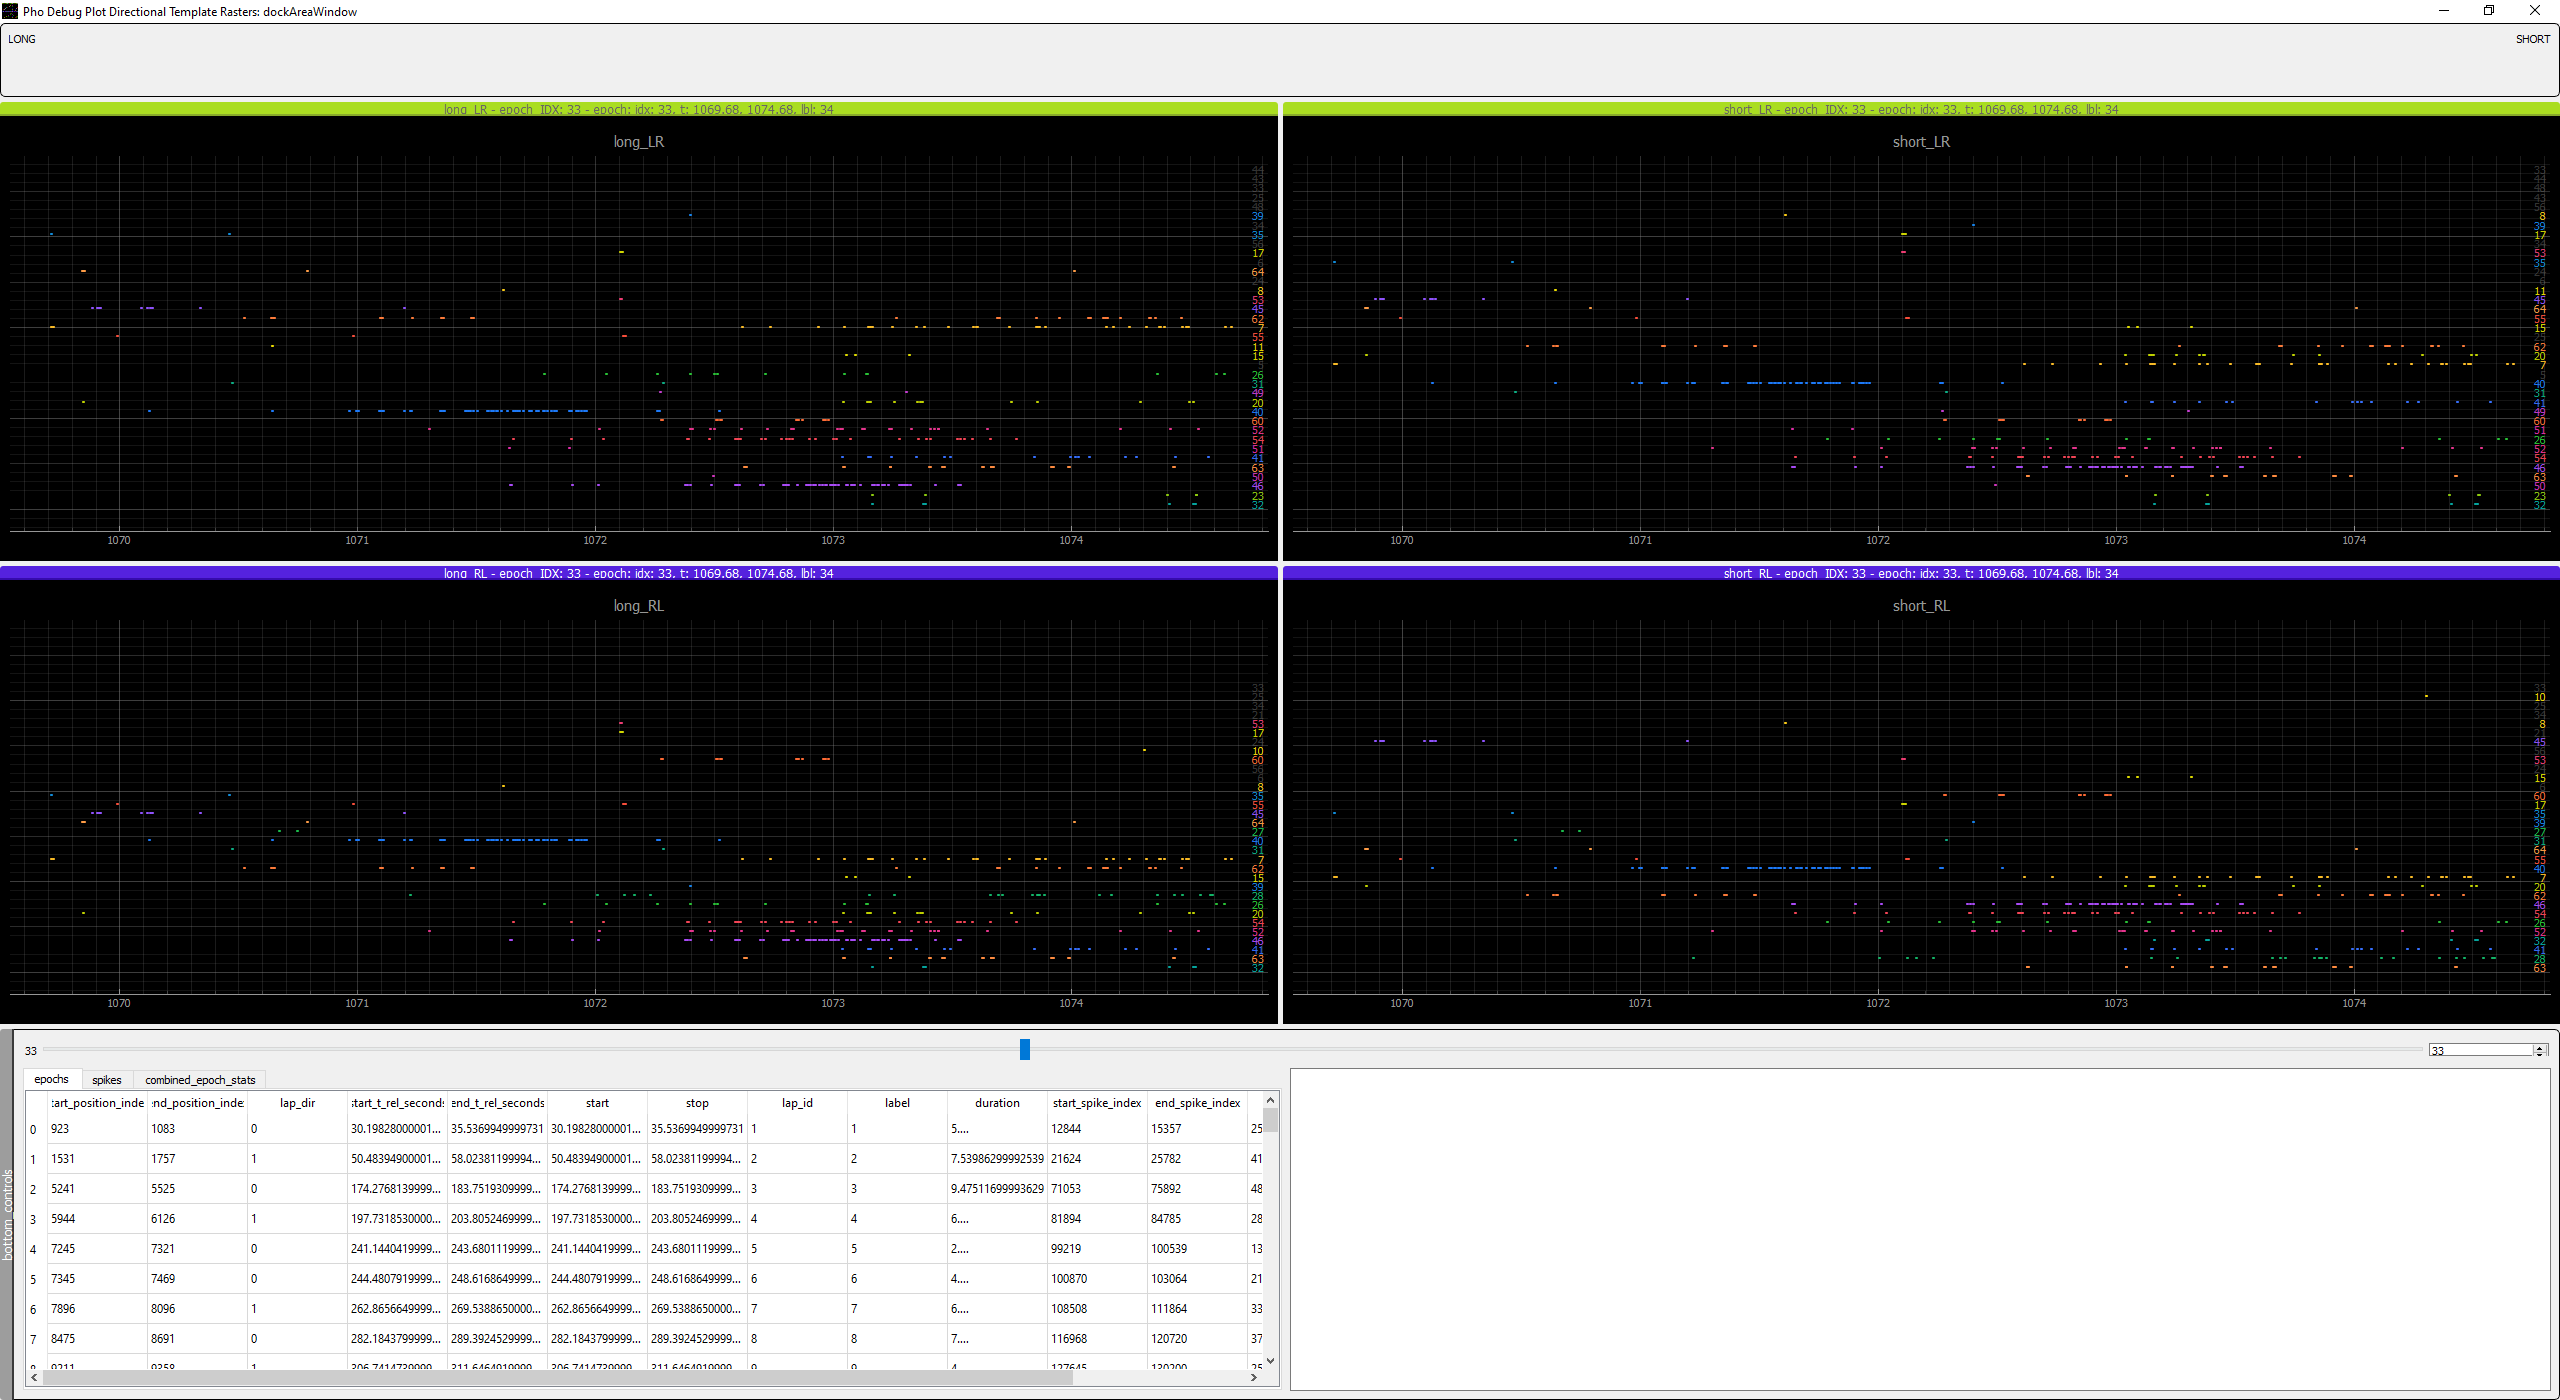 -->
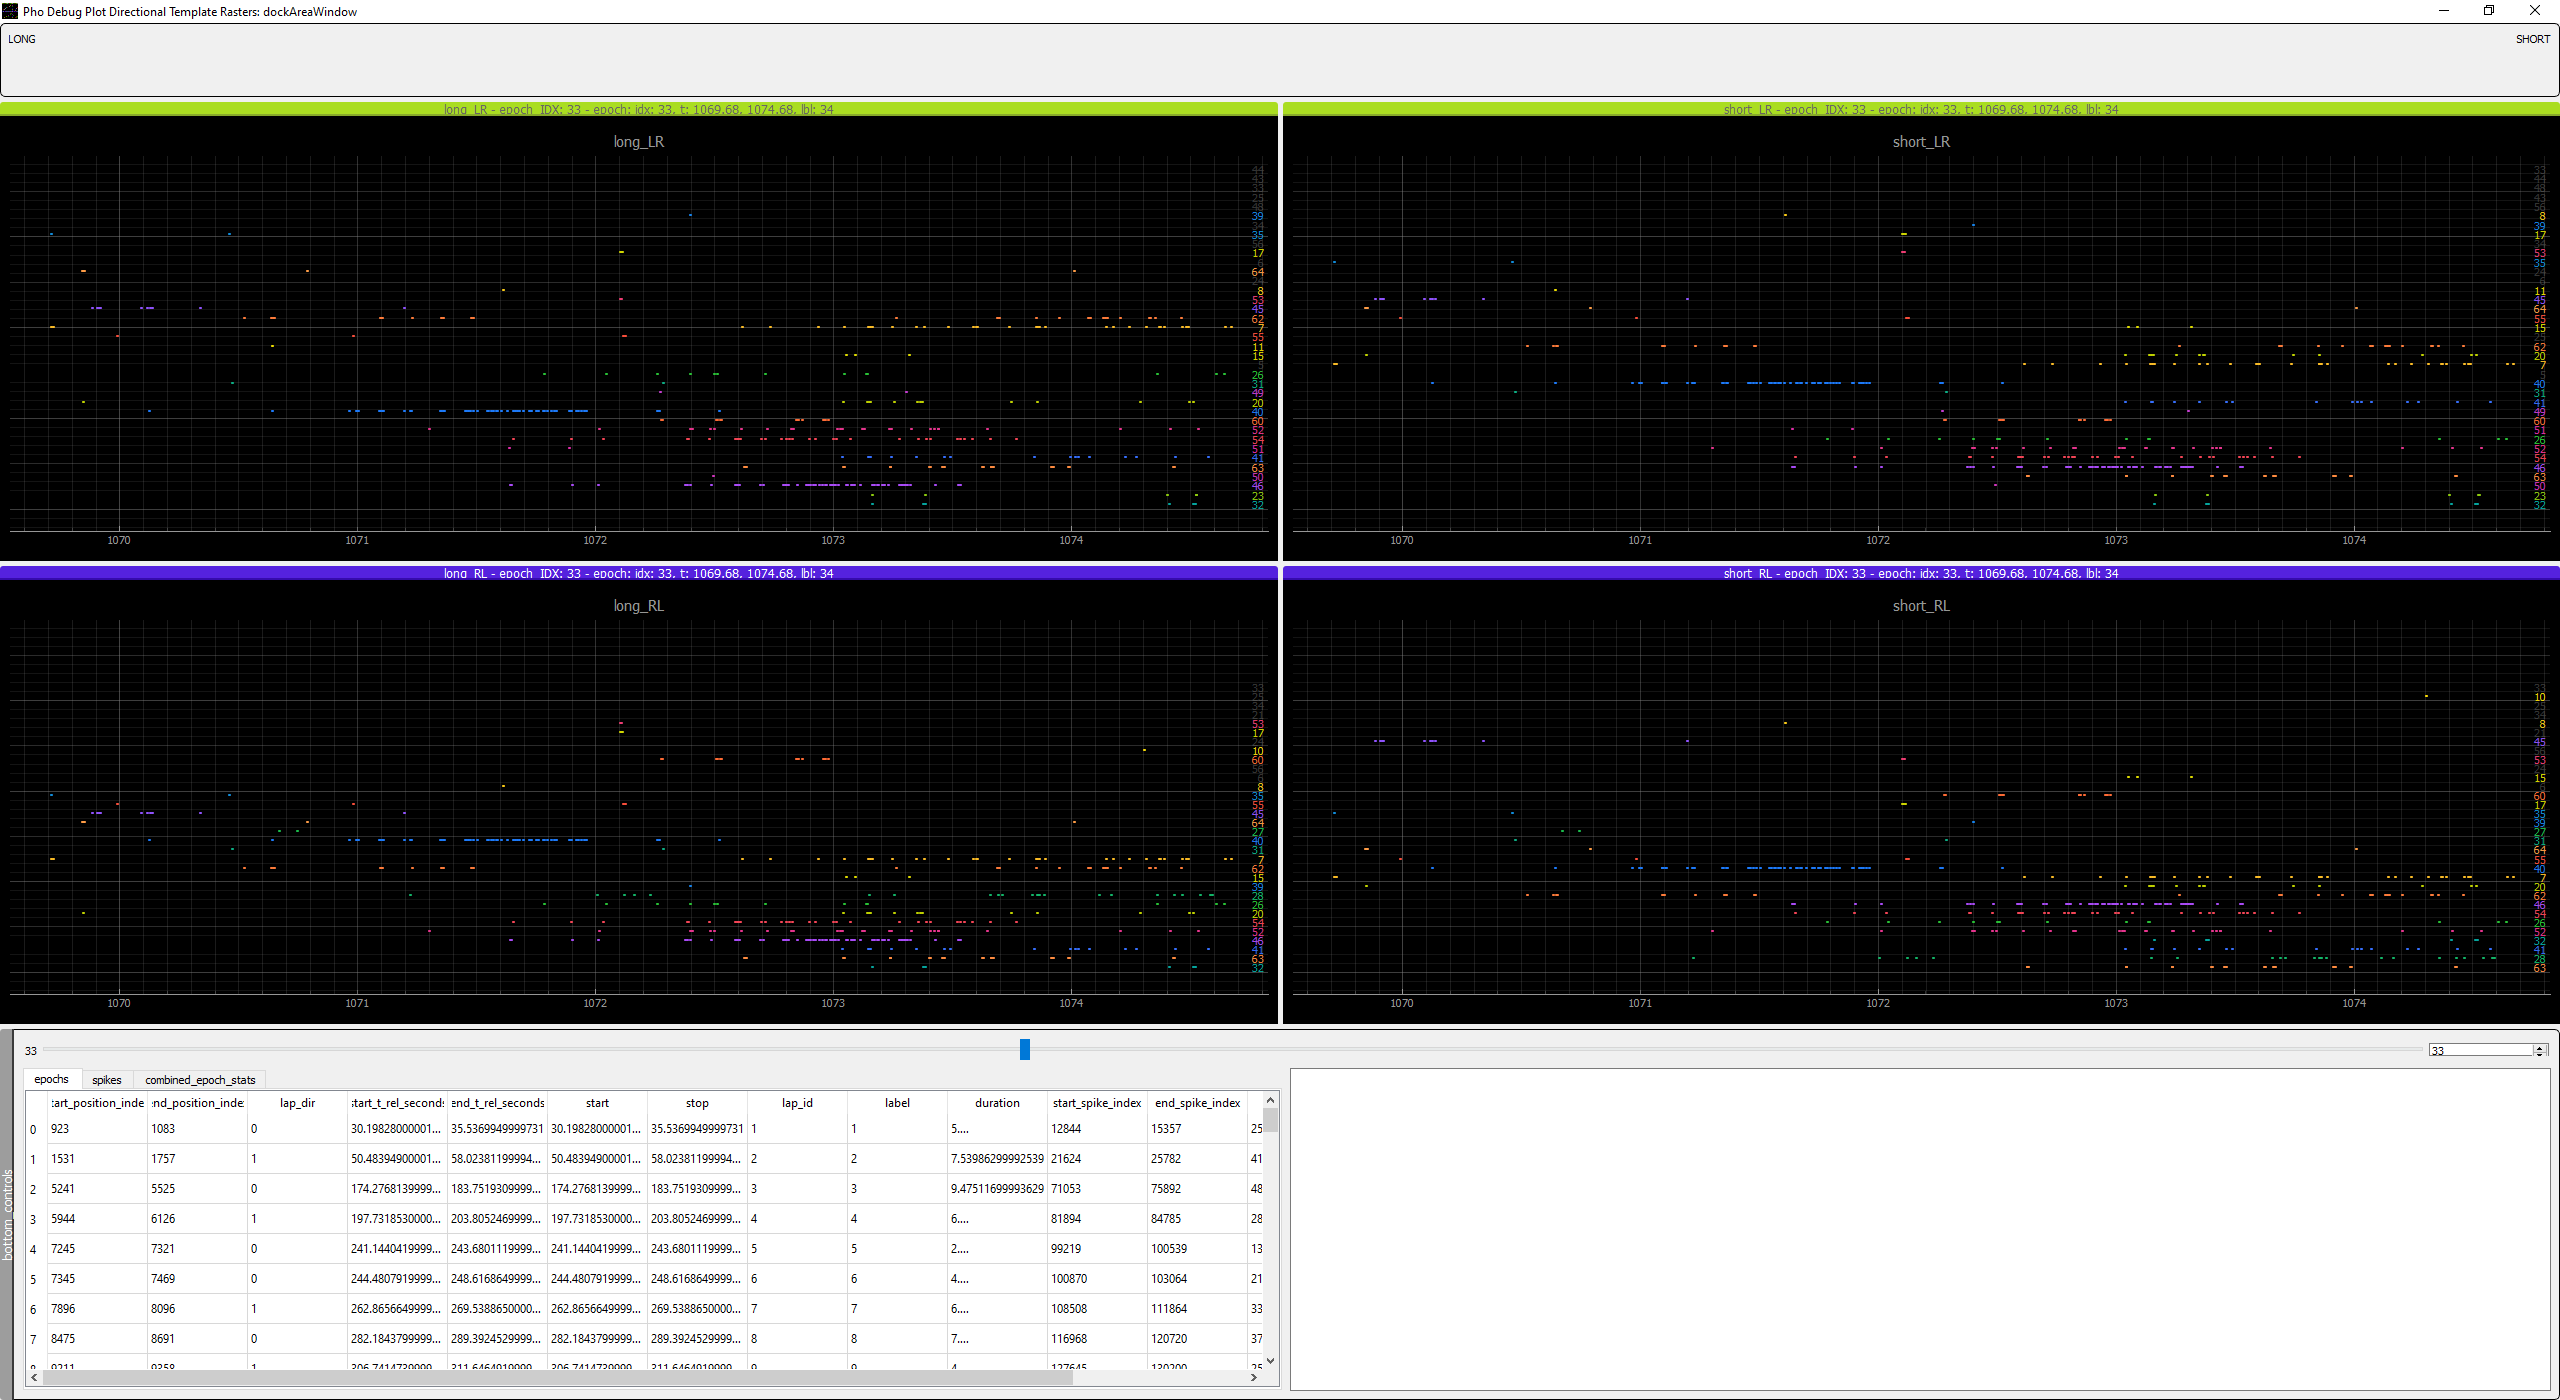{ width=300; max-width: 300px; }
<!-- <img src="path_to_your_image.png" style="max-width: 300px;" /> -->

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)

In [ ]:
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
global_laps_epochs_df = global_laps.to_dataframe()

RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
_out_laps_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, global_laps_epochs_df, track_templates, rank_order_results, RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_laps_rasters

In [ ]:
# long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
# global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
# global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
# global_laps_epochs_df = global_laps.to_dataframe()
global_ripple_epochs_df = global_replays.to_dataframe()

RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, global_ripple_epochs_df, track_templates, rank_order_results, RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_ripple_rasters

In [ ]:
RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
# rank_order_results
# used_rank_order_results = deepcopy(rank_order_results)
used_rank_order_results = None
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                   track_templates, used_rank_order_results,
                                                                                                    RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_ripple_rasters

In [ ]:

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                   track_templates, None,
                                                                                                    None, None,
                                                                                                    dock_add_locations = dict(zip(('long_LR', 'long_RL', 'short_LR', 'short_RL'), (['right'], ['right'], ['right'], ['right']))),
                                                                                                    )
_out_ripple_rasters.set_top_info_bar_visibility(False)


In [ ]:
_out_ripple_rasters.set_top_info_bar_visibility(False)

In [ ]:
# Hide top info bar:
LongShortColumnsInfo_dock_layout, LongShortColumnsInfo_dock_Dock = _out_ripple_rasters.plots.dock_widgets['LongShortColumnsInfo_dock']
# LongShortColumnsInfo_dock_layout.hide() # No use
# _out_ripple_rasters.ui.long_short_info_layout.hide() # No use
LongShortColumnsInfo_dock_Dock.hide()

In [ ]:
LongShortColumnsInfo_dock_Dock.hide()

In [ ]:
# found_IDX = _out_ripple_rasters.find_nearest_time_index(193.65)
# if found_IDX is not None:
#     print(f'found_IDX: {found_IDX}')
#     _out_ripple_rasters.programmatically_update_epoch_IDX(found_IDX)


_out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(193.65)



In [ ]:
_out_ripple_rasters.on_update_epoch_IDX(45)
# on_update_epoch_IDX


In [ ]:
_a_ScrollBarWithSpinBox = _out_ripple_rasters.ui.ctrls_widget # ScrollBarWithSpinBox 
_a_ScrollBarWithSpinBox.setValue(45)

In [ ]:
from neuropy.utils.indexing_helpers import find_nearest_time

# _out_ripple_rasters.active_epochs_df['start']
# _out_ripple_rasters.active_epoch_result_df

df = deepcopy(_out_ripple_rasters.active_epochs_df)
df, closest_index, closest_time, matched_time_difference = find_nearest_time(df=df, target_time=193.65, time_column_name='start', debug_print=True)
df.iloc[closest_index]

In [ ]:
df, closest_index, closest_time, matched_time_difference = find_nearest_time(df=df, target_time=194.65, time_column_name='start', debug_print=True)

In [ ]:
curr_active_pipeline.plot._display_directional_template_debugger()

In [ ]:
_out = curr_active_pipeline.display('_display_directional_template_debugger')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_track_template_pf1Ds')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
'_display_directional_laps_overview'

In [ ]:
# '_display_directional_merged_pfs'
_out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=False, plot_long_directional=True, )

In [ ]:
## Extracting on 2024-02-06 to display the LR/RL directions instead of the All/Long/Short pfs:
def _display_directional_merged_pfs(owning_pipeline_reference, global_computation_results, computation_results, active_configs, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
									plot_all_directions=True, plot_long_directional=False, plot_short_directional=False, **kwargs):
	""" Plots the merged pseduo-2D pfs/ratemaps. Plots: All-Directions, Long-Directional, Short-Directional in seperate windows. 
	
	History: this is the Post 2022-10-22 display_all_pf_2D_pyqtgraph_binned_image_rendering-based method:
	"""
	from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, display_all_pf_2D_pyqtgraph_binned_image_rendering
	from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow 
	

	defer_render = kwargs.pop('defer_render', False)
	directional_merged_decoders_result: DirectionalMergedDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
	active_merged_pf_plots_data_dict = {} #empty dict
	
	if plot_all_directions:
		active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='All-Directions', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.all_directional_pf1D_Decoder.pf # all-directions
	if plot_long_directional:
		active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Long-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.long_directional_pf1D_Decoder.pf # Long-only
	if plot_short_directional:
		active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Short-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.short_directional_pf1D_Decoder.pf # Short-only

	out_plots_dict = {}
	
	for active_context, active_pf_2D in active_merged_pf_plots_data_dict.items():
		# figure_format_config = {} # empty dict for config
		figure_format_config = {'scrollability_mode': LayoutScrollability.NON_SCROLLABLE} # kwargs # kwargs as default figure_format_config
		out_all_pf_2D_pyqtgraph_binned_image_fig: BasicBinnedImageRenderingWindow  = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow
	
		# Set the window title from the context
		out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_context.get_description()}')
		out_plots_dict[active_context] = out_all_pf_2D_pyqtgraph_binned_image_fig

		# Tries to update the display of the item:
		names_list = [v for v in list(out_all_pf_2D_pyqtgraph_binned_image_fig.plots.keys()) if v not in ('name', 'context')]
		for a_name in names_list:
			# Adjust the size of the text for the item by passing formatted text
			a_plot: pg.PlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[a_name].mainPlotItem # PlotItem 
			# no clue why 2 is a good value for this...
			a_plot.titleLabel.setMaximumHeight(2)
			a_plot.layout.setRowFixedHeight(0, 2)
			

		if not defer_render:
			out_all_pf_2D_pyqtgraph_binned_image_fig.show()

	return out_plots_dict

# 2023-12-18 - Simpily detect bimodal cells:

In [ ]:
from neuropy.utils.mixins.peak_location_representing import ContinuousPeakLocationRepresentingMixin
from neuropy.core.ratemap import Ratemap
from scipy.signal import find_peaks
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', sortby=None)

# active_ratemap = deepcopy(long_pf1D.ratemap)
active_ratemap: Ratemap = deepcopy(long_LR_pf1D.ratemap)
peaks_dict, aclu_n_peaks_dict, peaks_results_df = active_ratemap.compute_tuning_curve_modes(height=0.2, width=None)


included_columns = ['pos', 'peak_heights'] # the columns of interest that you want in the final dataframe.
included_columns_renamed = dict(zip(included_columns, ['peak', 'peak_height']))
decoder_peaks_results_dfs = [a_decoder.pf.ratemap.get_tuning_curve_peak_df(height=0.2, width=None) for a_decoder in (track_templates.long_LR_decoder, track_templates.long_RL_decoder, track_templates.short_LR_decoder, track_templates.short_RL_decoder)]
prefix_names = [f'{a_decoder_name}_' for a_decoder_name in track_templates.get_decoder_names()]
all_included_columns = ['aclu', 'series_idx', 'subpeak_idx'] + included_columns # Used to filter out the unwanted columns from the output

# [['aclu', 'series_idx', 'subpeak_idx', 'pos']]

# rename_list_fn = lambda a_prefix: {'pos': f"{a_prefix}pos"}
rename_list_fn = lambda a_prefix: {a_col_name:f"{a_prefix}{included_columns_renamed[a_col_name]}" for a_col_name in included_columns}

# column_names = [f'{a_decoder_name}_peak' for a_decoder_name in track_templates.get_decoder_names()]

# dataFrames = decoder_peaks_results_dfs
# names = self.get_decoder_names()

# rename 'pos' column in each dataframe and then reduce to perform cumulative outer merge
result_df = decoder_peaks_results_dfs[0][all_included_columns].rename(columns=rename_list_fn(prefix_names[0]))
for df, a_prefix in zip(decoder_peaks_results_dfs[1:], prefix_names[1:]):
    result_df = pd.merge(result_df, df[all_included_columns].rename(columns=rename_list_fn(a_prefix)), on=['aclu', 'series_idx', 'subpeak_idx'], how='outer')

# result = reorder_columns(result, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))

## Move the "height" columns to the end
# list(filter(lambda column: column.endswith('_peak_heights'), result.columns))
# result_df = reorder_columns(result_df, column_name_desired_index_dict=dict(zip(list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), np.arange(len(result_df.columns)-4, len(result_df.columns)))))
# result_df

# print(list(result.columns))

## Move the "height" columns to the end
result_df: pd.DataFrame = reorder_columns_relative(result_df, column_names=list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), relative_mode='end').sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True)
result_df

In [ ]:
## Manually Excluded endcap aclus:
IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43')
excluded_endcap_aclus: NDArray = np.array(list(set([40, 60, 85, 102, 52, 6] + [83, 60, 52, 102, 40] + [59, 67, 95, 28, 101] + [14, 15, 87, 71] + [43, 84, 87, 19, 33, 51, 53])))
excluded_endcap_aclus


np.array([  6,  14,  15,  19,  28,  33,  40,  43,  51,  52,  53,  59,  60,  67,  71,  83,  84,  85,  87,  95, 101, 102])




In [ ]:
peaks_results_df = track_templates.get_decoders_aclu_peak_location_df().sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True) ## Does not seem to merge entries as I would expect via intution. It keeps LR/RL peaks distinct and leaves pd.NA values for the entries.
peaks_results_df

In [ ]:
aclu_n_peaks_dict: Dict = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index().set_index('aclu').to_dict()['subpeak_idx_count'] # number of peaks ("models" for each aclu)
aclu_n_peaks_dict

# peaks_results_df = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index()

# peaks_results_df[peaks_results_df.aclu == 5]
# peaks_results_df.aclu.value_counts()

In [ ]:
active_ratemap.n_neurons
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=active_ratemap.neuron_ids, sortby=np.arange(active_ratemap.n_neurons))

In [ ]:

aclu_n_peaks_dict
unimodal_only_aclus = np.array(list(unimodal_peaks_dict.keys()))
unimodal_only_aclus
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=unimodal_only_aclus, sortby=np.arange(active_ratemap.n_neurons))

# 🟪 2024-02-08 Directional Marginals

In [ ]:
all_directional_ripple_filter_epochs_decoder_result_value

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_compute_custom_epoch_decoding

decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict = _perform_compute_custom_epoch_decoding(curr_active_pipeline, directional_merged_decoders_result, track_templates)

In [ ]:
## Recompute the epoch scores/metrics such as radon transform and wcorr:
(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict), merged_df_outputs_tuple, raw_dict_outputs_tuple = _compute_all_df_score_metrics(directional_merged_decoders_result, track_templates, decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict, spikes_df=deepcopy(curr_active_pipeline.sess.spikes_df),
                                                                                                                                                                                     should_skip_radon_transform=True)
laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df, laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df = merged_df_outputs_tuple
decoder_laps_radon_transform_df_dict, decoder_ripple_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict, decoder_ripple_radon_transform_extras_dict, decoder_laps_weighted_corr_df_dict, decoder_ripple_weighted_corr_df_dict = raw_dict_outputs_tuple

# 🖼️🎨 2024-02-08 - `PhoPaginatedMultiDecoderDecodedEpochsWindow` - Plot Ripple Metrics like Radon Transforms, WCorr, Simple Pearson, etc.

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import RadonTransformPlotDataProvider
from neuropy.utils.matplotlib_helpers import add_selection_patch

# decoder_decoded_epochs_result_dict: generic
app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'skip_plotting_most_likely_positions': False, 'enable_per_epoch_action_buttons': False,
                                                                                                               'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                                # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                                # 'disable_y_label': True,
                                                                                                                'isPaginatorControlWidgetBackedMode': True,
                                                                                                                'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                                # 'debug_print': True
                                                                                                                })
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(track_templates, decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(3)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
# active_selections_dict = paginated_multi_decoder_decoded_epochs_window.save_selections()
# paginated_multi_decoder_decoded_epochs_window.ui.print = print
_annotations = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()


In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v._subfn_clear_selectability_rects()
    
# paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    a_ctrlr.perform_update_selections(defer_render=False)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [array([785.738, 785.923])]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [array([427.461, 427.557])]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [array([833.339, 833.451])]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [array([491.798, 492.178]), array([940.016, 940.219])]


# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]
	

# with Ctx(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[208.356, 208.523], [693.842, 693.975], [954.574, 954.679]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[224.037, 224.312]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[145.776, 146.022], [198.220, 198.582], [220.041, 220.259], [511.570, 511.874], [865.238, 865.373]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[191.817, 192.100], [323.147, 323.297]]



In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-paginated_multi_decoder_decoded_epochs_window_page.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    paginated_multi_decoder_decoded_epochs_window.jump_to_page(2)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(1)

In [ ]:
decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
track_templates.get_decoder_names()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v.params.enable_radon_transform_info = True
    v.params.enable_weighted_correlation_info = True
    v.params.debug_enabled = True

paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    print(f'decoder[{k}]:')
    v.params.name
    # v.params.on_render_page_callbacks
    # v.params.enable_radon_transform_info
    len(v.plots_data.radon_transform_data)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(track_templates, decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()

In [ ]:
def _sub_subfn_wrapped_in_brackets(s: str, bracket_strings = ("[", "]")) -> str:
        return bracket_strings[0] + s + bracket_strings[1]
    
def _sub_subfn_format_nested_list(arr, precision:int=3, num_sep=", ", array_sep=', ') -> str:
    """
    Converts a nested list of floats into a single string,
    with each float formatted to the specified precision.
    
    arr = np.array([[491.798, 492.178], [940.016, 940.219]])
    _sub_subfn_format_nested_list(arr)

    >> '[[491.798, 492.178], [940.016, 940.219]]'

    arr = np.array([[785.738, 785.923]])
    _sub_subfn_format_nested_list(arr)
    >> '[[785.738, 785.923]]'
    """
    return _sub_subfn_wrapped_in_brackets(array_sep.join([_sub_subfn_wrapped_in_brackets(num_sep.join([f"{num:.{precision}f}" for num in row])) for row in arr]))
    
# arr = np.array([[491.798, 492.178], [940.016, 940.219]])
arr = np.array([[785.738, 785.923]])
_sub_subfn_format_nested_list(arr)

In [ ]:
def _build_attached_raster_viewer(curr_active_pipeline, track_templates):
    """ creates a new RankOrderRastersDebugger for use by `paginated_multi_decoder_decoded_epochs_window` 
    """
    long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
    global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
    _out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                    track_templates, None,
                                                                                                        None, None,
                                                                                                        dock_add_locations = dict(zip(('long_LR', 'long_RL', 'short_LR', 'short_RL'), (['right'], ['right'], ['right'], ['right']))),
                                                                                                        )
    _out_ripple_rasters.set_top_info_bar_visibility(False)
    return _out_ripple_rasters


_out_ripple_rasters = _build_attached_raster_viewer(curr_active_pipeline, track_templates)


In [ ]:
## Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior.
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)


for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}    
    a_pagination_controller.params.on_middle_click_item_callbacks['an_alt_clicked_epoch_callback'] = an_alt_clicked_epoch_callback



In [ ]:
# Uses _out_ripple_rasters's debug log printing as the source for the PhoPaginatedMultiDecoderDecodedEpochsWindow's print statements. .write_to_log('test_log_message')
import builtins
import io
from contextlib import redirect_stdout # used by DocumentationFilePrinter to capture print output

def new_private_print(a_controller_name, *args, **kwargs):
    """ wraps the default print function or whatever needs to be called. """
    print(f"{a_controller_name}:\t", *args, **kwargs)

    out = io.StringIO()
    with redirect_stdout(out):
        ## Registered printing functions are called here, and anything they print is written to the textarea at the bottom of the widget.
        print(f"{a_controller_name}:\t", *args, **kwargs, end='') # Specify end='' to avoid adding a newline character at the end

    # Capture the value from StringIO object and write to log
    log_strings = str(out.getvalue())
    _out_ripple_rasters.write_to_log(log_strings)


for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    a_pagination_controller.params.debug_print = True
    # Here we replace the lambda with a partial to bind the name to the new_private_print function.
    from functools import partial
    a_pagination_controller.ui.print = partial(new_private_print, a_name)
    # a_pagination_controller.ui.print = lambda *args, **kwargs: new_private_print(a_name, *args, **kwargs) # builtins.print # the print function to use



### 2024-02-29 3pm - Get the active user-annotated epoch times from the `paginated_multi_decoder_decoded_epochs_window` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:

# Inputs: paginated_multi_decoder_decoded_epochs_window, filtered_ripple_simple_pf_pearson_merged_df
any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))


## 🔶 2024-03-01 - Get the active user-annotated epoch times from the `UserAnnotationsManager` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:
from neuropy.utils.misc import numpyify_array
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.epoch import EpochsAccessor
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

In [ ]:
from neuropy.core.epoch import find_data_indicies_from_epoch_times
## Get from UserAnnotations directly instead of the intermediate viewer



# directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
# ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
# laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict



## # inputs: any_good_selected_epoch_times, any_good_selected_epoch_times, any_good_selected_epoch_indicies

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies
# Add user-selection columns to df
a_df = deepcopy(filtered_ripple_simple_pf_pearson_merged_df)
# a_df = deepcopy(ripple_weighted_corr_merged_df)
a_df['is_user_annotated_epoch'] = False
# any_good_selected_epoch_indicies = a_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, np.squeeze(any_good_selected_epoch_times[:,0]), t_column_names=['ripple_start_t',])
# any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, any_good_selected_epoch_times, t_column_names=['ripple_start_t',])
any_good_selected_epoch_indicies
# a_df['is_user_annotated_epoch'] = np.isin(a_df.index.to_numpy(), any_good_selected_epoch_indicies)
a_df['is_user_annotated_epoch'].iloc[any_good_selected_epoch_indicies] = True
a_df


In [ ]:
collected_outputs_path = Path(r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs').resolve() # Apogee
assert collected_outputs_path.exists()

active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            user_annotation_selections={'ripple': any_good_selected_epoch_times})
_output_csv_paths

In [ ]:
df = DecoderDecodedEpochsResult.filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
df


### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# delta_aligned_start_t

In [ ]:
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _helper_build_figure
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plotly_pre_post_delta_scatter


session_name: str = curr_active_pipeline.session_name
earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end = curr_active_pipeline.find_LongShortDelta_times()
histogram_bins = 25

concatenated_ripple_df = deepcopy(df)

# ripple_title_prefix = 'test'
# # Create a bubble chart for ripples
# ripple_num_unique_sessions: int = concatenated_ripple_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
# # ripple_num_unique_time_bins: int = concatenated_ripple_df.time_bin_size.nunique(dropna=True)
# ripple_title_string_suffix: str = f'{ripple_num_unique_sessions} Sessions'
# ripple_title: str = f"{ripple_title_prefix} - {ripple_title_string_suffix}"
# fig_ripples = _helper_build_figure(data_results_df=concatenated_ripple_df, histogram_bins=histogram_bins, earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end, enabled_time_bin_sizes=None,
#                                     main_plot_mode='separate_row_per_session', title=ripple_title)


scatter_title = session_name
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end))
new_fig_ripples




In [ ]:
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end

In [ ]:
df['_wcorr_y_col'] = df['long_best_wcorr'].abs()
df['_wcorr_y_col_y_diff_col'] = df['long_best_wcorr'].abs() - df['short_best_wcorr'].abs()
# df.plot.scatter(x='ripple_start_t', y='wcorr_y_col')
df.plot.scatter(x='delta_aligned_start_t', y='_wcorr_y_col_y_diff_col')



In [ ]:
# df['pearsonr_long_abs'] = df['long_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_short_abs'] = df['short_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_diff'] = df['long_best_pf_peak_x_pearsonr'].abs() - df['short_best_pf_peak_x_pearsonr'].abs()

# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_long_abs')
# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_short_abs')
df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_abs_diff')




In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
from pyphocorehelpers.programming_helpers import copy_to_clipboard
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import EpochSelectionsObject


paginated_multi_decoder_decoded_epochs_window.ui.print = print
# annotations_man = UserAnnotationsManager()
# user_annotations = annotations_man.get_user_annotations()
# saved_selections_dict: Dict[str, EpochSelectionsObject] = paginated_multi_decoder_decoded_epochs_window.save_selections()
# saved_selections_contexts_dict = {a_name:v.figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, v in saved_selections_dict.items()}
saved_selections_contexts_dict = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()
# saved_selections_contexts_dict


# copy_to_clipboard("First line\nSecond line") # First line\nSecond line

# copy_to_clipboard("First line\r\nSecond line")



# user_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='long_LR',user_annotation='selections')] = array([array([380.739, 380.865]), array([550.845, 551.034]), array([600.244, 600.768]), array([1431.7, 1431.87])])\nuser_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='long_RL',user_annotation='selections')] = array([array([1202.96, 1203.26]), array([1433.42, 1433.58]), array([1600.77, 1601.16])])\nuser_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='short_LR',user_annotation='selections')] = array([array([551.872, 552.328]), array([565.161, 565.417]), array([616.348, 616.665]), array([919.581, 919.692]), array([1149.57, 1149.8]), array([1167.82, 1168.17]), array([1384.71, 1385.01]), array([1424.02, 1424.22]), array([1446.52, 1446.65]), array([1538.1, 1538.48])])\nuser_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='short_RL',user_annotation='selections')] = array([array([373.508, 373.754]), array([391.895, 392.163]), array([600.244, 600.768]), array([1015.26, 1015.5]), array([1079.9, 1080.08]), array([1310.59, 1310.92]), array([1433.42, 1433.58]), array([1494.95, 1495.4]), array([1558.22, 1558.42])])

# user_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='long_LR',user_annotation='selections')] = array([array([380.739, 380.865]), array([550.845, 551.034]), array([600.244, 600.768]), array([1431.7, 1431.87])])
# user_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='long_RL',user_annotation='selections')] = array([array([1202.96, 1203.26]), array([1433.42, 1433.58]), array([1600.77, 1601.16])])
# user_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='short_LR',user_annotation='selections')] = array([array([551.872, 552.328]), array([565.161, 565.417]), array([616.348, 616.665]), array([919.581, 919.692]), array([1149.57, 1149.8]), array([1167.82, 1168.17]), array([1384.71, 1385.01]), array([1424.02, 1424.22]), array([1446.52, 1446.65]), array([1538.1, 1538.48])])
# user_annotations[IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40',display_fn_name='DecodedEpochSlices',epochs='ripple',decoder='short_RL',user_annotation='selections')] = array([array([373.508, 373.754]), array([391.895, 392.163]), array([600.244, 600.768]), array([1015.26, 1015.5]), array([1079.9, 1080.08]), array([1310.59, 1310.92]), array([1433.42, 1433.58]), array([1494.95, 1495.4]), array([1558.22, 1558.42])])"


### Add utility footer

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, get_utility_dock_colors
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget

ui = paginated_multi_decoder_decoded_epochs_window.ui._contents

ui.dock_widgets
ui.dock_configs


In [ ]:

## Build the utility controls at the bottom:
ctrls_dock_config = CustomDockDisplayConfig(custom_get_colors_callback_fn=get_utility_dock_colors, showCloseButton=False)

button_bar_height = 21
ctrls_button_bar_widget = ThinButtonBarWidget()
ctrls_button_bar_widget.setObjectName("ctrls_button_bar")

ctrl_layout = pg.LayoutWidget()
ctrl_layout.addWidget(ctrls_button_bar_widget, row=1, rowspan=1, col=1, colspan=2)
ctrl_widgets_dict = dict(ctrls_widget=ctrls_button_bar_widget)
# ctrl_layout.setSizePolicy(

def onCopySelectionsClicked():
    print(f'onCopySelectionsClicked()')
    saved_selections_contexts_dict = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

ctrl_widgets_dict['copy_selection_connection'] = ctrls_button_bar_widget.sigCopySelections.connect(onCopySelectionsClicked)

ui.dock_widgets['bottom_controls'] = paginated_multi_decoder_decoded_epochs_window.add_display_dock(identifier='bottom_controls', widget=ctrl_layout, dockSize=(600, button_bar_height), dockAddLocationOpts=['bottom'], display_config=ctrls_dock_config)
ui.dock_widgets['bottom_controls'][1].hideTitleBar()
ui.dock_widgets['bottom_controls']



In [ ]:
button_bar_height = 21

a_layout = ui.dock_widgets['bottom_controls'][0]
a_layout.size()
a_layout.setContentsMargins(0,0,0,0)
a_layout.setFixedHeight(21)

In [ ]:
ui.dock_widgets['bottom_controls'][1].size()
ui.dock_widgets['bottom_controls'][1].setContentsMargins(0,0,0,0)
# ui.dock_widgets['bottom_controls'][1].hideTitleBar()
# ui.dock_widgets['bottom_controls'][1].size

In [ ]:
setMargin

In [ ]:
ui.dock_widgets['bottom_controls'][0].resize(600, 21)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.find_display_dock('bottom_controls')

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_display_dock('bottom_controls')

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager

## Set epoch annotations from selections epochs 
annotations_man = UserAnnotationsManager()
user_annotations = annotations_man.get_user_annotations()
new_selections_dict = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations)


In [ ]:
loaded_selections_objs_dict = {a_name:EpochSelectionsObject(epoch_times=a_selections_values) for a_name, a_selections_values in loaded_selections_dict.items()}
loaded_selections_objs_dict

## Select just the selected epoch times


In [ ]:
saved_selections_context_dict = {a_name:v.figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, v in saved_selections_dict.items()}

In [ ]:
user_annotations

In [ ]:
paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

In [ ]:
## Remove the excessively long plot titles?
# root_dockAreaWindow.update
pagination_controller_dict = paginated_multi_decoder_decoded_epochs_window.pagination_controllers
all_widgets = {a_decoder_name:a_pagination_controller.ui.mw for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_windows = {a_decoder_name:a_pagination_controller.ui.mw.window() for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots = {a_decoder_name:a_pagination_controller.plots for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots_data = {a_decoder_name:a_pagination_controller.plots_data for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_params = {a_decoder_name:a_pagination_controller.params for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx = {a_decoder_name:a_pagination_controller.current_page_idx for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx

In [ ]:
# all_separate_plots

all_separate_weighted_corr_plots = {a_decoder_name:a_pagination_controller.plots.get('weighted_corr', {}) for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_weighted_corr_plots

In [ ]:
self.ui.print = self.private_print # builtins.print # the print function to use

In [ ]:
from neuropy.core.epoch import EpochsAccessor

# MLM
# {a_name:a_ctrlr.params.is_selected for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}
# {a_name:a_ctrlr.selected_epoch_times for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}

any_good_selected_epoch_times: NDArray = paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times # drops duplicate rows (present in multiple decoders), and sorts them ascending
# any_good_selected_epoch_times
# Only at the decoder-level
any_good_epoch_idxs_list = [a_ctrlr.find_data_indicies_from_epoch_times(any_good_selected_epoch_times) for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items()]
any_good_epoch_idxs: NDArray = any_good_epoch_idxs_list[0]
any_good_epoch_idxs

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:

# filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)

found_data_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(epoch_times=any_good_selected_epoch_times)
df = filtered_ripple_simple_pf_pearson_merged_df.epochs._obj.iloc[found_data_indicies].copy().reset_index(drop=True)
df

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df


In [ ]:
hand_selected_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.iloc[any_good_epoch_idxs, :].reset_index(drop=True)
hand_selected_ripple_simple_pf_pearson_merged_df

In [ ]:
# hand_selected_ripple_simple_pf_pearson_merged_df['best_decoder_index']

is_most_likely_long = (hand_selected_ripple_simple_pf_pearson_merged_df['P_Long'] >= 0.5)
# is_most_likely_long

long_likely_hand_selected_ripple_simple_pf_pearson_merged_df = hand_selected_ripple_simple_pf_pearson_merged_df[is_most_likely_long]
long_likely_hand_selected_ripple_simple_pf_pearson_merged_df


In [ ]:
_test_df.long_LR_pf_peak_x_pearsonr.hist()
_test_df.long_RL_pf_peak_x_pearsonr.hist()
_test_df.short_LR_pf_peak_x_pearsonr.hist()
_test_df.short_RL_pf_peak_x_pearsonr.hist()

## 🖼️🎨 Plot laps to compare between decoders:

In [ ]:
laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates, decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', included_epoch_indicies=None)
laps_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(track_templates, decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)


In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict

In [ ]:
# list(decoder_laps_filter_epochs_decoder_result_dict.keys())
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
## Get the figure from the axes:
a_fig = ax.get_figure()
a_fig.canvas.draw()

In [ ]:
a_controlling_pagination_controller = laps_paginated_multi_decoder_decoded_epochs_window.contents.pagination_controllers['long_LR'] # DecodedEpochSlicesPaginatedFigureController
a_pagination_controller_figure_widget = paginator_controller_widget = a_controlling_pagination_controller.ui.mw # MatplotlibTimeSynchronizedWidget
paginator_controller_widget = a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget # PaginationControlWidget
# paginator_controller_widget
a_pagination_controller_figure_widget.draw()

In [ ]:
axs = a_controlling_pagination_controller.plots.axs

In [ ]:
ax.get_figure().canvas.draw()


In [ ]:
selection_rectangles_dict = a_controlling_pagination_controller.plots.get('selection_rectangles_dict', None)
selection_rectangles_dict


In [ ]:
ax_pos.x1

In [ ]:
rectangle.remove()

In [ ]:
# a_controlling_pagination_controller.plots.fig.canvas.draw_idle()
# a_controlling_pagination_controller.plots.fig.canvas.draw()
# paginator_controller_widget.update()
a_pagination_controller_figure_widget.draw()

In [ ]:

a_controlling_pagination_controller.params.is_selected


In [ ]:
paginator_controller_widget.go_to_page(3)
# paginator_controller_widget.jump_to_page(3)

In [ ]:
a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget.jump_to_page

new_obj.plots_data.paginator
new_obj.params.active_identifying_figure_ctx
new_obj.on_paginator_control_widget_jump_to_page(page_idx=0)
new_obj.ui.connections['paginator_controller_widget_jump_to_page']


In [ ]:
for i, extant_plots in a_plots['weighted_corr'].items():
    extant_wcorr_text = extant_plots.get('wcorr_text', None)
    # extant_wcorr_text = extant_plots.pop('wcorr_text', None)
    print(f'extant_wcorr_text: {extant_wcorr_text}')
    # plot the radon transform line on the epoch:
    if (extant_wcorr_text is not None):
        # already exists, clear the existing ones. 
        # Let's assume we want to remove the 'Quadratic' line (line2)
        print(f'removing extant text object at index: {i}.')
        # extant_wcorr_text.remove()
        extant_wcorr_text.remove()

In [ ]:
for a_name, a_pagination_controller in pagination_controller_dict.items():
    display_context = a_pagination_controller.params.get('active_identifying_figure_ctx', IdentifyingContext())

    # Get context for current page of items:
    current_page_idx: int = int(a_pagination_controller.current_page_idx)
    a_paginator = a_pagination_controller.paginator
    total_num_pages = int(a_paginator.num_pages)
    page_context = display_context.overwriting_context(page=current_page_idx, num_pages=total_num_pages)
    print(page_context)

    ## Get the figure/axes:
    a_plots = a_pagination_controller.plots # RenderPlots
    a_plot_data = a_pagination_controller.plots_data

    a_params = a_pagination_controller.params
    a_params.skip_plotting_measured_positions

    figs = a_plots.fig
    axs = a_plots.axs

    # # with mpl.rc_context({'figure.figsize': (8.4, 4.8), 'figure.dpi': '220', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    # with mpl.rc_context({'figure.figsize': (16.8, 4.8), 'figure.dpi': '420', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    #     curr_active_pipeline.output_figure(final_context=page_context, fig=figs, write_vector_format=True)

## 💾 Export Paginated Content

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export_decoder_pagination_controller_figure_page(curr_active_pipeline)

In [ ]:
from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetPositioningHelpers

screen_rect = WidgetPositioningHelpers.get_screen_desktopRect(screen_index=None, debug_print=True)
screen_size = screen_rect.size()
screen_height = screen_rect.height()
screen_height

In [ ]:
screen = a_widget.screen()
screen_size = screen.size()
desired_final_height = int(min((new_obj.params.all_plots_height + 30), screen_size.height())) # don't allow the height to exceed the screen height.
a_widget.setMinimumHeight(desired_final_height)

In [ ]:
# also have params.scrollAreaContents_MinimumHeight ??
# if self.params.scrollAreaContents_MinimumHeight is not None:
#     self.ui.scrollAreaContentsWidget.setMinimumHeight(self.params.scrollAreaContents_MinimumHeight)

target_height = _out_pagination_controller.params.get('scrollAreaContents_MinimumHeight', None)
target_height

## 🔷🎨 Single Decoder Version (`DecodedEpochSlicesPaginatedFigureController`)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import _subfn_update_decoded_epoch_slices
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController # `plot_decoded_epoch_slices_paginated`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import WeightedCorrelationPaginatedPlotDataProvider

# Inputs: epochs_name, decoder_ripple_filter_epochs_decoder_result_dict, curr_active_pipeline
epochs_name = 'ripple'

(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]

a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]
_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(a_decoder_decoded_epochs_result.filter_epochs,
                                                                                    a_decoder_decoded_epochs_result,
                                                                                    xbin=a_decoder.xbin, global_pos_df=curr_active_pipeline.sess.position.df,
                                                                                    a_name=f'DecodedEpochSlices[{a_name}]', active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs=epochs_name, decoder=a_name),
                                                                                    max_subplots_per_page=64,
                                                                                    params_kwargs={'skip_plotting_most_likely_positions': False, 'enable_per_epoch_action_buttons': False,
                                                                                                    'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 8,
                                                                                                    'scrollable_figure': True,
                                                                                    })
_out_pagination_controller.params.should_suppress_callback_exceptions = False
_out_pagination_controller.add_data_overlays(decoder_ripple_filter_epochs_decoder_result_dict[a_name])
_tmp_out_selections = _out_pagination_controller.restore_selections_from_user_annotations()

C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\Pho2D\matplotlib\CustomMatplotlibWidget.py:196: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.ui.canvas.draw()
C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\DisplayFunctions\DecoderPredictionError.py:308: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim((xmin, xmax)) # UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


target_height: 6430.0,   desired_final_height = 1440


C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\DisplayFunctions\DecoderPredictionError.py:308: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim((xmin, xmax)) # UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


current_page_idx = 1, found_data_index =97
DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed(...)
	DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed: selection changed!
current_page_idx = 1, found_data_index =95
DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed(...)
	DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed: selection changed!
current_page_idx = 1, found_data_index =106
DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed(...)
	DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed: selection changed!
current_page_idx = 1, found_data_index =127
DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed(...)
	DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed: selection changed!
current_page_idx = 2, found_data_index =181
DecodedEpochSlicesPaginatedFigureController.on_selected_epochs_changed(...)
	DecodedEpochSlicesPaginatedFigure

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# Create a figure and an axis
a_fig, ax = plt.subplots()

# Define your multi-line text with proper newline characters
title = "This is line 1\nThis is line 2\nThis is line 3"

# Define text properties (this will ensure that the text within the box is centered)
text_prop_kwargs = {'horizontalalignment': 'center',
                    # 'va': 'top',
                    # 'rotation': -45,
                    }



# Get the axes bounding box in figure coordinates
bbox = ax.get_position()
bbox
# Compute midpoint between the top of the axis and the top of the figure
top_of_axis = bbox.ymax
top_of_figure = 1.0
midpoint_y = (top_of_axis + top_of_figure) / 2
midpoint_y
bbox.x0, bbox.x1

half_x_margin_width = (1.0 - bbox.width) / 2.0
half_x_margin_width

half_y_margin_width = (1.0 - bbox.ymax) / 2.0
half_y_margin_width

bbox_offset_magnitude: float = 0.075

bbox_offset_magnitude = (half_x_margin_width, half_y_margin_width)

# ax.position()

# Create the AnchoredText object with the specified location and properties
# Use `loc='upper right'` or `loc=1` for the upper-right corner
# Additional kwargs like `bbox_to_anchor` might be useful if you need further adjustments
at = AnchoredText(f"1{title}", loc='upper left',
                        prop=({'rotation': 45, 'horizontalalignment': 'right'} | text_prop_kwargs), pad=0.0, borderpad=0.0, frameon=False,
                        bbox_to_anchor=(-bbox_offset_magnitude[0], (1.0 + bbox_offset_magnitude[1])), bbox_transform=ax.transAxes, transform=a_fig.transFigure,
                        # transform=ax.transAxes
                       )
# Add the AnchoredText object to the plot
ax.add_artist(at)


at2 = AnchoredText(f"2{title}", loc='upper right',
                        prop=({'rotation': -45, 'horizontalalignment': 'center'} | text_prop_kwargs), pad=0.0, borderpad=0.0, frameon=False,
                        bbox_to_anchor=((1.0 + bbox_offset_magnitude[0]), (1.0 + bbox_offset_magnitude[1])), bbox_transform=ax.transAxes, transform=a_fig.transFigure,
                        # transform=ax.transAxes,
                        
                       )
# Add the AnchoredText object to the plot
ax.add_artist(at2)


# Display the plot
plt.show()

In [ ]:
# Get the axes bounding box in figure coordinates
bbox = ax.get_position()
bbox
# Compute midpoint between the top of the axis and the top of the figure
top_of_axis = bbox.ymax
top_of_figure = 1.0
midpoint_y = (top_of_axis + top_of_figure) / 2
midpoint_y
bbox.x0, bbox.x1

half_x_margin_width = (1.0 - bbox.width) / 2.0
half_x_margin_width

half_y_margin_width = (1.0 - bbox.ymax) / 2.0
half_y_margin_width

# half_x_margin_width = (1.0 - bbox.width) / 2.0
# half_x_margin_width

# ax.translated(



# 1.0 - ax.ymax

right_margin_width = 1.0 - bbox.x1
right_margin_width

In [ ]:
bbox.po

In [ ]:
a_widget = _out_pagination_controller.ui.mw.window()
destop_w = a_widget.app.desktop()
destop_w



In [ ]:
single_page_app.desktop()

In [ ]:
# assert screen_index <= (destop_w.screenCount()-1), f"specified screen_index screen_index: {screen_index} is invalid. widget.screenCount(): {destop_w.screenCount()}"
desktopRect = destop_w.screenGeometry(screen_index) # get screen geometry of secondary screen. PyQt5.QtCore.QRect(-3440, 0, 3440, 1440)


In [ ]:
screen = a_widget.screen()
screen_size = screen.size()

# Print the screen size
print(screen_size.width(), screen_size.height())

In [ ]:
(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]
a_name

## 🔷🎨 2024-03-06 - Uni Page Scrollable Version

In [ ]:
# decoder_decoded_epochs_result_dict: generic
single_page_app, single_page_paginated_multi_decoder_decoded_epochs_window, single_page_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'skip_plotting_most_likely_positions': False, 'enable_per_epoch_action_buttons': False,
                                                                                                               'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                                # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                                # 'disable_y_label': True,
                                                                                                                'isPaginatorControlWidgetBackedMode': True,
                                                                                                                'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                                # 'debug_print': True,
                                                                                                                'max_subplots_per_page': 64,
                                                                                                                'scrollable_figure': True,
                                                                                                                })
single_page_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(track_templates, decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
_tmp_out_selections = single_page_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
# for curr_results_obj: LeaveOneOutDecodingAnalysisResult object
num_filter_epochs:int = curr_results_obj.active_filter_epochs.n_epochs

# `active_filter_epochs_df` native columns approach
active_filter_epochs_df = curr_results_obj.active_filter_epochs.to_dataframe().copy()
assert np.isin(['score', 'velocity', 'intercept', 'speed'], active_filter_epochs_df.columns).all()
epochs_linear_fit_df = active_filter_epochs_df[['score', 'velocity', 'intercept', 'speed']].copy() # get the `epochs_linear_fit_df` as a subset of the filter epochs df
# epochs_linear_fit_df approach
assert curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs == np.shape(epochs_linear_fit_df)[0]

num_filter_epochs:int = curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs # curr_results_obj.num_filter_epochs
try:
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.time_bin_containers)
except AttributeError as e:
    # AttributeError: 'LeaveOneOutDecodingAnalysisResult' object has no attribute 'time_bin_containers' is expected when `curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting`
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.all_included_filter_epochs_decoder_result.time_bin_containers) # for curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting

radon_transform_data = RadonTransformPlotDataProvider._subfn_build_radon_transform_plotting_data(active_filter_epochs_df=active_filter_epochs_df,
            num_filter_epochs = num_filter_epochs, time_bin_containers = time_bin_containers, radon_transform_column_names=['score', 'velocity', 'intercept', 'speed'])
    

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export

In [ ]:
# _display_long_and_short_stacked_epoch_slices
curr_active_pipeline.reload_default_display_functions()
_out_dict = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', save_figure=True)

## Other:

In [ ]:
_out = _out_pagination_controller.plots['radon_transform'][7]
extant_line = _out['line'] # matplotlib.lines.Line2D
extant_line.linestyle = 'none'
# extant_line.draw()



In [ ]:
print(list(curr_active_pipeline.filtered_contexts.keys())) # ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']


# long_any_name

# long_LR_name

# Converting between decoder names and filtered epoch names:
{'long':'maze1', 'short':'maze2'}
{'LR':'odd', 'RL':'even'}




decoder_name_to_session_context_name = dict(zip(track_templates.get_decoder_names(), (long_LR_name, long_RL_name, short_LR_name, short_RL_name)))
decoder_name_to_session_context_name

In [ ]:
active_num_slices: int = _out_pagination_controller.params.active_num_slices
single_plot_fixed_height: float = _out_pagination_controller.params.single_plot_fixed_height
all_plots_height: float = _out_pagination_controller.params.all_plots_height
print(f'all_plots_height: {all_plots_height}')

In [ ]:
laps_weighted_corr_merged_df

In [ ]:
from PendingNotebookCode import _add_maze_id_to_epochs


## Add new weighted correlation results as new columns in existing filter_epochs df:
active_filter_epochs = long_results_obj.active_filter_epochs
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
active_filter_epochs = _add_maze_id_to_epochs(active_filter_epochs, short_session.t_start)
active_filter_epochs._df['weighted_corr_LONG'] = epoch_long_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_SHORT'] = epoch_short_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_spearman_LONG'] = epoch_long_weighted_corr_results[:,1]
active_filter_epochs._df['weighted_corr_spearman_SHORT'] = epoch_short_weighted_corr_results[:,1]


active_filter_epochs
active_filter_epochs.to_dataframe()
## plot the `weighted_corr_LONG` over time

# fig, axes = plt.subplots(ncols=1, nrows=active_num_rows, sharex=True, sharey=sharey, figsize=figsize)

## Weighted Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_LONG', title='weighted_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
## Weighted Spearman Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_LONG', title='weighted_spearman_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Spearman Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='score_LONG', title='Radon Transform Score during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='score_SHORT', xlabel='Replay Epoch Time', ylabel='Replay Radon Transform Score', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line


In [ ]:
curr_active_pipeline.reload_default_display_functions()
example_stacked_epoch_graphics = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', defer_render=False, save_figure=False)


# 2024-02-13 - Plot the correlation between the Radon score and the decoder certainty for each epoch

### Decoder confidence is how far away the value is from 0.5. A value of 0.5 indicates no bias towards long or short, and should recieve a value of zero. Bias in either direction (towards 1.0 or 0.0) should recieve a increasing certainty value. 

This is most easily accomplished by shifting the values towards zero and applying an absolute value function. 

In [ ]:
ripple_is_most_likely_direction_LR_dir

In [ ]:
# laps_all_epoch_bins_marginals_df
rescaled_P_Long = np.abs(((ripple_all_epoch_bins_marginals_df['P_Long'] - 0.5) * 2))
rescaled_P_Long

In [ ]:
## Get radon scores:
ripple_radon_transform_merged_df

# 2024-02-15 - Do simple spike-t vs. template pf peak correlation like Kamran suggested this morning

Replays can be of trajectories on either the current track configuration or on a temporally distant one (such as a trajectory on the long track after the track has been shortened). 
The goal of the decoder scoring methods are to evaluate how likely each decoder was. This means for each Epoch we obtain a score for all four decoders: Long_LR, Long_RL, Short_LR, Short_RL

#### `posterior decoder likelihoods` - This scoring method produces a probability that the

#### Radon Transform - TODO

#### `compute_simple_spike_time_v_pf_peak_x_by_epoch` - This epoch scoring metric plots the placefield peak x position against the time in seconds of each spike relative to the start of the epoch. 



## TODO 2024-02-15 8pm - Add in to previous result:

In [ ]:
# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
laps_simple_pf_pearson_merged_df
# laps_radon_transform_merged_df

In [ ]:
_test_laps_df: pd.DataFrame = laps_weighted_corr_merged_df.rename(columns={'best_decoder_index':'wcorr_best_decoder_index'}).join(laps_simple_pf_pearson_merged_df.rename(columns={'best_decoder_index':'pearsonr_best_decoder_index'})) # , lsuffix='__L'
_test_ripple_df: pd.DataFrame = ripple_weighted_corr_merged_df.rename(columns={'best_decoder_index':'wcorr_best_decoder_index'}).join(ripple_simple_pf_pearson_merged_df.rename(columns={'best_decoder_index':'pearsonr_best_decoder_index'}))


In [ ]:
_test_df = _test_ripple_df.copy()

In [ ]:
# _test_df.pearsonr_best_decoder_index.hist()

_test_df.long_LR_pf_peak_x_pearsonr.hist()
_test_df.long_RL_pf_peak_x_pearsonr.hist()
_test_df.short_LR_pf_peak_x_pearsonr.hist()
_test_df.short_RL_pf_peak_x_pearsonr.hist()


In [ ]:
_test_df[corr_column_names].abs().mean(axis='rows')

In [ ]:
laps_radon_transform_merged_df

In [ ]:
## count up the number that the RadonTransform and the most-likely direction agree
# laps_simple_pf_pearson_stats = _compute_matching_best_indicies(_test_laps_df, index_column_name='most_likely_decoder_index', second_index_column_name='pearsonr_best_decoder_index', enable_print=True)
# ripple_simple_pf_pearson_stats = _compute_matching_best_indicies(_test_ripple_df, index_column_name='most_likely_decoder_index', second_index_column_name='pearsonr_best_decoder_index', enable_print=True)

laps_simple_pf_pearson_stats = _compute_matching_best_indicies(laps_simple_pf_pearson_merged_df.rename(columns={'best_decoder_index':'pearsonr_best_decoder_index'}), index_column_name='most_likely_decoder_index', second_index_column_name='pearsonr_best_decoder_index', enable_print=True)
# ripple_simple_pf_pearson_stats = _compute_matching_best_indicies(_test_ripple_df, index_column_name='most_likely_decoder_index', second_index_column_name='pearsonr_best_decoder_index', enable_print=True)
laps_simple_pf_pearson_stats

# laps_simple_pf_pearson_stats = _compute_matching_best_indicies(laps_weighted_corr_merged_df.rename(columns={'best_decoder_index':'wcorr_best_decoder_index'}).join(laps_simple_pf_pearson_merged_df.rename(columns={'best_decoder_index':'pearsonr_best_decoder_index'})), index_column_name='most_likely_decoder_index', second_index_column_name='pearsonr_best_decoder_index', enable_print=True)
# agreeing_rows_ratio, (agreeing_rows_count, num_total_epochs) = laps_radon_stats
# ripple_wcorr_stats = _compute_matching_best_indicies(ripple_weighted_corr_merged_df, index_column_name='most_likely_decoder_index', second_index_column_name=best_decoder_index_col_name, enable_print=True)

# agreeing_rows_count/num_total_epochs: 41/84
# 	agreeing_rows_ratio: 0.4880952380952381


## Not well-matching for ripples surprisingly:
# agreeing_rows_count/num_total_epochs: 77/84
# 	agreeing_rows_ratio: 0.9166666666666666
# agreeing_rows_count/num_total_epochs: 115/412
# 	agreeing_rows_ratio: 0.279126213592233



In [ ]:
# INPUTS:laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df
laps_weighted_corr_merged_df

In [ ]:
directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

decoder_aclu_peak_location_df_merged = deepcopy(track_templates.get_decoders_aclu_peak_location_df(width=None))
# decoder_aclu_peak_location_df_merged[np.isin(decoder_aclu_peak_location_df_merged['aclu'], both_included_neuron_stats_df.aclu.to_numpy())]
decoder_aclu_peak_location_df_merged


In [ ]:
a_result: TrialByTrialActivity = directional_active_lap_pf_results_dicts['long_LR']
# a_result.sp


In [ ]:
## INPUTS: ripple_radon_transform_merged_df, decoder_specific_Radon_transform_score_columns


decoder_specific_probability_columns = ['P_Long_LR', 'P_Long_RL', 'P_Short_LR', 'P_Short_RL']
decoder_specific_Radon_transform_score_columns = ['score_long_LR', 'score_long_RL', 'score_short_LR', 'score_short_RL']

best_decoder_index = ripple_radon_transform_merged_df['best_decoder_index'].to_numpy()
# best_decoder_index.shape # (611,)


# ripple_radon_transform_merged_df['best_decoder_index']

decoder_specific_probability_mat = ripple_radon_transform_merged_df[decoder_specific_probability_columns].to_numpy() # .shape (611, 4)
decoder_specific_Radon_transform_score_mat = ripple_radon_transform_merged_df[decoder_specific_Radon_transform_score_columns].to_numpy() # .shape (611, 4)
n_epochs = np.shape(decoder_specific_Radon_transform_score_mat)[0] # 611
# n_epochs 
best_decoder_probability = np.array([decoder_specific_probability_mat[i, best_decoder_index[i]] for i in np.arange(n_epochs)])
best_decoder_Radon_transform_score = np.array([decoder_specific_Radon_transform_score_mat[i, best_decoder_index[i]] for i in np.arange(n_epochs)])
# best_decoder_Radon_transform_score.shape # (611,)
# best_decoder_Radon_transform_score

# best_decoder_probability.shape # (611,)


# [best_decoder_index].shape


# Assuming best_decoder_probability and best_decoder_Radon_transform_score have been computed successfully and have the same shape
correlation_matrix = np.corrcoef(best_decoder_probability, best_decoder_Radon_transform_score)

# Extract the correlation coefficient from the matrix
point_wise_correlation = correlation_matrix[0, 1]  # This gets the correlation between the two arrays

print(point_wise_correlation)
import matplotlib.pyplot as plt

# Your previously calculated vectors
# best_decoder_probability = np.array([...])
# best_decoder_Radon_transform_score = np.array([...])

# Create a scatter plot
plt.scatter(best_decoder_probability, best_decoder_Radon_transform_score)

# Optional: Specify the labels for axes
plt.xlabel('Best Decoder Probability')
plt.ylabel('Best Decoder Radon Transform Score')

# Optional: Specify the title of the graph
plt.title('Scatter Plot of Best Decoder Probability vs. Radon Transform Score')

# Show the scatter plot
plt.show()

## Checking each probability of decoder:

In [ ]:
directional_laps_results.all_directional_laps_filter_epochs_decoder_result

In [ ]:
laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df

In [ ]:
ripple_all_epoch_bins_marginals_df

In [ ]:
ripple_directional_marginals

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

non_marginalized_raw_result_per_time_bin = [v['p_x_given_n'] for v in DirectionalMergedDecodersResult.build_non_marginalized_raw_posteriors(all_directional_ripple_filter_epochs_decoder_result_value)] #[0]['p_x_given_n']
# non_marginalized_raw_result_per_time_bin

## Collapse to one 4-element probability per epoch
non_marginalized_raw_result_per_epoch = [np.nanmean(v, axis=1) for v in non_marginalized_raw_result_per_time_bin]
len(non_marginalized_raw_result_per_epoch)

# non_marginalized_raw_result_shapes = [np.shape(v) for v in non_marginalized_raw_result]
# non_marginalized_raw_result_shapes


In [ ]:
non_marginalized_raw_result_per_epoch[265]


In [ ]:
all_directional_ripple_filter_epochs_decoder_result_value

In [ ]:
## Try filtering out the endcap cells, maybe change the minimum number of cells inclusion for the ripples



In [ ]:
# Apple Is Neato


# 2024-02-28 - WE gotta see the replays on the 3D track. Or the 2D track.


In [ ]:
# global_pf1D
# long_replays
# direction_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)
# track_identity_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)

## How do I get the replays?
# long_replay_df: pd.DataFrame = long_replays.to_dataframe() ## These work.

global_replay_df: pd.DataFrame = global_replays.to_dataframe() ## These work.


global_replay_df

In [ ]:
xbin = deepcopy(directional_laps_results.get_decoders()[0].xbin)
xbin_centers = deepcopy(directional_laps_results.get_decoders()[0].xbin_centers)
xbin


In [ ]:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict

In [ ]:
## Convert to plottable posteriors
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR']
assert len(xbin_centers) == np.shape(a_result.p_x_given_n_list[an_epoch_idx])[0], f"np.shape(a_result.p_x_given_n_list[an_epoch_idx]): {np.shape(a_result.p_x_given_n_list[an_epoch_idx])}, len(xbin_centers): {len(xbin_centers)}"
an_epoch_idx: int = 0

a_p_x_given_n = a_result.p_x_given_n_list[an_epoch_idx]
a_most_likely_positions = a_result.most_likely_positions_list[an_epoch_idx]
a_time_bin_edges = a_result.time_bin_edges[an_epoch_idx]
a_time_bin_centers = a_result.time_bin_containers[an_epoch_idx].centers

a_time_bin_centers
# a_p_x_given_n


In [ ]:
a_most_likely_positions
assert len(a_time_bin_centers) == len(a_most_likely_positions)

In [ ]:
## Posterior. Get it!
# long_LR_pf2D

## get the best decoder from 1D decoder for each epoch




In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')
_out


In [ ]:
from itertools import islice
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import LapsVisualizationMixin, LineCollection, _plot_helper_add_arrow, plot_lap_trajectories_2d

# fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=0)
def _helper_add_gradient_line(ax, t, x, y):
    """ 
    
    _helper_add_gradient_line(ax=axs[curr_row][curr_col]],
        t=np.linspace(curr_lap_time_range[0], curr_lap_time_range[-1], len(laps_position_traces[curr_lap_id][0,:]))
        x=laps_position_traces[curr_lap_id][0,:],
        y=laps_position_traces[curr_lap_id][1,:]
    )

    """
    # Create a continuous norm to map from data points to colors
    assert len(t) == len(x), f"len(t): {len(t)} != len(x): {len(x)}"
    norm = plt.Normalize(t.min(), t.max())
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(t)
    lc.set_linewidth(2)
    lc.set_alpha(0.85)
    line = ax.add_collection(lc)
    return line

def plot_decoded_trajectories_2d(sess, curr_num_subplots=5, active_page_index=0):
    """ Plots a MatplotLib 2D Figure with each lap being shown in one of its subplots
     
    Great plotting for laps.
    Plots in a paginated manner.

    History: based off of plot_lap_trajectories_2d
    
    """
    def _subfn_chunks(iterable, size=10):
        iterator = iter(iterable)
        for first in iterator:    # stops when iterator is depleted
            def chunk():          # construct generator for next chunk
                yield first       # yield element from for loop
                for more in islice(iterator, size - 1):
                    yield more    # yield more elements from the iterator
            yield chunk()         # in outer generator, yield next chunk
        
    def _subfn_build_laps_multiplotter(nfields, linear_plot_data=None):
        linear_plotter_indicies = np.arange(nfields)
        fixed_columns = 2
        needed_rows = int(np.ceil(nfields / fixed_columns))
        row_column_indicies = np.unravel_index(linear_plotter_indicies, (needed_rows, fixed_columns)) # inverse is: np.ravel_multi_index(row_column_indicies, (needed_rows, fixed_columns))
        mp, axs = plt.subplots(needed_rows, fixed_columns, sharex=True, sharey=True) #ndarray (5,2)
        mp.set_size_inches(18.5, 26.5)
        for a_linear_index in linear_plotter_indicies:
            curr_row = row_column_indicies[0][a_linear_index]
            curr_col = row_column_indicies[1][a_linear_index]
            axs[curr_row][curr_col].plot(linear_plot_data[a_linear_index][0,:], linear_plot_data[a_linear_index][1,:], c='k', alpha=0.2)
            
        return mp, axs, linear_plotter_indicies, row_column_indicies
    
    def _subfn_add_specific_lap_trajectory(p, axs, linear_plotter_indicies, row_column_indicies, active_page_laps_ids, laps_position_traces, lap_time_ranges, use_time_gradient_line=True):
        # Add the lap trajectory:                            
        for a_linear_index in linear_plotter_indicies:
            curr_lap_id = active_page_laps_ids[a_linear_index]
            curr_row = row_column_indicies[0][a_linear_index]
            curr_col = row_column_indicies[1][a_linear_index]
            curr_lap_time_range = lap_time_ranges[curr_lap_id]
            curr_lap_label_text = 'Lap[{}]: t({:.2f}, {:.2f})'.format(curr_lap_id, curr_lap_time_range[0], curr_lap_time_range[1])
            curr_lap_num_points = len(laps_position_traces[curr_lap_id][0,:])
            if use_time_gradient_line:
                # Create a continuous norm to map from data points to colors
                curr_lap_timeseries = np.linspace(curr_lap_time_range[0], curr_lap_time_range[-1], len(laps_position_traces[curr_lap_id][0,:]))
                norm = plt.Normalize(curr_lap_timeseries.min(), curr_lap_timeseries.max())
                # needs to be (numlines) x (points per line) x 2 (for x and y)
                points = np.array([laps_position_traces[curr_lap_id][0,:], laps_position_traces[curr_lap_id][1,:]]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, cmap='viridis', norm=norm)
                # Set the values used for colormapping
                lc.set_array(curr_lap_timeseries)
                lc.set_linewidth(2)
                lc.set_alpha(0.85)
                line = axs[curr_row][curr_col].add_collection(lc)
                # add_arrow(line)
            else:
                line = axs[curr_row][curr_col].plot(laps_position_traces[curr_lap_id][0,:], laps_position_traces[curr_lap_id][1,:], c='k', alpha=0.85)
                # curr_lap_endpoint = curr_lap_position_traces[curr_lap_id][:,-1].T
                _plot_helper_add_arrow(line[0], position=0, position_mode='index', direction='right', size=20, color='green') # start
                _plot_helper_add_arrow(line[0], position=None, position_mode='index', direction='right', size=20, color='yellow') # middle
                _plot_helper_add_arrow(line[0], position=curr_lap_num_points, position_mode='index', direction='right', size=20, color='red') # end
                # add_arrow(line[0], position=curr_lap_endpoint, position_mode='abs', direction='right', size=50, color='blue')
                # add_arrow(line[0], position=None, position_mode='rel', direction='right', size=50, color='blue')
            # add lap text label
            axs[curr_row][curr_col].text(250, 126, curr_lap_label_text, horizontalalignment='right', size=12)
            # PhoWidgetHelper.perform_add_text(p[curr_row, curr_col], curr_lap_label_text, name='lblLapIdIndicator')

    # BEGIN FUNCTION BODY ________________________________________________________________________________________________ #

    # Compute required data from session:
    curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(sess)
    
    # lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in session.laps.lap_id]

    laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
    laps_time_range_list = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]
    
    num_laps = len(sess.laps.lap_id)
    linear_lap_index = np.arange(num_laps)
    lap_time_ranges = dict(zip(sess.laps.lap_id, laps_time_range_list))
    lap_position_traces = dict(zip(sess.laps.lap_id, laps_position_traces_list))
    
    all_maze_positions = curr_position_df[['x','y']].to_numpy().T # (2, 59308)
    # np.shape(all_maze_positions)
    all_maze_data = [all_maze_positions for i in  np.arange(curr_num_subplots)] # repeat the maze data for each subplot. (2, 593080)
    p, axs, linear_plotter_indicies, row_column_indicies = _subfn_build_laps_multiplotter(curr_num_subplots, all_maze_data)
    # generate the pages
    laps_pages = [list(chunk) for chunk in _subfn_chunks(sess.laps.lap_id, curr_num_subplots)]
    active_page_laps_ids = laps_pages[active_page_index]
    _subfn_add_specific_lap_trajectory(p, axs, linear_plotter_indicies, row_column_indicies, active_page_laps_ids, lap_position_traces, lap_time_ranges, use_time_gradient_line=True)
    plt.ylim((125, 152))
    return p, axs, laps_pages




In [ ]:

fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=0)

In [ ]:
import matplotlib.colors as mcolors


# laps_pages
an_ax = axs[0][1]

# Example data: replace with your actual posterior and axis values
# x_values = np.linspace(0, 10, 100)  # Replace with your x axis values
x_values = deepcopy(xbin_centers)  # Replace with your x axis values

# Build fake 2D data out of 1D posterior
fake_y_width: float = 2.5
fake_y_center: float = 140.0
fake_y_lower_bound: float = (fake_y_center - fake_y_width)
fake_y_upper_bound: float = (fake_y_center + fake_y_width)
fake_y_num_samples: int = 5
# y_values = np.linspace(0, 5, 50)    # Replace with your y axis values
y_values = np.linspace(fake_y_lower_bound, fake_y_upper_bound, fake_y_num_samples)    # Replace with your y axis value
# posterior = np.repeat(a_p_x_given_n, repeats=fake_y_num_samples, axis=0)
posterior = deepcopy(a_p_x_given_n) # np.shape(posterior): (56, 27)
print(f'np.shape(posterior): {np.shape(posterior)}')
# posterior = np.random.rand(50, 100)  # Replace with your 2D posterior data

# Create a masked array where all values < 0.25 are masked
masked_posterior = np.ma.masked_less(posterior, 0.02)
# Define a normalization instance which scales data values to the [0, 1] range
# norm = mcolors.Normalize(vmin=np.nanmin(masked_posterior), vmax=np.nanmax(masked_posterior))

# Plot the heatmap
# Note: origin='lower' makes sure that the [0, 0] index is at the bottom left corner.
a_heatmap = an_ax.imshow(masked_posterior, aspect='auto', cmap='viridis', alpha=0.92,
                    extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()),
                    origin='lower', interpolation='none') # , norm=norm

# # Add colorbar
# cbar = plt.colorbar(a_heatmap, ax=an_ax)
# cbar.set_label('Posterior Probability Density')

In [ ]:
an_ax = axs[1][1]
# a_line = _helper_add_gradient_line(an_ax, t=a_time_bin_centers, x=a_most_likely_positions, y=np.full_like(a_time_bin_centers, fake_y_center))
fake_y_num_samples: int = len(a_time_bin_centers)
a_line = _helper_add_gradient_line(an_ax, t=a_time_bin_centers, x=a_most_likely_positions, y=np.linspace(fake_y_lower_bound, fake_y_upper_bound, fake_y_num_samples))



In [ ]:
a_line.remove()

In [ ]:
a_heatmap.remove()
cbar.remove()

In [ ]:
axs[curr_row][curr_col]

In [ ]:
def _subfn_add_specific_lap_trajectory(p, axs, linear_plotter_indicies, row_column_indicies, active_page_laps_ids, laps_position_traces, lap_time_ranges, use_time_gradient_line=True):
    # Add the lap trajectory:                            
    for a_linear_index in linear_plotter_indicies:
        curr_lap_id = active_page_laps_ids[a_linear_index]
        curr_row = row_column_indicies[0][a_linear_index]
        curr_col = row_column_indicies[1][a_linear_index]
        curr_lap_time_range = lap_time_ranges[curr_lap_id]
        curr_lap_label_text = 'Lap[{}]: t({:.2f}, {:.2f})'.format(curr_lap_id, curr_lap_time_range[0], curr_lap_time_range[1])
        curr_lap_num_points = len(laps_position_traces[curr_lap_id][0,:])
        if use_time_gradient_line:
            # Create a continuous norm to map from data points to colors
            curr_lap_timeseries = np.linspace(curr_lap_time_range[0], curr_lap_time_range[-1], len(laps_position_traces[curr_lap_id][0,:]))
            norm = plt.Normalize(curr_lap_timeseries.min(), curr_lap_timeseries.max())
            # needs to be (numlines) x (points per line) x 2 (for x and y)
            points = np.array([laps_position_traces[curr_lap_id][0,:], laps_position_traces[curr_lap_id][1,:]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            # Set the values used for colormapping
            lc.set_array(curr_lap_timeseries)
            lc.set_linewidth(2)
            lc.set_alpha(0.85)
            line = axs[curr_row][curr_col].add_collection(lc)
            # add_arrow(line)
        else:
            line = axs[curr_row][curr_col].plot(laps_position_traces[curr_lap_id][0,:], laps_position_traces[curr_lap_id][1,:], c='k', alpha=0.85)
            # curr_lap_endpoint = curr_lap_position_traces[curr_lap_id][:,-1].T
            _plot_helper_add_arrow(line[0], position=0, position_mode='index', direction='right', size=20, color='green') # start
            _plot_helper_add_arrow(line[0], position=None, position_mode='index', direction='right', size=20, color='yellow') # middle
            _plot_helper_add_arrow(line[0], position=curr_lap_num_points, position_mode='index', direction='right', size=20, color='red') # end
            # add_arrow(line[0], position=curr_lap_endpoint, position_mode='abs', direction='right', size=50, color='blue')
            # add_arrow(line[0], position=None, position_mode='rel', direction='right', size=50, color='blue')
        # add lap text label
        axs[curr_row][curr_col].text(250, 126, curr_lap_label_text, horizontalalignment='right', size=12)

In [ ]:
decoders_tuning_curves_dict = track_templates.decoder_normalized_tuning_curves_dict_dict.copy()

extra_decoder_values_dict = {'tuning_curves': decoders_tuning_curves_dict, 'points': decoder_aclu_peak_location_df_merged}

# decoders_tuning_curves_dict
xbin_centers = deepcopy(active_pf_dt.xbin_centers)
xbin = deepcopy(active_pf_dt.xbin)
fig, ax_dict = plot_single_heatmap_set_with_points(directional_active_lap_pf_results_dicts, xbin_centers, xbin, extra_decoder_values_dict=extra_decoder_values_dict, aclu=4, 
                                                   decoders_tuning_curves_dict=decoders_tuning_curves_dict, decoder_aclu_peak_location_df_merged=decoder_aclu_peak_location_df_merged,
                                                    active_context=curr_active_pipeline.build_display_context_for_session('single_heatmap_set_with_points'))
fig.show()

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_pho_heuristic_replay_scores, HeuristicReplayScoring

# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)

# any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))
# any_good_selected_epoch_indicies

_out_new_scores = {}
an_epoch_idx: int = 0 # 7

# debug plot:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for a_name, a_result in a_decoded_filter_epochs_decoder_result_dict.items():
    print(f'\na_name: {a_name}')
    _out_new_scores[a_name] = compute_pho_heuristic_replay_scores(a_result=a_result, an_epoch_idx=an_epoch_idx, debug_plot_axs=axs, debug_plot_name=a_name)

# Set a shared title for the subplots
plt.suptitle('Position, Velocity and Acceleration vs. Time')

# Adjust the layout so the subplots fit nicely
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle at the top

# Show the subplots
plt.show()

_out_new_scores

In [ ]:
# a_decoded_filter_epochs_decoder_result_dict
_out_new_scores


In [ ]:
## Use the laps to get the observed distributions with the known-correct decoder:
# directional_lap_epochs_dict
# directional_laps_results
# directional_active_lap_pf_results_dicts
all_directional_laps_filter_epochs_decoder_result_value.filter_epochs # has 'lap_id',  'lap_dir', -- needs 'maze_id'


          start         stop label  duration  lap_id  lap_dir  long_LR_pf_peak_x_pearsonr  long_RL_pf_peak_x_pearsonr  short_LR_pf_peak_x_pearsonr  short_RL_pf_peak_x_pearsonr  best_decoder_index
0     30.198280    35.536995     0  5.338715       1        0                    0.031671                   -0.406406                    -0.132383                    -0.139522                   1
1     50.483949    58.023812     1  7.539863       2        1                    0.476787                    0.476281                     0.479728                     0.438458                   2
2    174.276814   183.751931     2  9.475117       3        0                   -0.496027                   -0.629013                    -0.565221                    -0.561733                   1
3    197.731853   203.805247     3  6.073394       4        1                    0.629561                    0.424307                     0.490545                     0.380425                   0
4    241.144042   24

In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe

## INPUTS: all_directional_laps_filter_epochs_decoder_result_value
# Creates Columns: 'maze_id', 'truth_decoder_name':

filter_epochs = all_directional_laps_filter_epochs_decoder_result_value.filter_epochs.to_dataframe()
filter_epochs = ensure_dataframe(filter_epochs).epochs.adding_maze_id_if_needed(t_start, t_delta, t_end, replace_existing=True, labels_column_name='lap_id')

## INPUTS: filtered_epochs
# Creates Columns: 'truth_decoder_name':
lap_dir_keys = ['LR', 'RL']
maze_id_keys = ['long', 'short']
filter_epochs['truth_decoder_name'] = filter_epochs['maze_id'].map(dict(zip(np.arange(len(maze_id_keys)), maze_id_keys))) + '_' + filter_epochs['lap_dir'].map(dict(zip(np.arange(len(lap_dir_keys)), lap_dir_keys)))
# Update result's .filter_epochs
all_directional_laps_filter_epochs_decoder_result_value.filter_epochs = filter_epochs.epochs.to_Epoch()

In [119]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_pho_heuristic_replay_scores, HeuristicScoresTuple


## INPUT: a_decoded_filter_epochs_decoder_result_dict, all_directional_laps_filter_epochs_decoder_result_value
num_filter_epochs: int = all_directional_laps_filter_epochs_decoder_result_value

_out_new_scores = {}

for i, row in enumerate(filter_epochs.itertuples()): # np.arange(num_filter_epochs)
    print(row.truth_decoder_name)
    curr_decoder_name: str = row.truth_decoder_name
    a_result = a_decoded_filter_epochs_decoder_result_dict[curr_decoder_name]
    _out_new_scores[i] = compute_pho_heuristic_replay_scores(a_result=a_result, an_epoch_idx=i, debug_plot_axs=None, debug_plot_name=None)

    # all_directional_laps_filter_epochs_decoder_result_value.it


[autoreload of pyphoplacecellanalysis.SpecificResults.PendingNotebookCode failed: Traceback (most recent call last):
  File "k:\FastSwap\AppData\VSCode\yellow\.venv_yellow\lib\site-packages\IPython\extensions\autoreload.py", line 274, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "k:\FastSwap\AppData\VSCode\yellow\.venv_yellow\lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "k:\FastSwap\AppData\VSCode\yellow\.venv_yellow\lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "k:\FastSwap\AppData\VSCode\yellow\.venv_yellow\lib\site-packages\IPython\extensions\autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "k:\FastSwap\AppData\VSCode\yellow\.venv_yellow\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assign

long_LR
track_coverage: [8.20747 7.18625 5.86438 4.80645 4.1137 3.68825 3.45778 3.39509 3.39186 3.30642 3.16696 3.03884 2.83295 2.39567 1.80784 1.29983 0.932545 0.673737 0.516083 0.45271 0.472812 0.580376 0.802569 1.16714 1.65077 2.17261 2.6605 3.08341 3.45305 3.81183 4.19876 4.61802 5.01515 5.29036 5.38667 5.34603 5.24073 5.08423 4.85256 4.55154 4.2094 3.86753 3.59612 3.48824 3.63037 3.97947 4.25265 4.09316 3.3061 2.25991 1.53716 1.23679 1.23922 1.52189 2.18773 3.40181 5.18067 7.19345 8.9246 9.9198]
time_window_centers: [30.2108 30.2358 30.2608 30.2858 30.3108 30.3358 30.3608 30.3858 30.4108 30.4358 30.4608 30.4858 30.5108 30.5358 30.5608 30.5858 30.6108 30.6358 30.6608 30.6858 30.7108 30.7358 30.7608 30.7858 30.8108 30.8358 30.8608 30.8858 30.9108 30.9358 30.9608 30.9858 31.0108 31.0358 31.0608 31.0858 31.1108 31.1358 31.1608 31.1858 31.2108 31.2358 31.2608 31.2858 31.3108 31.3358 31.3608 31.3858 31.4108 31.4358 31.4608 31.4858 31.5108 31.5358 31.5608 31.5858 31.6108 31.6358 31.6608 

In [104]:
import inspect
import re

def get_return_line_numbers(func):
    """ Get the line numbers in the source code of a function where a 'return' statement appears. """
    if not inspect.isfunction(func):
        raise ValueError('The provided object is not a function')

    source_lines, starting_line_no = inspect.getsourcelines(func)
    
    # Combine the source lines into a single string for pattern matching
    source = ''.join(source_lines)

    # Find all occurrences of return using a regular expression
    # This simplistic regex assumes that 'return' will be at the start of a line or after a space,
    # and that it will be followed by a space, a newline, a comment, or the end of a statement.
    # In reality, you may want to adjust this to handle more complex scenarios (like nested functions).
    return_lines = [
        match.start()
        for match in re.finditer(r'(?<![^\s])return(?![^\s])', source)
    ]

    line_numbers = [source[:line_start].count('\n') + starting_line_no for line_start in return_lines]

    return line_numbers



line_nos = get_return_line_numbers(compute_pho_heuristic_replay_scores)
print(f"Return statements for 'example_function' found at lines: {line_nos}")

Return statements for 'example_function' found at lines: [143]


In [118]:
from pyphocorehelpers.programming_helpers import SourceCodeParsing

from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_pho_heuristic_replay_scores, HeuristicScoresTuple

# Correct: Line 175: return longest_sequence_length, num_direction_changes, num_congruent_direction_bins_score, total_congruent_direction_change, position_derivatives_df
# Line 273: return longest_sequence_length, num_direction_changes, num_congruent_direction_bins_score, total_congruent_direction_change, position_derivatives_df

return_lines_info = SourceCodeParsing.get_last_return_lines(compute_pho_heuristic_replay_scores)
for line_no, code in return_lines_info:
    print(f"Line {line_no}: {code}")
    

Line 273: return longest_sequence_length, num_direction_changes, num_congruent_direction_bins_score, total_congruent_direction_change, position_derivatives_df


In [ ]:
longest_sequence_length, num_direction_changes, num_congruent_direction_bins_score, total_congruent_direction_change, position_derivatives_df
{k:field() for k in ("longest_sequence_length", "num_direction_changes", "num_congruent_direction_bins_score", "total_congruent_direction_change", "position_derivatives_df")}

In [102]:
_out_new_scores

{0: (8,
  151,
  0.2971698113207547,
  0.0,
              t           x        vel_x       accel_x
  0    30.21078   24.284868     0.000000      0.000000
  1    30.23578   58.266106  1359.249527   1359.249527
  2    30.26078   62.041799   151.027725  -1208.221802
  3    30.28578  175.312593  4530.831758   4379.804033
  4    30.31078   58.266106 -4681.859483  -9212.691241
  5    30.33578  145.107048  3473.637681   8155.497164
  ..        ...         ...          ...           ...
  207  35.38578  163.985514     0.000000   -302.055451
  208  35.41078   24.284868 -5588.025835  -5588.025835
  209  35.43578   24.284868     0.000000   5588.025835
  210  35.46078  247.050763  8910.635791   8910.635791
  211  35.48578   24.284868 -8910.635791 -17821.271581
  212  35.51078   24.284868     0.000000   8910.635791
  
  [213 rows x 4 columns]),
 1: (14,
  209,
  0.36,
  9344.84050070096,
               t           x        vel_x      accel_x
  0    50.496449  247.050763     0.000000     0.000000
  

In [ ]:
## Get the result from the correct decoder:


a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)

# any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))
# any_good_selected_epoch_indicies

_out_new_scores = {}
an_epoch_idx: int = 0 # 7

# debug plot:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for a_name, a_result in a_decoded_filter_epochs_decoder_result_dict.items():
    print(f'\na_name: {a_name}')
    _out_new_scores[a_name] = compute_pho_heuristic_replay_scores(a_result=a_result, an_epoch_idx=an_epoch_idx, debug_plot_axs=axs, debug_plot_name=a_name)


# 💾 2024-03-04 - Export `DecoderDecodedEpochsResult` CSVs with user annotations for epochs:

In [ ]:
# export_csvs
# collected_outputs_path = Path('/nfs/turbo/umms-kdiba/Data/Output/collected_outputs').resolve() # Linux
# collected_outputs_path: Path = Path('/home/halechr/cloud/turbo/Data/Output/collected_outputs').resolve() # GreatLakes
collected_outputs_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs').resolve() # Apogee
assert collected_outputs_path.exists()

active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta)
_output_csv_paths

# {'laps_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'ripple_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'laps_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_simple_pf_pearson_merged_df)_tbin-0.025.csv'),
#  'ripple_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_simple_pf_pearson_merged_df)_tbin-0.025.csv')}


In [ ]:
# Hardcoded included_session_contexts:
included_session_contexts = [
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15'), # 
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43'), # Other Notebook
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31'), # 
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19'), # 
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40'), # Other Notebook
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44'), #
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54'), # 
]

included_session_contexts = [
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40')
]


user_annotations = UserAnnotationsManager().get_user_annotations()
# user_annotations

user_annotated_included_session_contexts = []
user_annotated_included_session_contexts_num_annotations_dict = {}

for a_ctxt in included_session_contexts:
    specific_probe_context = (a_ctxt + IdentifyingContext(display_fn_name='DecodedEpochSlices',user_annotation='selections', epochs='ripple'))
    relevant_entries = IdentifyingContext.matching(user_annotations, criteria=specific_probe_context.to_dict())
    if len(relevant_entries) > 0:
        for a_relevant_entry in relevant_entries:
            # print(f'a_relevant_entry: {a_relevant_entry}')
            found_annotation = user_annotations.get(a_relevant_entry, None)
            if found_annotation is not None:
                if len(found_annotation) > 0:
                    ## has annotation
                    if a_ctxt not in user_annotated_included_session_contexts_num_annotations_dict:
                        user_annotated_included_session_contexts_num_annotations_dict[a_ctxt] = 0 # initialize to zero annotations
                        user_annotated_included_session_contexts.append(a_ctxt) ## only add the first time
                    user_annotated_included_session_contexts_num_annotations_dict[a_ctxt] += len(found_annotation) # add these annotations to the dict
                    

user_annotated_included_session_contexts
user_annotated_included_session_contexts_num_annotations_dict



user_annotated_only_sessions_code_str: str = ',\n'.join([a_ctxt.get_initialization_code_string() for a_ctxt in user_annotated_included_session_contexts])
print(f'{user_annotated_only_sessions_code_str}')


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

collected_outputs_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs').resolve() # Apogee
assert collected_outputs_path.exists()
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
print(f'\tComputation complete. Exporting .CSVs...')

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            user_annotation_selections={'ripple': any_good_selected_epoch_times})


print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')


# 2024-03-04 - Filter out the epochs based on the criteria:

In [ ]:
required_min_percentage_of_active_cells: float = 0.333333 # 20% of active cells
active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=required_min_percentage_of_active_cells)
active_min_num_unique_aclu_inclusions_requirement

In [ ]:
# from neuropy.utils.mixins.time_slicing import add_epochs_id_identity

def update_epochs_and_spikes_dfs(active_spikes_df, active_epochs_df, epoch_id_key_name:str = 'ripple_epoch_id', no_interval_fill_value=-1):
    ## INPUTS: active_spikes_df, active_epochs_df, min_num_unique_aclu_inclusions
    # epoch_id_key_name:str = 'Probe_Epoch_id'
    _label_column_type = 'int64'
    if not isinstance(active_epochs_df, pd.DataFrame):
        active_epochs_df = active_epochs_df.to_dataframe()

    assert isinstance(active_epochs_df, pd.DataFrame), f"active_epochs should be a dataframe but it is: {type(active_epochs_df)}"
    # CAST the labels into the correct format
    active_epochs_df['label'] = active_epochs_df['label'].astype(_label_column_type)

    # Deep copy and preprocess active spikes DataFrame
    active_spikes_df = deepcopy(active_spikes_df)

    # Cut spikes_df down to only the neuron_IDs that appear at least in one decoder:
    # active_spikes_df = active_spikes_df.spikes.sliced_by_neuron_id(shared_aclus_only_neuron_IDs)

    # Add epoch IDs to the spikes DataFrame
    active_spikes_df = active_spikes_df.spikes.adding_epochs_identity_column(epochs_df=active_epochs_df, epoch_id_key_name=epoch_id_key_name, epoch_label_column_name='label', override_time_variable_name='t_rel_seconds',
        no_interval_fill_value=no_interval_fill_value, should_replace_existing_column=True, drop_non_epoch_spikes=True)

    # now filter epochs based on the number of included aclus:
    # filtered_active_epochs_df = Epoch.filter_epochs(active_epochs_df, pos_df=None, spikes_df=active_spikes_df, min_epoch_included_duration=None, max_epoch_included_duration=None, maximum_speed_thresh=None,
    #                                                 min_inclusion_fr_active_thresh=None, min_num_unique_aclu_inclusions=min_num_unique_aclu_inclusions).to_dataframe() # convert back to dataframe when done.
    # filtered_active_epochs_df['label'] = filtered_active_epochs_df['label'].astype(_label_column_type)

    active_epochs_df = active_epochs_df.epochs.adding_active_aclus_information(spikes_df=active_spikes_df, epoch_id_key_name=epoch_id_key_name, add_unique_aclus_list_column=False)

    return active_epochs_df, active_spikes_df

# Get Replays and Spikes _____________________________________________________________________________________________ #
global_replays = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay)
if isinstance(global_replays, pd.DataFrame):
    ## why do we convert to Epoch before passing in? this doesn't make sense to me. Just to use the .get_valid_df()?
    global_replays = Epoch(global_replays.epochs.get_valid_df())

global_replay_df: pd.DataFrame = global_replays.to_dataframe()
global_spikes_df: pd.DataFrame = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].spikes_df)
# Cut spikes_df down to only the neuron_IDs that appear at least in one decoder:
global_spikes_df = global_spikes_df.spikes.sliced_by_neuron_id(track_templates.any_decoder_neuron_IDs)

# Start Filtering ____________________________________________________________________________________________________ #

epoch_id_key_name:str = 'ripple_epoch_id'
no_interval_fill_value = -1

active_epochs_df = deepcopy(global_replay_df)
print(f'len(active_epochs_df): {len(active_epochs_df)}')
active_spikes_df = deepcopy(global_spikes_df)
min_num_unique_aclu_inclusions = active_min_num_unique_aclu_inclusions_requirement
print(f'min_num_unique_aclu_inclusions: {min_num_unique_aclu_inclusions}')
active_epochs_df, active_spikes_df = update_epochs_and_spikes_dfs(active_spikes_df, active_epochs_df, epoch_id_key_name=epoch_id_key_name, no_interval_fill_value=no_interval_fill_value)
active_epochs_df = active_epochs_df[active_epochs_df['n_unique_aclus'] >= active_min_num_unique_aclu_inclusions_requirement] ## filter by min aclus requirement
print(f'len(active_epochs_df): {len(active_epochs_df)}')
# Now that we have `filtered_active_epochs`, we need to update the 'Probe_Epoch_id' because the epoch id's might have changed
active_spikes_df = active_spikes_df.spikes.adding_epochs_identity_column(epochs_df=active_epochs_df, epoch_id_key_name=epoch_id_key_name, epoch_label_column_name='label', override_time_variable_name='t_rel_seconds',
    no_interval_fill_value=no_interval_fill_value, should_replace_existing_column=True, drop_non_epoch_spikes=True)

active_epochs_df

# active_min_num_unique_aclu_inclusions_requirement

In [ ]:
len(active_epochs_df)

In [ ]:
basic_epoch_column_names = ['start', 'stop', 'label', 'duration', 'ripple_idx', 'P_Long']
test_df: pd.DataFrame = deepcopy(ripple_simple_pf_pearson_merged_df[basic_epoch_column_names])
test_df


active_epochs_df.to_hdf(f'')


In [ ]:
## Save for NeuroPy testing:
finalized_output_cache_file='../NeuroPy/tests/neuropy_epochs_testing.h5'
sess_identifier_key='sess'
active_epochs_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/selected_epochs_df', format='table')
test_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/test_df', format='table')

## Load testing variables from file 'NeuroPy/tests/neuropy_pf_testing.h5'

In [ ]:
""" Corresponding load for Neuropy Testing file 'NeuroPy/tests/neuropy_epochs_testing.h5': 
    ## Save for NeuroPy testing:
    finalized_output_cache_file='../NeuroPy/tests/neuropy_epochs_testing.h5'
    sess_identifier_key='sess'
    active_epochs_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/selected_epochs_df', format='table')
    test_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/test_df', format='table')
"""
finalized_output_cache_file='../NeuroPy/tests/neuropy_epochs_testing.h5'
sess_identifier_key='sess'
# Load the saved .h5 spikes_df and active_pos dataframes for testing:
selected_epochs_df = pd.read_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/selected_epochs_df')
test_df = pd.read_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/test_df')

In [ ]:
from neuropy.core.epoch import find_data_indicies_from_epoch_times

def _test_find_data_index_methods(test_epochs_data_df: pd.DataFrame, selection_start_stop_times: NDArray):
    print(f'np.shape(selection_start_stop_times): {np.shape(selection_start_stop_times)}')

    print(f'np.shape(test_epochs_data_df): {np.shape(test_epochs_data_df)}')

    # 2D_search (for both start, end times):
    found_data_indicies_2D_search = find_data_indicies_from_epoch_times(test_epochs_data_df, epoch_times=selection_start_stop_times)
    print(f'np.shape(found_data_indicies): {np.shape(found_data_indicies_2D_search)}')

    # 1D_search (only for start times):
    found_data_indicies_1D_search = find_data_indicies_from_epoch_times(test_epochs_data_df, epoch_times=np.squeeze(selection_start_stop_times[:, 0]))
    print(f'np.shape(found_data_indicies_1D_search): {np.shape(found_data_indicies_1D_search)}')
    # found_data_indicies_1D_search
    
    return found_data_indicies_2D_search, found_data_indicies_1D_search


test_epochs_data_df: pd.DataFrame = deepcopy(ripple_simple_pf_pearson_merged_df)
selection_start_stop_times = deepcopy(active_epochs_df[['start', 'stop']].to_numpy())
found_data_indicies_2D_search, found_data_indicies_1D_search = _test_find_data_index_methods(test_epochs_data_df, selection_start_stop_times)
assert np.array_equal(found_data_indicies_2D_search, found_data_indicies_1D_search)


In [ ]:
## Test Adding a non-existing epoch:
selection_start_stop_times_with_extra = deepcopy(selection_start_stop_times)

# New row to append
new_row = np.array([100.0, 100.1])

# Appending the new row to the original array
# The axis parameter is set to 0 because we are adding rows
selection_start_stop_times_with_extra = np.append(selection_start_stop_times_with_extra, [new_row], axis=0)
selection_start_stop_times_with_extra.sort(axis=0)
# selection_start_stop_times_with_extra

found_data_indicies_2D_search, found_data_indicies_1D_search = _test_find_data_index_methods(test_epochs_data_df, selection_start_stop_times_with_extra)
assert np.array_equal(found_data_indicies_2D_search, found_data_indicies_1D_search, equal_nan=True)
found_data_indicies_2D_search
found_data_indicies_1D_search

In [ ]:
df = test_epochs_data_df.iloc[found_data_indicies_1D_search].copy() #.reset_index(drop=True)
df

In [ ]:
# active_epochs_df[['start', 'stop']].to_numpy()
# filtered_laps_simple_pf_pearson_merged_df
# filtered_ripple_simple_pf_pearson_merged_df

In [ ]:
len(ripple_simple_pf_pearson_merged_df)
# ripple_simple_pf_pearson_merged_df

In [ ]:
selection_start_stop_times = deepcopy(active_epochs_df[['start', 'stop']].to_numpy())
# selection_start_stop_times
print(f'np.shape(selection_start_stop_times): {np.shape(selection_start_stop_times)}')

test_df: pd.DataFrame = deepcopy(ripple_simple_pf_pearson_merged_df)
print(f'np.shape(test_df): {np.shape(test_df)}')


In [ ]:
# _new_filtered_ripple_simple_pf_pearson_merged_df = ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(active_epochs_df[['start', 'stop']].to_numpy())

test_df: pd.DataFrame = deepcopy(ripple_simple_pf_pearson_merged_df)
print(f'np.shape(test_df): {np.shape(test_df)}')
found_data_indicies = test_df.epochs.find_data_indicies_from_epoch_times(epoch_times=selection_start_stop_times)
# np.array([  4,   8,   9,  11,  14,  15,  17,  22,  23,  28,  31,  32,  38,  44,  47,  52,  55,  56,  58,  61,  64,  68,  70,  71,  77,  79,  81,  82,  83,  84,  86,  87,  88,  90,  93,  94,  95,  97,  98,  99, 100, 105, 106, 108, 109, 112, 113, 115, 119, 121, 123, 126, 127, 128, 129, 130, 133, 134, 135, 143, 146, 149, 150, 151, 152, 153, 154, 159, 161, 162, 163, 164, 172, 173, 174, 177, 180, 181, 183, 184, 185, 186, 194, 196, 197, 198, 199, 201, 203, 205, 208, 209, 210, 213, 216, 217, 219, 220, 221, 224, 226, 227, 228, 231, 232, 238, 240, 241, 243, 245, 246, 247, 249, 251, 254, 258, 259, 260, 262, 264, 266, 268, 269, 271, 272, 274, 278, 287, 290, 293, 295, 296, 297, 298, 299, 300, 301, 302, 303, 305, 306, 308, 311, 312, 314, 315, 317, 318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 329, 331, 335, 340, 341, 343, 345, 347, 350, 352, 353, 356, 358, 360, 361, 362, 363, 364, 365, 367, 368, 369, 372, 373, 376, 377, 378, 379, 380, 382, 383, 388, 389, 391, 392, 394, 395, 397, 398, 401, 403, 406, 407], dtype=int64)
print(f'np.shape(found_data_indicies): {np.shape(found_data_indicies)}')
df = test_df.iloc[found_data_indicies].copy().reset_index(drop=True)
df

In [ ]:
test_df2: pd.DataFrame = deepcopy(ripple_simple_pf_pearson_merged_df)
print(f'np.shape(test_df2): {np.shape(test_df2)}')
df2 = test_df2.epochs.matching_epoch_times_slice(selection_start_stop_times)
print(f'np.shape(df2): {np.shape(df2)}')
df2

In [ ]:
df3 = ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(selection_start_stop_times)
print(f'np.shape(df3): {np.shape(df3)}')
df3

In [ ]:
from neuropy.utils.indexing_helpers import find_nearest_time
df = deepcopy(ripple_simple_pf_pearson_merged_df)
df, closest_index, closest_time, matched_time_difference = find_nearest_time(df=df, target_time=193.65, max_allowed_deviation=0.01)
df.iloc[closest_index]



In [ ]:
## Subset the epochs:

## INPUTS: decoder_ripple_filter_epochs_decoder_result_dict, filtered_ripple_simple_pf_pearson_merged_df, active_epochs_df

filtered_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(active_epochs_df[['start', 'stop']].to_numpy())
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:
## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()}

## OUTPUTS: decoder_ripple_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict

In [ ]:
decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].marginal_x_list